![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
!pip install lightgbm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación librerías
%matplotlib inline
import pandas as pd
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import datetime

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [6]:
dataTraining['Make'] = dataTraining['Make'].astype('category')
dataTraining['Model'] = dataTraining['Model'].astype('category')
dataTraining['State'] = dataTraining['State'].astype('category')
dataTraining.dtypes

Price         int64
Year          int64
Mileage       int64
State      category
Make       category
Model      category
dtype: object

In [7]:
dataTraining.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [8]:
dataTraining.shape

(400000, 6)

### Exploración de datos antes del preprocesamiento

In [9]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [10]:
dataTraining.shape

(400000, 6)

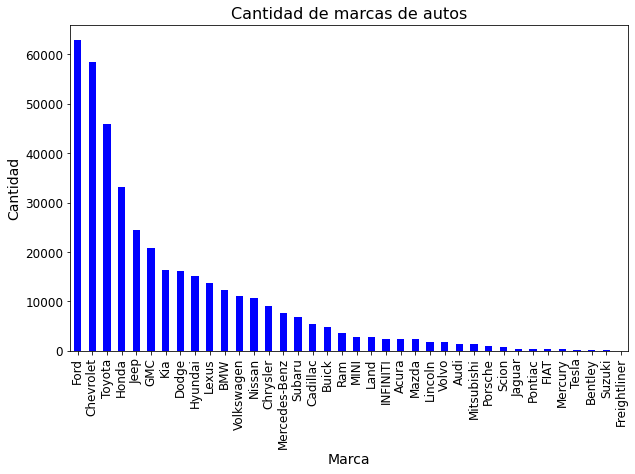

In [11]:
conteo_make = dataTraining['Make'].value_counts()
conteo_make.plot.bar(figsize=(10,6), fontsize=12, color='blue')
plt.title('Cantidad de marcas de autos', fontsize=16)
plt.xlabel('Marca', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.show()

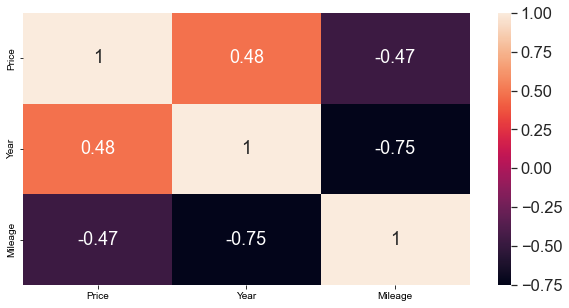

In [13]:
MatrixCorrelacion = dataTraining.corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5)  

sns.heatmap(MatrixCorrelacion, annot=True, ax=ax)
plt.show()

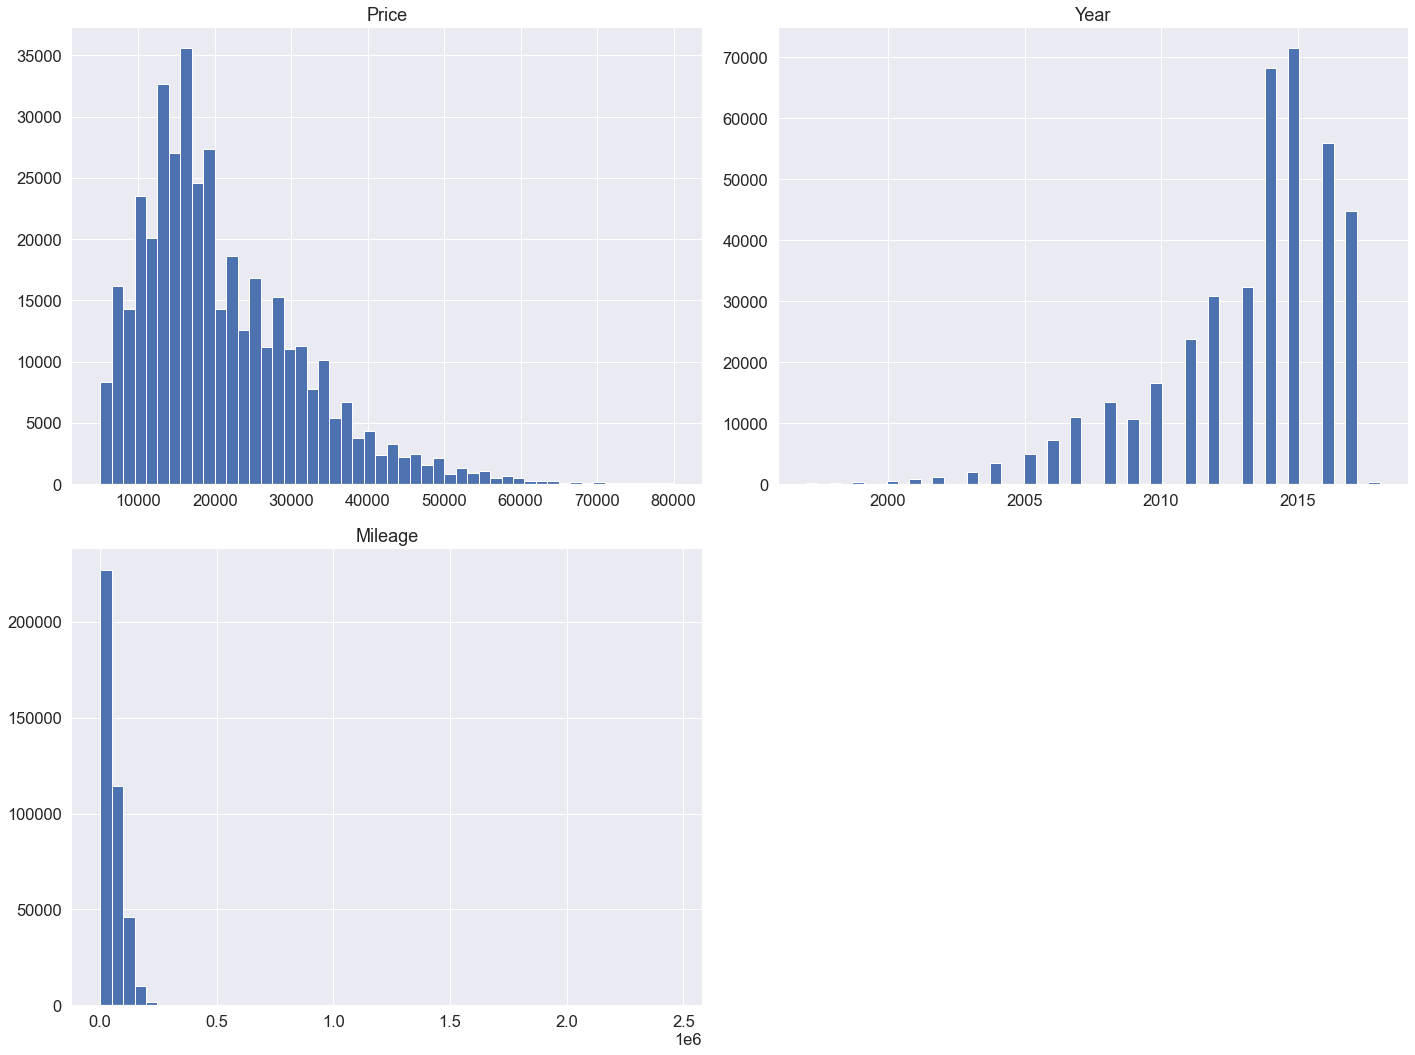

In [14]:
# Histograma para todas las variables numéricas incluyendo la variable de respuesta
dataTraining.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

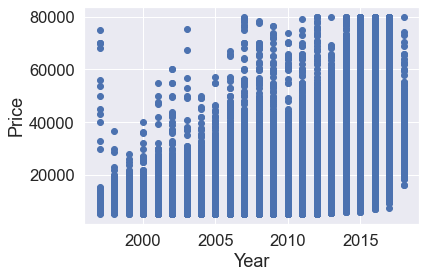

In [15]:
plt.scatter(dataTraining.Year,dataTraining.Price)
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

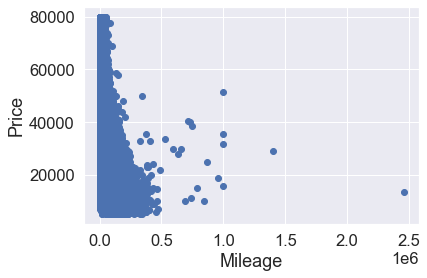

In [16]:
plt.scatter(dataTraining.Mileage,dataTraining.Price)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

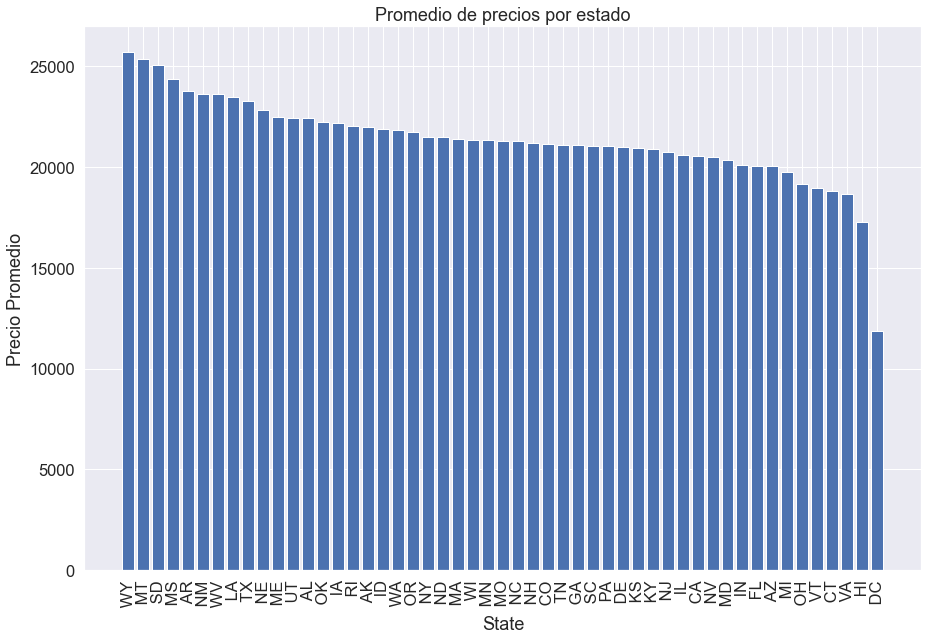

In [17]:
# Agrupamos por Estado y calculamos el promedio de los precios
data = dataTraining.groupby('State')['Price'].mean()

# Ordenamos los valores de mayor a menor
data = data.sort_values(ascending=False)

# Creamos la gráfica de barras
plt.figure(figsize=(15,10))
plt.bar(data.index, data.values)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Precio Promedio')
plt.title('Promedio de precios por estado')
plt.show()

### Preprocesamiento de datos

#### Edad del vehículo

In [18]:
time_now = datetime.datetime.now()
dataTraining['Age'] = dataTraining['Year'].apply(lambda x : time_now.year - x)
dataTraining = dataTraining.drop(['Year'], axis=1)

#### Eliminación de duplicados

In [19]:
# Eliminar duplicados
duplicados = dataTraining.duplicated()
print("Número total de duplicados en el DataFrame: ", duplicados.sum())

Número total de duplicados en el DataFrame:  169


In [20]:
dataTraining = dataTraining.drop_duplicates()

In [21]:
dataTraining.head()

,Price,Mileage,State,Make,Model,Age
0,34995,9913,FL,Jeep,Wrangler,6
1,37895,20578,OH,Chevrolet,Tahoe4WD,8
2,18430,83716,TX,BMW,X5AWD,11
3,24681,28729,OH,Cadillac,SRXLuxury,9
4,26998,64032,CO,Jeep,Wrangler,10


#### Eliminación de valores atípicos

In [22]:
# VALORES ATÍPICOS PARA MILEAGE
# Calcular el rango intercuartil (IQR)
Q1 = dataTraining['Mileage'].quantile(0.25)
Q3 = dataTraining['Mileage'].quantile(0.75)
IQR = Q3 - Q1

# Eliminar los valores atípicos utilizando el método del rango intercuartil (IQR)
dataTraining = dataTraining[~((dataTraining['Mileage'] < (Q1 - 1.5 * IQR)) | (dataTraining['Mileage'] > (Q3 + 1.5 * IQR)))]

In [23]:
dataTraining.head()

,Price,Mileage,State,Make,Model,Age
0,34995,9913,FL,Jeep,Wrangler,6
1,37895,20578,OH,Chevrolet,Tahoe4WD,8
2,18430,83716,TX,BMW,X5AWD,11
3,24681,28729,OH,Cadillac,SRXLuxury,9
4,26998,64032,CO,Jeep,Wrangler,10


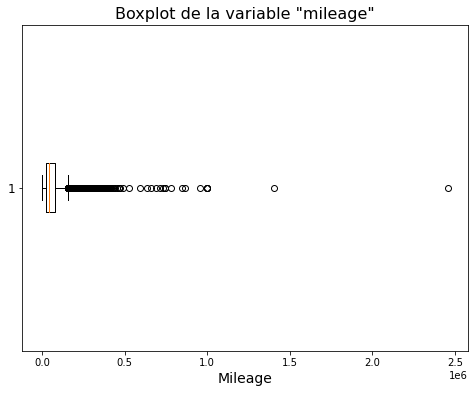

In [12]:
plt.figure(figsize=(8, 6))
plt.boxplot(dataTraining['Mileage'], vert=False)
plt.title('Boxplot de la variable "mileage"', fontsize=16)
plt.xlabel('Mileage', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

#### Estandarización Mileage en data Training y Testing

In [24]:
# Fit transform

scaler = StandardScaler()
scaler.fit(dataTraining[['Mileage']])
dataTraining[['Mileage']] = scaler.transform(dataTraining[['Mileage']])
dataTesting[['Mileage']] = scaler.transform(dataTesting[['Mileage']])

#### Dummies

##### Marca

In [25]:
# Eliminar espacios en la columna "Make"
dataTraining["Make"] = dataTraining["Make"].apply(lambda x: x.strip())

############################## Dummies para Marca ####################################
dummies = pd.get_dummies(dataTraining['Make'], prefix='Make')
dummies=dummies.drop('Make_Freightliner', axis=1)
dataTraining = pd.concat([dataTraining, dummies], axis=1)

##### Modelo
En el caso de la variable modelo, se crea una variable dummie teniendo en cuenta la media del precio para un modelo específico. Después se mapean esas particiones para asignar la misma dummie en la data de testing.

In [26]:
######################## Dummies para los modelos ##########################

# Crear un diccionario vacío para almacenar los resultados
promedios_por_modelo = {}

# Recorrer los valores distintos de la columna "Model"
for model in dataTraining["Model"].unique():
    # Obtener el promedio de la columna "Price" para los registros donde "Model" es igual a la marca actual
    promedio = dataTraining.loc[dataTraining["Model"] == model, "Price"].mean()
    # Agregar la marca y su promedio al diccionario
    promedios_por_modelo[model] = promedio
diccionario_ordenado = dict(sorted(promedios_por_modelo.items(), key=lambda x: x[1], reverse=True))

In [27]:
k = 100
column_names = []
for i in range(0, 80000, int(80000/k)):
    name = f"{i}-{i+int(80000/k)}"
    column_names.append(name)

# Creamos las columnas con el nombre de la partición en el dataframe
for i in range(len(column_names)):
    dataTraining[column_names[i]]=0

# Creamos diccionario con el rango de precios como llaves y los modelos que se encuentran en ese rango como valores
rango_precios = {}

for column in column_names:
    start, end = column.split("-")
    start, end = int(start), int(end)
    rango_precios[column] = [key for key, value in diccionario_ordenado.items() if start <= value <= end]

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTraining.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTraining.at[i, key] = 1

##### Estado

In [28]:
# Eliminar espacios en la columna "State"
dataTraining["State"] = dataTraining["State"].apply(lambda x: x.strip())

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTraining['State'], prefix='State')
dataTraining = pd.concat([dataTraining, dummies], axis=1)

dataTraining = dataTraining.drop(['State', 'Make', 'Model'], axis=1)

#### Transformación variable "Price"
En la gráfica a continuación, se puede observar que la distribución de la variable "Price" es asimétrica hacia la derecha. Por lo tanto, para la construcción del modelo se transforma la variable de respuesta con el logaritmo y después se aprecia que la distribución de la variable es casi normal.

<AxesSubplot:xlabel='Price', ylabel='Density'>

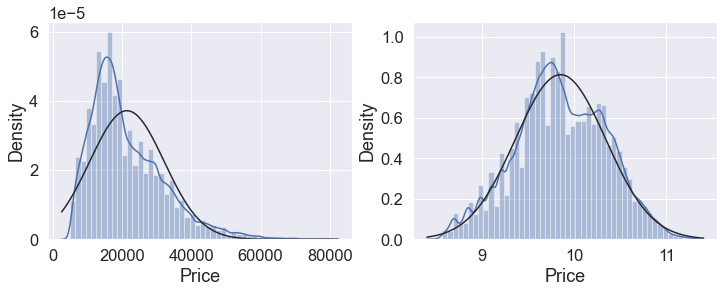

In [29]:
from scipy.stats import norm
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(dataTraining['Price'], ax=ax[0], fit=norm)
sns.distplot(np.log(dataTraining[('Price')]+1), ax=ax[1], fit= norm)

In [30]:
dataTraining['Price'] = np.log1p(dataTraining['Price'])

#### Separación de datos en set de entrenamiento y test

In [31]:
# Separación de variables predictoras (X) y variable de interés (y)
y = dataTraining['Price']
X = dataTraining.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

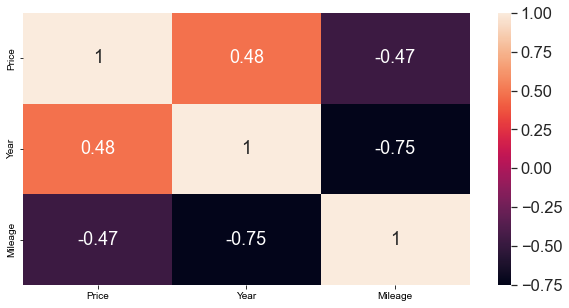

In [13]:
MatrixCorrelacion = dataTraining.corr()

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5)  

sns.heatmap(MatrixCorrelacion, annot=True, ax=ax)
plt.show()

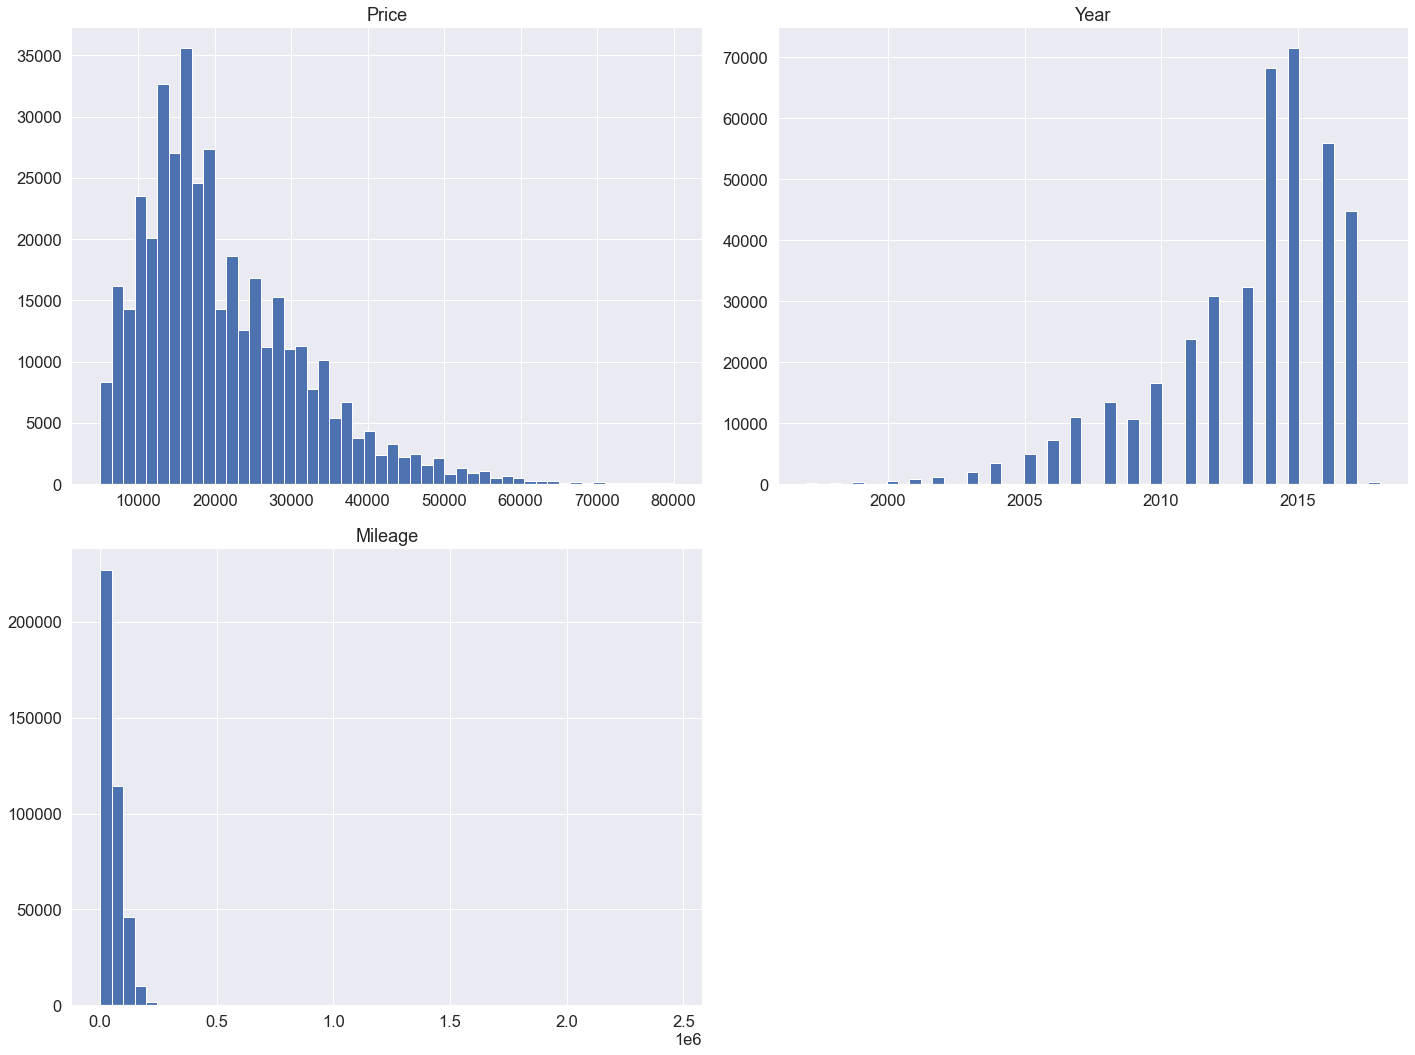

In [14]:
# Histograma para todas las variables numéricas incluyendo la variable de respuesta
dataTraining.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

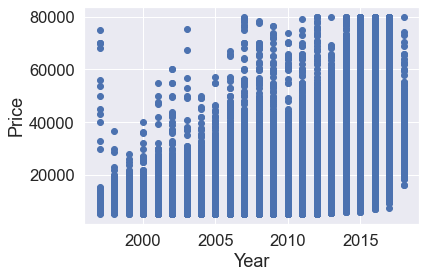

In [15]:
plt.scatter(dataTraining.Year,dataTraining.Price)
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

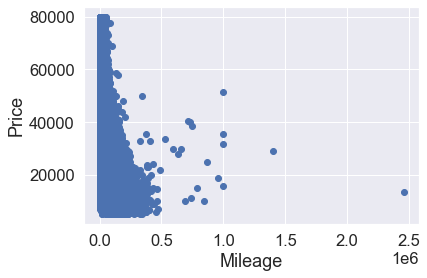

In [16]:
plt.scatter(dataTraining.Mileage,dataTraining.Price)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

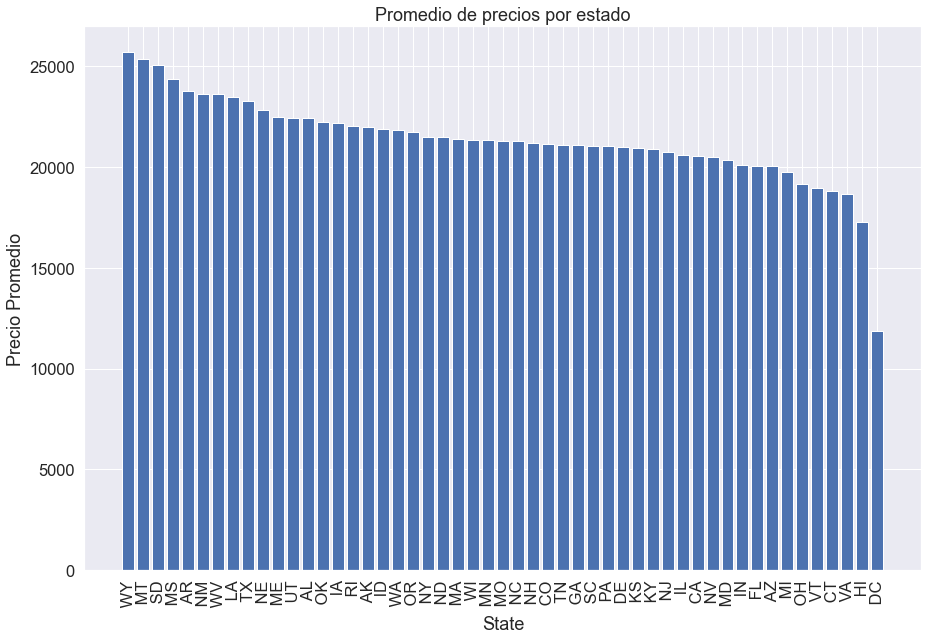

In [17]:
# Agrupamos por Estado y calculamos el promedio de los precios
data = dataTraining.groupby('State')['Price'].mean()

# Ordenamos los valores de mayor a menor
data = data.sort_values(ascending=False)

# Creamos la gráfica de barras
plt.figure(figsize=(15,10))
plt.bar(data.index, data.values)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Precio Promedio')
plt.title('Promedio de precios por estado')
plt.show()

### Calibración del modelo

#### XGBoost

##### Estimators

In [32]:
# Calibración n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(100, 400, 50)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    xgb = XGBRegressor(n_estimators=estimator, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

Text(0, 0.5, 'Accuracy')

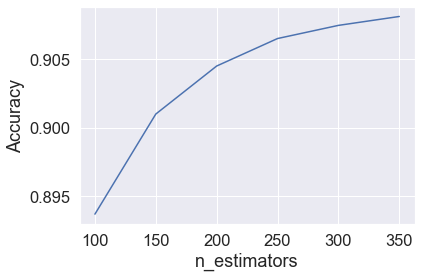

In [33]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [70]:
# nEstimators = estimator_range[accuracy_scores.index(max(accuracy_scores))]
nEstimators = 350

##### Subsample

In [37]:
# Calibración subsample
# Creación de lista de valores para iterar sobre diferentes valores de subsample
subsample_range = np.arange(0.1, 1.1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de subsample
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de subsample
for subsample in subsample_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=subsample, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

Text(0, 0.5, 'Accuracy')

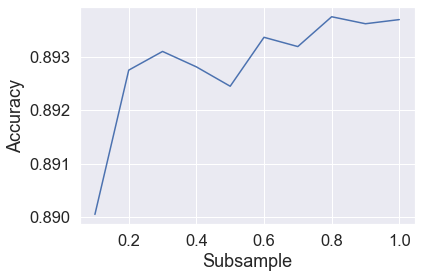

In [38]:
# Gráfica del desempeño del modelo vs la cantidad de subsample
plt.plot(subsample_range, accuracy_scores)
plt.xlabel('Subsample')
plt.ylabel('Accuracy')

In [39]:
nSubsample = subsample_range[accuracy_scores.index(max(accuracy_scores))]
nSubsample

0.8

##### Max_depth

In [40]:
# Calibración max_depth
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 11)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de subsample
for depth in depth_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=depth, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

Text(0, 0.5, 'Accuracy')

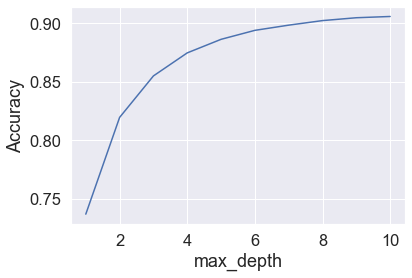

In [41]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [42]:
nDepth = depth_range[accuracy_scores.index(max(accuracy_scores))]
nDepth

10

##### Learning rate

In [43]:
# Calibración learning_rate
# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_rate_range = np.arange(0.1, 1.1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de learning_rate
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de learning_rate
for learning_rate in learning_rate_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=learning_rate,
                       random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

Text(0, 0.5, 'Accuracy')

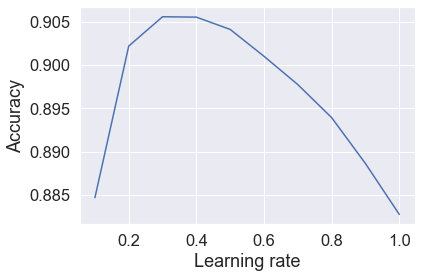

In [44]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

In [45]:
nLearningRate = learning_rate_range[accuracy_scores.index(max(accuracy_scores))]
nLearningRate

0.30000000000000004

##### Gamma

In [46]:
# Calibración gamma
# Creación de lista de valores para iterar sobre diferentes valores de gamma
gamma_range = range(0, 10, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de gamma
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de gamma
for gamma in gamma_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=nLearningRate,
                       gamma=gamma, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

Text(0, 0.5, 'Accuracy')

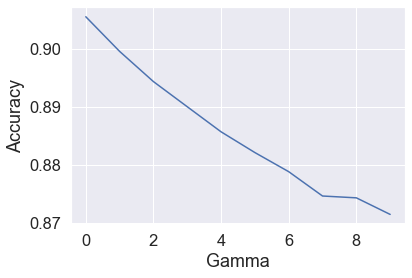

In [47]:
# Gráfica del desempeño del modelo vs la cantidad de gamma
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

In [48]:
nGamma = gamma_range[accuracy_scores.index(max(accuracy_scores))]
nGamma

0

##### Colsample_bytree

In [49]:
# Calibración colsample_bytree
# Creación de lista de valores para iterar sobre diferentes valores de colsample_bytree
colsample_bytree_range = np.arange(0, 1.1, 0.1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de colsample_bytree
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for colsample_bytree in colsample_bytree_range:
    xgb = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=nLearningRate,
                        gamma=nGamma, colsample_bytree=colsample_bytree, random_state=12345, n_jobs=-1)
    accuracy_scores.append(cross_val_score(xgb, X, y, cv=5).mean())

Text(0, 0.5, 'Accuracy')

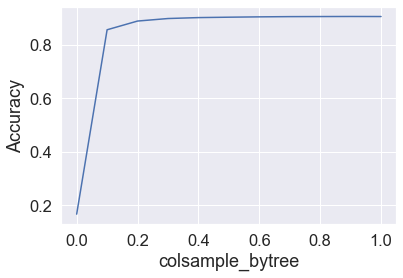

In [50]:
# Gráfica del desempeño del modelo vs la cantidad de gamma
plt.plot(colsample_bytree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

In [51]:
nColsample = colsample_bytree_range[accuracy_scores.index(max(accuracy_scores))]
nColsample

0.9

### Entrenamiento del modelo

#### XGBoost

In [88]:
nEstimators = 350
nSubsample = 0.8
nDepth = 10
nLearningRate = 0.3
nGamma = 0
nColsample = 0.9

In [71]:
MODELO = XGBRegressor(n_estimators=nEstimators, subsample=nSubsample, max_depth=nDepth, learning_rate=nLearningRate,
                        gamma=nGamma, colsample_bytree=nColsample, random_state=12345, n_jobs=-1)
MODELO.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.30000000000000004,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=350, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=12345, ...)

In [72]:
#Impresión de desempeño del modelo
y_pred = MODELO.predict(X_test)
y_pred

array([8.946585, 9.314544, 9.190659, ..., 9.78687 , 9.693137, 9.222377],
      dtype=float32)

In [73]:
#y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

In [74]:
# RMSE
xgb_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %xgb_RMSE )
# MAE
xgb_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %xgb_MAE )

RMSE: 3670.020
MAE: 2295.677


#### LightGBM

In [75]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [76]:
y_test = np.log1p(y_test)

In [77]:
lgbm = LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.

[143]	valid_0's l1: 0.283541	valid_0's l2: 0.126584
[144]	valid_0's l1: 0.283005	valid_0's l2: 0.126139
[145]	valid_0's l1: 0.282451	valid_0's l2: 0.125683
[146]	valid_0's l1: 0.281955	valid_0's l2: 0.125264
[147]	valid_0's l1: 0.281466	valid_0's l2: 0.124863
[148]	valid_0's l1: 0.280971	valid_0's l2: 0.124445
[149]	valid_0's l1: 0.280473	valid_0's l2: 0.124023
[150]	valid_0's l1: 0.279954	valid_0's l2: 0.123598
[151]	valid_0's l1: 0.279401	valid_0's l2: 0.123169
[152]	valid_0's l1: 0.278868	valid_0's l2: 0.122752
[153]	valid_0's l1: 0.278339	valid_0's l2: 0.122331
[154]	valid_0's l1: 0.277837	valid_0's l2: 0.121932
[155]	valid_0's l1: 0.277339	valid_0's l2: 0.12152
[156]	valid_0's l1: 0.276808	valid_0's l2: 0.121102
[157]	valid_0's l1: 0.276306	valid_0's l2: 0.120698
[158]	valid_0's l1: 0.275785	valid_0's l2: 0.120297
[159]	valid_0's l1: 0.275353	valid_0's l2: 0.119916
[160]	valid_0's l1: 0.274862	valid_0's l2: 0.119524
[161]	valid_0's l1: 0.27442	valid_0's l2: 0.119153
[162]	valid_0'

[303]	valid_0's l1: 0.225569	valid_0's l2: 0.0826857
[304]	valid_0's l1: 0.225276	valid_0's l2: 0.0825086
[305]	valid_0's l1: 0.225054	valid_0's l2: 0.0823444
[306]	valid_0's l1: 0.224766	valid_0's l2: 0.0821716
[307]	valid_0's l1: 0.224519	valid_0's l2: 0.0819958
[308]	valid_0's l1: 0.22424	valid_0's l2: 0.0818254
[309]	valid_0's l1: 0.223974	valid_0's l2: 0.0816519
[310]	valid_0's l1: 0.223704	valid_0's l2: 0.0814857
[311]	valid_0's l1: 0.223446	valid_0's l2: 0.0813223
[312]	valid_0's l1: 0.223192	valid_0's l2: 0.0811597
[313]	valid_0's l1: 0.222926	valid_0's l2: 0.0809882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[314]	valid_0's l1: 0.222725	valid_0's l2: 0.0808284
[315]	valid_0's l1: 0.222467	valid_0's l2: 0.0806616
[316]	valid_0's l1: 0.222246	valid_0's l2: 0.0805025
[317]	valid_0's l1: 0.22199	valid_0's l2: 0.0803405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's l1: 0.221784	valid_0's l2: 0.0801812
[319

[434]	valid_0's l1: 0.200808	valid_0's l2: 0.0664289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[435]	valid_0's l1: 0.200647	valid_0's l2: 0.0663376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[436]	valid_0's l1: 0.200518	valid_0's l2: 0.0662553
[437]	valid_0's l1: 0.200378	valid_0's l2: 0.0661623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's l1: 0.200252	valid_0's l2: 0.0660774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's l1: 0.200101	valid_0's l2: 0.0659896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's l1: 0.199946	valid_0's l2: 0.065896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's l1: 0.199799	valid_0's l2: 0.0658041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's l1: 0.199656	valid_0's l2: 0.065714


[516]	valid_0's l1: 0.190028	valid_0's l2: 0.0599403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's l1: 0.189931	valid_0's l2: 0.0598787
[518]	valid_0's l1: 0.189813	valid_0's l2: 0.0598084
[519]	valid_0's l1: 0.189703	valid_0's l2: 0.0597431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's l1: 0.189574	valid_0's l2: 0.0596732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's l1: 0.189464	valid_0's l2: 0.0596095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's l1: 0.189355	valid_0's l2: 0.0595454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's l1: 0.189236	valid_0's l2: 0.05948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's l1: 0.189127	valid_0's l2: 0.059417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's l1: 0.180538	valid_0's l2: 0.0546705
[604]	valid_0's l1: 0.180435	valid_0's l2: 0.0546107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's l1: 0.180334	valid_0's l2: 0.0545614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's l1: 0.180232	valid_0's l2: 0.0545123
[607]	valid_0's l1: 0.180132	valid_0's l2: 0.0544543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's l1: 0.180031	valid_0's l2: 0.0544066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's l1: 0.179936	valid_0's l2: 0.0543586
[610]	valid_0's l1: 0.17983	valid_0's l2: 0.0543002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's l1: 0.179753	valid_0's l2: 0.0542523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	valid_0's l1: 0.174311	valid_0's l2: 0.0513051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's l1: 0.174226	valid_0's l2: 0.0512586
[678]	valid_0's l1: 0.174134	valid_0's l2: 0.0512102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	valid_0's l1: 0.174041	valid_0's l2: 0.0511642
[680]	valid_0's l1: 0.173953	valid_0's l2: 0.051117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's l1: 0.173876	valid_0's l2: 0.0510793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's l1: 0.173804	valid_0's l2: 0.0510425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's l1: 0.173731	valid_0's l2: 0.0510047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's l1: 0.173668	valid_0's l2: 0.05097
[

[744]	valid_0's l1: 0.169164	valid_0's l2: 0.0485972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's l1: 0.169094	valid_0's l2: 0.0485662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's l1: 0.169035	valid_0's l2: 0.0485365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's l1: 0.168968	valid_0's l2: 0.0484991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's l1: 0.168904	valid_0's l2: 0.0484694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's l1: 0.16884	valid_0's l2: 0.0484394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's l1: 0.16877	valid_0's l2: 0.048402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's l1: 0.168699	valid_0's l2: 0.0483691
[LightGBM] [Warning] No further splits with positive g

[820]	valid_0's l1: 0.16446	valid_0's l2: 0.0461664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's l1: 0.164412	valid_0's l2: 0.0461415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's l1: 0.164362	valid_0's l2: 0.0461172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's l1: 0.164309	valid_0's l2: 0.0460928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's l1: 0.164253	valid_0's l2: 0.0460672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's l1: 0.164183	valid_0's l2: 0.0460324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's l1: 0.164134	valid_0's l2: 0.0460085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's l1: 0.164083	valid_0's l2: 0.0459838
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[896]	valid_0's l1: 0.160351	valid_0's l2: 0.0441288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's l1: 0.160294	valid_0's l2: 0.0441058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's l1: 0.160244	valid_0's l2: 0.0440801
[899]	valid_0's l1: 0.160163	valid_0's l2: 0.0440419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's l1: 0.160109	valid_0's l2: 0.0440188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's l1: 0.160068	valid_0's l2: 0.043998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's l1: 0.160015	valid_0's l2: 0.0439644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's l1: 0.159978	valid_0's l2: 0.0439446
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's l1: 0.156741	valid_0's l2: 0.0422889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's l1: 0.156708	valid_0's l2: 0.0422699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	valid_0's l1: 0.156675	valid_0's l2: 0.0422513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's l1: 0.156643	valid_0's l2: 0.0422338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's l1: 0.156609	valid_0's l2: 0.0422155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's l1: 0.156574	valid_0's l2: 0.0421978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's l1: 0.156509	valid_0's l2: 0.0421664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's l1: 0.156458	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's l1: 0.154166	valid_0's l2: 0.0410145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's l1: 0.154139	valid_0's l2: 0.0409999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's l1: 0.154092	valid_0's l2: 0.0409769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's l1: 0.154061	valid_0's l2: 0.0409623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1043]	valid_0's l1: 0.154027	valid_0's l2: 0.0409457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1044]	valid_0's l1: 0.153992	valid_0's l2: 0.0409295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1045]	valid_0's l1: 0.15396	valid_0's l2: 0.0409125
[1046]	valid_0's l1: 0.153878	valid_0's l2: 0.0408723
[LightGBM] [Warning] No further splits with 

[1109]	valid_0's l1: 0.151293	valid_0's l2: 0.0396182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1110]	valid_0's l1: 0.151254	valid_0's l2: 0.0395985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1111]	valid_0's l1: 0.151211	valid_0's l2: 0.0395798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1112]	valid_0's l1: 0.151154	valid_0's l2: 0.0395539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1113]	valid_0's l1: 0.151123	valid_0's l2: 0.0395344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1114]	valid_0's l1: 0.151079	valid_0's l2: 0.0395157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1115]	valid_0's l1: 0.151012	valid_0's l2: 0.0394826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1116]	valid_0's l1: 0.150971	valid_0's l2: 0.0394638
[LightGBM] [Warning] No further splits with

[1178]	valid_0's l1: 0.148897	valid_0's l2: 0.0384623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1179]	valid_0's l1: 0.148868	valid_0's l2: 0.0384491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1180]	valid_0's l1: 0.14884	valid_0's l2: 0.0384379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1181]	valid_0's l1: 0.148809	valid_0's l2: 0.0384239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1182]	valid_0's l1: 0.148786	valid_0's l2: 0.0384111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1183]	valid_0's l1: 0.148726	valid_0's l2: 0.0383824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1184]	valid_0's l1: 0.148679	valid_0's l2: 0.0383599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1185]	valid_0's l1: 0.148655	valid_0's l2: 0.0383476
[LightGBM] [Warning] No further splits with 

[1251]	valid_0's l1: 0.14673	valid_0's l2: 0.037418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1252]	valid_0's l1: 0.146708	valid_0's l2: 0.0374081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1253]	valid_0's l1: 0.146685	valid_0's l2: 0.0373979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1254]	valid_0's l1: 0.146657	valid_0's l2: 0.0373864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1255]	valid_0's l1: 0.146629	valid_0's l2: 0.0373747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's l1: 0.146606	valid_0's l2: 0.0373643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's l1: 0.146574	valid_0's l2: 0.0373486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's l1: 0.14655	valid_0's l2: 0.0373383
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's l1: 0.144574	valid_0's l2: 0.0364197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1329]	valid_0's l1: 0.144554	valid_0's l2: 0.0364101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1330]	valid_0's l1: 0.144537	valid_0's l2: 0.0364009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1331]	valid_0's l1: 0.144482	valid_0's l2: 0.0363741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1332]	valid_0's l1: 0.144431	valid_0's l2: 0.0363479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1333]	valid_0's l1: 0.144387	valid_0's l2: 0.0363261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1334]	valid_0's l1: 0.144357	valid_0's l2: 0.0363138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1335]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1403]	valid_0's l1: 0.142498	valid_0's l2: 0.0354627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's l1: 0.142484	valid_0's l2: 0.0354546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1405]	valid_0's l1: 0.142469	valid_0's l2: 0.0354462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's l1: 0.142453	valid_0's l2: 0.0354381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's l1: 0.14244	valid_0's l2: 0.0354301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's l1: 0.142417	valid_0's l2: 0.0354192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's l1: 0.142404	valid_0's l2: 0.0354116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's l1: 0.

[1479]	valid_0's l1: 0.140709	valid_0's l2: 0.0346448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1480]	valid_0's l1: 0.140665	valid_0's l2: 0.0346262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1481]	valid_0's l1: 0.140632	valid_0's l2: 0.0346114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1482]	valid_0's l1: 0.14061	valid_0's l2: 0.0346009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1483]	valid_0's l1: 0.140589	valid_0's l2: 0.0345907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1484]	valid_0's l1: 0.140565	valid_0's l2: 0.0345803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1485]	valid_0's l1: 0.140539	valid_0's l2: 0.0345687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1486]	valid_0's l1: 0.140515	valid_0's l2: 0.0345576
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's l1: 0.139373	valid_0's l2: 0.034033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's l1: 0.139353	valid_0's l2: 0.0340246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's l1: 0.139337	valid_0's l2: 0.0340168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1549]	valid_0's l1: 0.13932	valid_0's l2: 0.0340105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's l1: 0.1393	valid_0's l2: 0.0340023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's l1: 0.139273	valid_0's l2: 0.0339894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's l1: 0.139257	valid_0's l2: 0.0339829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1553]	valid_0's l1: 0.139

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1617]	valid_0's l1: 0.137921	valid_0's l2: 0.0333851
[1618]	valid_0's l1: 0.137873	valid_0's l2: 0.0333626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1619]	valid_0's l1: 0.137853	valid_0's l2: 0.0333555
[1620]	valid_0's l1: 0.13781	valid_0's l2: 0.0333348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1621]	valid_0's l1: 0.137788	valid_0's l2: 0.0333259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1622]	valid_0's l1: 0.13777	valid_0's l2: 0.033319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1623]	valid_0's l1: 0.13775	valid_0's l2: 0.0333104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1624]	valid_0's l1: 0.137729	valid_0's l2: 0.033303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1625]	valid_0's l1: 0.137709	valid_0's l2: 0.03

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1692]	valid_0's l1: 0.13652	valid_0's l2: 0.0327623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1693]	valid_0's l1: 0.136504	valid_0's l2: 0.0327556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1694]	valid_0's l1: 0.136492	valid_0's l2: 0.0327501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1695]	valid_0's l1: 0.13648	valid_0's l2: 0.0327448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1696]	valid_0's l1: 0.13647	valid_0's l2: 0.0327397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1697]	valid_0's l1: 0.136455	valid_0's l2: 0.0327341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1698]	valid_0's l1: 0.136441	valid_0's l2: 0.0327285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1699]	valid_0's l1: 0.13

[1768]	valid_0's l1: 0.135331	valid_0's l2: 0.0322391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1769]	valid_0's l1: 0.13531	valid_0's l2: 0.0322312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1770]	valid_0's l1: 0.135284	valid_0's l2: 0.0322196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1771]	valid_0's l1: 0.135256	valid_0's l2: 0.0322071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1772]	valid_0's l1: 0.135245	valid_0's l2: 0.0322015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1773]	valid_0's l1: 0.135211	valid_0's l2: 0.0321866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1774]	valid_0's l1: 0.135199	valid_0's l2: 0.0321811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1775]	valid_0's l1: 0.135188	valid_0's l2: 0.0321751
[LightGBM] [Warning] No further splits with 

[1843]	valid_0's l1: 0.134027	valid_0's l2: 0.0316788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1844]	valid_0's l1: 0.134009	valid_0's l2: 0.0316713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1845]	valid_0's l1: 0.13399	valid_0's l2: 0.0316634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1846]	valid_0's l1: 0.133981	valid_0's l2: 0.0316571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1847]	valid_0's l1: 0.133961	valid_0's l2: 0.0316492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1848]	valid_0's l1: 0.133944	valid_0's l2: 0.0316411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1849]	valid_0's l1: 0.133925	valid_0's l2: 0.0316339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1850]	valid_0's l1: 0.133904	valid_0's l2: 0.0316264
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1908]	valid_0's l1: 0.133148	valid_0's l2: 0.031299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1909]	valid_0's l1: 0.133126	valid_0's l2: 0.0312889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1910]	valid_0's l1: 0.133114	valid_0's l2: 0.0312846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1911]	valid_0's l1: 0.133085	valid_0's l2: 0.0312722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1912]	valid_0's l1: 0.133074	valid_0's l2: 0.031267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1913]	valid_0's l1: 0.133047	valid_0's l2: 0.0312559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1914]	valid_0's l1: 0.133032	valid_0's l2: 0.0312501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1915]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1978]	valid_0's l1: 0.132102	valid_0's l2: 0.0308579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1979]	valid_0's l1: 0.132084	valid_0's l2: 0.0308506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1980]	valid_0's l1: 0.132071	valid_0's l2: 0.0308448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1981]	valid_0's l1: 0.132051	valid_0's l2: 0.0308361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1982]	valid_0's l1: 0.132024	valid_0's l2: 0.0308234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1983]	valid_0's l1: 0.132005	valid_0's l2: 0.0308145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1984]	valid_0's l1: 0.131983	valid_0's l2: 0.0308046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1985]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2049]	valid_0's l1: 0.130981	valid_0's l2: 0.0303847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2050]	valid_0's l1: 0.130973	valid_0's l2: 0.0303807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2051]	valid_0's l1: 0.130958	valid_0's l2: 0.0303753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2052]	valid_0's l1: 0.130945	valid_0's l2: 0.0303702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2053]	valid_0's l1: 0.130933	valid_0's l2: 0.0303658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2054]	valid_0's l1: 0.130923	valid_0's l2: 0.0303619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2055]	valid_0's l1: 0.130908	valid_0's l2: 0.0303567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2056]	valid_0's l1: 0

[2114]	valid_0's l1: 0.130038	valid_0's l2: 0.0299978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2115]	valid_0's l1: 0.130021	valid_0's l2: 0.0299906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2116]	valid_0's l1: 0.130006	valid_0's l2: 0.0299841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2117]	valid_0's l1: 0.12999	valid_0's l2: 0.0299773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2118]	valid_0's l1: 0.129976	valid_0's l2: 0.029971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2119]	valid_0's l1: 0.129966	valid_0's l2: 0.0299674
[2120]	valid_0's l1: 0.129947	valid_0's l2: 0.0299594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2121]	valid_0's l1: 0.129939	valid_0's l2: 0.0299563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2122]	valid_0's l1: 0.12993	valid_0's l2: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2185]	valid_0's l1: 0.12922	valid_0's l2: 0.0296644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2186]	valid_0's l1: 0.129213	valid_0's l2: 0.0296611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2187]	valid_0's l1: 0.129205	valid_0's l2: 0.0296571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2188]	valid_0's l1: 0.129198	valid_0's l2: 0.0296541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2189]	valid_0's l1: 0.129186	valid_0's l2: 0.0296499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2190]	valid_0's l1: 0.129174	valid_0's l2: 0.0296446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2191]	valid_0's l1: 0.129166	valid_0's l2: 0.0296416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2192]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2260]	valid_0's l1: 0.128405	valid_0's l2: 0.0293385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2261]	valid_0's l1: 0.128398	valid_0's l2: 0.0293352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2262]	valid_0's l1: 0.128386	valid_0's l2: 0.0293308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2263]	valid_0's l1: 0.128376	valid_0's l2: 0.0293267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2264]	valid_0's l1: 0.128368	valid_0's l2: 0.029323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2265]	valid_0's l1: 0.12835	valid_0's l2: 0.029316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2266]	valid_0's l1: 0.128342	valid_0's l2: 0.0293124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2267]	valid_0's l1: 0.12

[2336]	valid_0's l1: 0.127451	valid_0's l2: 0.028944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2337]	valid_0's l1: 0.127432	valid_0's l2: 0.0289363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2338]	valid_0's l1: 0.127422	valid_0's l2: 0.0289324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2339]	valid_0's l1: 0.127416	valid_0's l2: 0.0289296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2340]	valid_0's l1: 0.127401	valid_0's l2: 0.0289242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2341]	valid_0's l1: 0.127393	valid_0's l2: 0.0289211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2342]	valid_0's l1: 0.127386	valid_0's l2: 0.0289181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2343]	valid_0's l1: 0.127377	valid_0's l2: 0.0289147
[LightGBM] [Warning] No further splits with 

[2409]	valid_0's l1: 0.126625	valid_0's l2: 0.0286212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2410]	valid_0's l1: 0.126616	valid_0's l2: 0.0286176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2411]	valid_0's l1: 0.126609	valid_0's l2: 0.0286144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2412]	valid_0's l1: 0.126602	valid_0's l2: 0.0286113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2413]	valid_0's l1: 0.126586	valid_0's l2: 0.0286057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2414]	valid_0's l1: 0.12658	valid_0's l2: 0.0286029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2415]	valid_0's l1: 0.126573	valid_0's l2: 0.0285998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2416]	valid_0's l1: 0.126566	valid_0's l2: 0.0285969
[LightGBM] [Warning] No further splits with 

[2478]	valid_0's l1: 0.125918	valid_0's l2: 0.0283526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2479]	valid_0's l1: 0.125912	valid_0's l2: 0.0283499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2480]	valid_0's l1: 0.125905	valid_0's l2: 0.0283474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2481]	valid_0's l1: 0.125897	valid_0's l2: 0.0283445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2482]	valid_0's l1: 0.125888	valid_0's l2: 0.0283413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2483]	valid_0's l1: 0.125882	valid_0's l2: 0.0283387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2484]	valid_0's l1: 0.125874	valid_0's l2: 0.0283355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2485]	valid_0's l1: 0.125868	valid_0's l2: 0.0283328
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2563]	valid_0's l1: 0.125223	valid_0's l2: 0.0280785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2564]	valid_0's l1: 0.1252	valid_0's l2: 0.0280695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2565]	valid_0's l1: 0.125177	valid_0's l2: 0.02806
[2566]	valid_0's l1: 0.125156	valid_0's l2: 0.0280515
[2567]	valid_0's l1: 0.125136	valid_0's l2: 0.0280435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2568]	valid_0's l1: 0.125122	valid_0's l2: 0.0280381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2569]	valid_0's l1: 0.125111	valid_0's l2: 0.0280332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2570]	valid_0's l1: 0.125099	valid_0's l2: 0.0280283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2571]	valid_0's l1: 0.125091	valid_0's l2: 0.0

[2631]	valid_0's l1: 0.124618	valid_0's l2: 0.0278427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2632]	valid_0's l1: 0.124607	valid_0's l2: 0.0278386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2633]	valid_0's l1: 0.124598	valid_0's l2: 0.0278361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2634]	valid_0's l1: 0.124591	valid_0's l2: 0.0278334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2635]	valid_0's l1: 0.124584	valid_0's l2: 0.0278311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2636]	valid_0's l1: 0.124573	valid_0's l2: 0.0278271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2637]	valid_0's l1: 0.124565	valid_0's l2: 0.0278247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2638]	valid_0's l1: 0.124554	valid_0's l2: 0.0278208
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2702]	valid_0's l1: 0.123975	valid_0's l2: 0.0276017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2703]	valid_0's l1: 0.12397	valid_0's l2: 0.0275997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2704]	valid_0's l1: 0.123962	valid_0's l2: 0.0275965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2705]	valid_0's l1: 0.123956	valid_0's l2: 0.0275942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2706]	valid_0's l1: 0.12394	valid_0's l2: 0.0275881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2707]	valid_0's l1: 0.123932	valid_0's l2: 0.0275854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2708]	valid_0's l1: 0.123923	valid_0's l2: 0.0275819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2709]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2777]	valid_0's l1: 0.123424	valid_0's l2: 0.0274007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2778]	valid_0's l1: 0.12342	valid_0's l2: 0.0273992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2779]	valid_0's l1: 0.123415	valid_0's l2: 0.027397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2780]	valid_0's l1: 0.12341	valid_0's l2: 0.0273954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2781]	valid_0's l1: 0.123404	valid_0's l2: 0.027393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2782]	valid_0's l1: 0.1234	valid_0's l2: 0.0273914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2783]	valid_0's l1: 0.123393	valid_0's l2: 0.027389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2784]	valid_0's l1: 0.123386

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2844]	valid_0's l1: 0.122787	valid_0's l2: 0.0271619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2845]	valid_0's l1: 0.122781	valid_0's l2: 0.0271599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2846]	valid_0's l1: 0.122772	valid_0's l2: 0.0271567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2847]	valid_0's l1: 0.122763	valid_0's l2: 0.0271536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2848]	valid_0's l1: 0.122754	valid_0's l2: 0.0271506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2849]	valid_0's l1: 0.122748	valid_0's l2: 0.0271485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2850]	valid_0's l1: 0.122739	valid_0's l2: 0.0271458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2851]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2909]	valid_0's l1: 0.122366	valid_0's l2: 0.0270062
[2910]	valid_0's l1: 0.122353	valid_0's l2: 0.0270014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2911]	valid_0's l1: 0.122347	valid_0's l2: 0.0269995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2912]	valid_0's l1: 0.122342	valid_0's l2: 0.0269975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2913]	valid_0's l1: 0.122337	valid_0's l2: 0.0269954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2914]	valid_0's l1: 0.122331	valid_0's l2: 0.0269936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2915]	valid_0's l1: 0.122326	valid_0's l2: 0.0269917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2916]	valid_0's l1: 0.122319	valid_0's l2: 0.0269895
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2977]	valid_0's l1: 0.121988	valid_0's l2: 0.0268654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2978]	valid_0's l1: 0.121985	valid_0's l2: 0.0268645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2979]	valid_0's l1: 0.121981	valid_0's l2: 0.0268631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2980]	valid_0's l1: 0.121978	valid_0's l2: 0.026862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2981]	valid_0's l1: 0.121966	valid_0's l2: 0.0268573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2982]	valid_0's l1: 0.121961	valid_0's l2: 0.0268556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2983]	valid_0's l1: 0.121957	valid_0's l2: 0.0268539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2984]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3048]	valid_0's l1: 0.12151	valid_0's l2: 0.0266966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3049]	valid_0's l1: 0.121507	valid_0's l2: 0.0266956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3050]	valid_0's l1: 0.121502	valid_0's l2: 0.0266942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3051]	valid_0's l1: 0.121496	valid_0's l2: 0.0266922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3052]	valid_0's l1: 0.121489	valid_0's l2: 0.0266902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3053]	valid_0's l1: 0.121483	valid_0's l2: 0.0266883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3054]	valid_0's l1: 0.121474	valid_0's l2: 0.0266856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3055]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3119]	valid_0's l1: 0.121026	valid_0's l2: 0.0265251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3120]	valid_0's l1: 0.121016	valid_0's l2: 0.026521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3121]	valid_0's l1: 0.121012	valid_0's l2: 0.0265196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3122]	valid_0's l1: 0.121008	valid_0's l2: 0.0265183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3123]	valid_0's l1: 0.121004	valid_0's l2: 0.0265168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3124]	valid_0's l1: 0.121	valid_0's l2: 0.0265153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3125]	valid_0's l1: 0.120997	valid_0's l2: 0.0265139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3126]	valid_0's l1: 0.120

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3189]	valid_0's l1: 0.120573	valid_0's l2: 0.0263602
[3190]	valid_0's l1: 0.120565	valid_0's l2: 0.0263572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3191]	valid_0's l1: 0.120562	valid_0's l2: 0.0263563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3192]	valid_0's l1: 0.120559	valid_0's l2: 0.0263553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3193]	valid_0's l1: 0.120556	valid_0's l2: 0.0263544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3194]	valid_0's l1: 0.120553	valid_0's l2: 0.0263535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3195]	valid_0's l1: 0.120549	valid_0's l2: 0.0263522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3196]	valid_0's l1: 0.120545	valid_0's l2: 0.0263504
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3260]	valid_0's l1: 0.120254	valid_0's l2: 0.0262494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3261]	valid_0's l1: 0.120241	valid_0's l2: 0.0262448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3262]	valid_0's l1: 0.120228	valid_0's l2: 0.0262402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3263]	valid_0's l1: 0.120215	valid_0's l2: 0.0262356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3264]	valid_0's l1: 0.120202	valid_0's l2: 0.0262312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3265]	valid_0's l1: 0.120189	valid_0's l2: 0.0262267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3266]	valid_0's l1: 0.120174	valid_0's l2: 0.0262212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3267]	valid_0's l1: 0

[3326]	valid_0's l1: 0.119777	valid_0's l2: 0.0260782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3327]	valid_0's l1: 0.119773	valid_0's l2: 0.0260765
[3328]	valid_0's l1: 0.119766	valid_0's l2: 0.0260745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3329]	valid_0's l1: 0.119762	valid_0's l2: 0.0260732
[3330]	valid_0's l1: 0.119756	valid_0's l2: 0.0260712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3331]	valid_0's l1: 0.119751	valid_0's l2: 0.0260694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3332]	valid_0's l1: 0.119746	valid_0's l2: 0.0260677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3333]	valid_0's l1: 0.119741	valid_0's l2: 0.0260659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3334]	valid_0's l1: 0.119737	valid_0's l2: 0.0260646
[LightGBM] [Warning] No further splits with positive gain, best 

[3397]	valid_0's l1: 0.119448	valid_0's l2: 0.0259624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3398]	valid_0's l1: 0.119444	valid_0's l2: 0.0259611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3399]	valid_0's l1: 0.11944	valid_0's l2: 0.0259599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3400]	valid_0's l1: 0.119438	valid_0's l2: 0.0259593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3401]	valid_0's l1: 0.119435	valid_0's l2: 0.0259581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3402]	valid_0's l1: 0.119431	valid_0's l2: 0.025957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3403]	valid_0's l1: 0.119428	valid_0's l2: 0.0259559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3404]	valid_0's l1: 0.119424	valid_0's l2: 0.0259547
[LightGBM] [Warning] No further splits with p

[3465]	valid_0's l1: 0.119179	valid_0's l2: 0.0258675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3466]	valid_0's l1: 0.119178	valid_0's l2: 0.0258666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3467]	valid_0's l1: 0.119176	valid_0's l2: 0.0258657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3468]	valid_0's l1: 0.119173	valid_0's l2: 0.0258649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3469]	valid_0's l1: 0.119172	valid_0's l2: 0.0258641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3470]	valid_0's l1: 0.119169	valid_0's l2: 0.025863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3471]	valid_0's l1: 0.119166	valid_0's l2: 0.0258618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3472]	valid_0's l1: 0.119162	valid_0's l2: 0.0258605
[LightGBM] [Warning] No further splits with 

[3533]	valid_0's l1: 0.118912	valid_0's l2: 0.0257739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3534]	valid_0's l1: 0.118905	valid_0's l2: 0.025772
[3535]	valid_0's l1: 0.118894	valid_0's l2: 0.0257685
[3536]	valid_0's l1: 0.118885	valid_0's l2: 0.0257653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3537]	valid_0's l1: 0.118879	valid_0's l2: 0.0257635
[3538]	valid_0's l1: 0.118867	valid_0's l2: 0.0257599
[3539]	valid_0's l1: 0.118857	valid_0's l2: 0.0257563
[3540]	valid_0's l1: 0.118846	valid_0's l2: 0.0257529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3541]	valid_0's l1: 0.118841	valid_0's l2: 0.0257509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3542]	valid_0's l1: 0.118834	valid_0's l2: 0.0257479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3543]	valid_0's l1: 0.118828	valid_0's l2: 0.0257458
[LightGBM] [Warning] No further 

[3602]	valid_0's l1: 0.118588	valid_0's l2: 0.0256608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3603]	valid_0's l1: 0.118586	valid_0's l2: 0.0256602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3604]	valid_0's l1: 0.118584	valid_0's l2: 0.0256596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3605]	valid_0's l1: 0.11858	valid_0's l2: 0.0256583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3606]	valid_0's l1: 0.118579	valid_0's l2: 0.0256577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3607]	valid_0's l1: 0.118577	valid_0's l2: 0.0256571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3608]	valid_0's l1: 0.118572	valid_0's l2: 0.0256554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3609]	valid_0's l1: 0.11857	valid_0's l2: 0.0256548
[LightGBM] [Warning] No further splits with p

[3672]	valid_0's l1: 0.118287	valid_0's l2: 0.025554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3673]	valid_0's l1: 0.118277	valid_0's l2: 0.0255508
[3674]	valid_0's l1: 0.118261	valid_0's l2: 0.0255448
[3675]	valid_0's l1: 0.118247	valid_0's l2: 0.0255402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3676]	valid_0's l1: 0.118245	valid_0's l2: 0.0255396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3677]	valid_0's l1: 0.118243	valid_0's l2: 0.0255391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3678]	valid_0's l1: 0.11823	valid_0's l2: 0.0255342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3679]	valid_0's l1: 0.118216	valid_0's l2: 0.0255296
[3680]	valid_0's l1: 0.1182	valid_0's l2: 0.0255235
[3681]	valid_0's l1: 0.11818	valid_0's l2: 0.0255164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3682]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3749]	valid_0's l1: 0.117811	valid_0's l2: 0.0253885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3750]	valid_0's l1: 0.117809	valid_0's l2: 0.0253878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3751]	valid_0's l1: 0.117801	valid_0's l2: 0.0253851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3752]	valid_0's l1: 0.117797	valid_0's l2: 0.0253838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3753]	valid_0's l1: 0.117793	valid_0's l2: 0.0253822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3754]	valid_0's l1: 0.117789	valid_0's l2: 0.0253812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3755]	valid_0's l1: 0.117786	valid_0's l2: 0.0253799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3756]	valid_0's l1: 0

[3819]	valid_0's l1: 0.117477	valid_0's l2: 0.0252727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3820]	valid_0's l1: 0.117475	valid_0's l2: 0.0252717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3821]	valid_0's l1: 0.117469	valid_0's l2: 0.0252696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3822]	valid_0's l1: 0.117466	valid_0's l2: 0.0252683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3823]	valid_0's l1: 0.117457	valid_0's l2: 0.0252644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3824]	valid_0's l1: 0.117455	valid_0's l2: 0.0252638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3825]	valid_0's l1: 0.117452	valid_0's l2: 0.0252626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3826]	valid_0's l1: 0.117449	valid_0's l2: 0.0252618
[LightGBM] [Warning] No further splits with

[3889]	valid_0's l1: 0.117078	valid_0's l2: 0.0251285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3890]	valid_0's l1: 0.117075	valid_0's l2: 0.0251277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3891]	valid_0's l1: 0.117063	valid_0's l2: 0.0251234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3892]	valid_0's l1: 0.117061	valid_0's l2: 0.0251226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3893]	valid_0's l1: 0.117052	valid_0's l2: 0.0251193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3894]	valid_0's l1: 0.117049	valid_0's l2: 0.0251182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3895]	valid_0's l1: 0.11704	valid_0's l2: 0.0251144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3896]	valid_0's l1: 0.117032	valid_0's l2: 0.0251117
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3957]	valid_0's l1: 0.116857	valid_0's l2: 0.0250479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3958]	valid_0's l1: 0.116854	valid_0's l2: 0.025047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3959]	valid_0's l1: 0.116853	valid_0's l2: 0.0250465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3960]	valid_0's l1: 0.11685	valid_0's l2: 0.0250455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3961]	valid_0's l1: 0.116847	valid_0's l2: 0.0250446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3962]	valid_0's l1: 0.116838	valid_0's l2: 0.0250407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3963]	valid_0's l1: 0.116835	valid_0's l2: 0.0250397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3964]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4024]	valid_0's l1: 0.116603	valid_0's l2: 0.0249569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4025]	valid_0's l1: 0.116595	valid_0's l2: 0.0249538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4026]	valid_0's l1: 0.116589	valid_0's l2: 0.0249513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4027]	valid_0's l1: 0.116585	valid_0's l2: 0.0249501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4028]	valid_0's l1: 0.116583	valid_0's l2: 0.0249493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4029]	valid_0's l1: 0.11658	valid_0's l2: 0.0249483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4030]	valid_0's l1: 0.116577	valid_0's l2: 0.0249472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4031]	valid_0's l1: 0.

[4091]	valid_0's l1: 0.116359	valid_0's l2: 0.0248753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4092]	valid_0's l1: 0.116357	valid_0's l2: 0.0248748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4093]	valid_0's l1: 0.116355	valid_0's l2: 0.0248743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4094]	valid_0's l1: 0.116353	valid_0's l2: 0.0248738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4095]	valid_0's l1: 0.116351	valid_0's l2: 0.0248731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4096]	valid_0's l1: 0.116349	valid_0's l2: 0.0248725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4097]	valid_0's l1: 0.116347	valid_0's l2: 0.0248721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4098]	valid_0's l1: 0.116346	valid_0's l2: 0.0248717
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4168]	valid_0's l1: 0.116026	valid_0's l2: 0.024766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4169]	valid_0's l1: 0.11602	valid_0's l2: 0.024764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4170]	valid_0's l1: 0.116019	valid_0's l2: 0.0247634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4171]	valid_0's l1: 0.116014	valid_0's l2: 0.0247618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4172]	valid_0's l1: 0.116011	valid_0's l2: 0.0247608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4173]	valid_0's l1: 0.116006	valid_0's l2: 0.0247592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4174]	valid_0's l1: 0.116001	valid_0's l2: 0.0247575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4175]	valid_0's l1: 0.11

[4234]	valid_0's l1: 0.115767	valid_0's l2: 0.0246777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4235]	valid_0's l1: 0.115764	valid_0's l2: 0.0246765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4236]	valid_0's l1: 0.115761	valid_0's l2: 0.0246754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4237]	valid_0's l1: 0.11576	valid_0's l2: 0.0246749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4238]	valid_0's l1: 0.115757	valid_0's l2: 0.0246739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4239]	valid_0's l1: 0.115754	valid_0's l2: 0.0246729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4240]	valid_0's l1: 0.115751	valid_0's l2: 0.0246722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4241]	valid_0's l1: 0.115749	valid_0's l2: 0.0246715
[LightGBM] [Warning] No further splits with 

[4301]	valid_0's l1: 0.115483	valid_0's l2: 0.0245814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4302]	valid_0's l1: 0.115477	valid_0's l2: 0.0245796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4303]	valid_0's l1: 0.115472	valid_0's l2: 0.0245778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4304]	valid_0's l1: 0.11547	valid_0's l2: 0.024577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4305]	valid_0's l1: 0.115465	valid_0's l2: 0.0245755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4306]	valid_0's l1: 0.11546	valid_0's l2: 0.0245738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4307]	valid_0's l1: 0.115455	valid_0's l2: 0.024572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4308]	valid_0's l1: 0.115453	valid_0's l2: 0.0245712
[LightGBM] [Warning] No further splits with pos

[4366]	valid_0's l1: 0.115277	valid_0's l2: 0.0245091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4367]	valid_0's l1: 0.115275	valid_0's l2: 0.0245084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4368]	valid_0's l1: 0.115273	valid_0's l2: 0.0245077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4369]	valid_0's l1: 0.115271	valid_0's l2: 0.024507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4370]	valid_0's l1: 0.115268	valid_0's l2: 0.0245062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4371]	valid_0's l1: 0.115262	valid_0's l2: 0.0245042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4372]	valid_0's l1: 0.115259	valid_0's l2: 0.0245031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4373]	valid_0's l1: 0.115253	valid_0's l2: 0.0245011
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4434]	valid_0's l1: 0.11507	valid_0's l2: 0.0244369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4435]	valid_0's l1: 0.115067	valid_0's l2: 0.0244361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4436]	valid_0's l1: 0.115065	valid_0's l2: 0.0244352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4437]	valid_0's l1: 0.115062	valid_0's l2: 0.0244342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4438]	valid_0's l1: 0.115057	valid_0's l2: 0.0244325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4439]	valid_0's l1: 0.115054	valid_0's l2: 0.0244315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4440]	valid_0's l1: 0.115053	valid_0's l2: 0.0244311
[4441]	valid_0's l1: 0.115039	valid_0's l2: 0.0244259
[LightGBM] [Warning] No further splits with 

[4501]	valid_0's l1: 0.114835	valid_0's l2: 0.0243574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4502]	valid_0's l1: 0.11483	valid_0's l2: 0.0243555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4503]	valid_0's l1: 0.114828	valid_0's l2: 0.0243551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4504]	valid_0's l1: 0.114823	valid_0's l2: 0.0243533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4505]	valid_0's l1: 0.114821	valid_0's l2: 0.024353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4506]	valid_0's l1: 0.114817	valid_0's l2: 0.0243515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4507]	valid_0's l1: 0.114816	valid_0's l2: 0.0243511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4508]	valid_0's l1: 0.11481	valid_0's l2: 0.0243491
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4575]	valid_0's l1: 0.114566	valid_0's l2: 0.0242598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4576]	valid_0's l1: 0.114565	valid_0's l2: 0.0242594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4577]	valid_0's l1: 0.114557	valid_0's l2: 0.0242561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4578]	valid_0's l1: 0.114549	valid_0's l2: 0.0242529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4579]	valid_0's l1: 0.114542	valid_0's l2: 0.02425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4580]	valid_0's l1: 0.114536	valid_0's l2: 0.0242472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4581]	valid_0's l1: 0.114531	valid_0's l2: 0.0242456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4582]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4642]	valid_0's l1: 0.114431	valid_0's l2: 0.0242131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4643]	valid_0's l1: 0.11443	valid_0's l2: 0.0242128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4644]	valid_0's l1: 0.114429	valid_0's l2: 0.0242125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4645]	valid_0's l1: 0.114428	valid_0's l2: 0.0242122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4646]	valid_0's l1: 0.114426	valid_0's l2: 0.0242117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4647]	valid_0's l1: 0.114425	valid_0's l2: 0.0242113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4648]	valid_0's l1: 0.114424	valid_0's l2: 0.024211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4649]	valid_0's l1: 0.1

[4708]	valid_0's l1: 0.114234	valid_0's l2: 0.0241442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4709]	valid_0's l1: 0.114226	valid_0's l2: 0.0241411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4710]	valid_0's l1: 0.114222	valid_0's l2: 0.0241392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4711]	valid_0's l1: 0.114211	valid_0's l2: 0.0241357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4712]	valid_0's l1: 0.114202	valid_0's l2: 0.0241322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4713]	valid_0's l1: 0.114192	valid_0's l2: 0.0241286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4714]	valid_0's l1: 0.114182	valid_0's l2: 0.024125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4715]	valid_0's l1: 0.114172	valid_0's l2: 0.0241215
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4783]	valid_0's l1: 0.113971	valid_0's l2: 0.0240485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4784]	valid_0's l1: 0.113969	valid_0's l2: 0.0240479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4785]	valid_0's l1: 0.113965	valid_0's l2: 0.0240462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4786]	valid_0's l1: 0.113963	valid_0's l2: 0.0240454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4787]	valid_0's l1: 0.113961	valid_0's l2: 0.0240449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4788]	valid_0's l1: 0.113958	valid_0's l2: 0.024044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4789]	valid_0's l1: 0.113958	valid_0's l2: 0.0240437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4790]	valid_0's l1: 0.

[4857]	valid_0's l1: 0.11367	valid_0's l2: 0.0239489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4858]	valid_0's l1: 0.113666	valid_0's l2: 0.0239475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4859]	valid_0's l1: 0.113664	valid_0's l2: 0.0239469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4860]	valid_0's l1: 0.113663	valid_0's l2: 0.0239465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4861]	valid_0's l1: 0.11366	valid_0's l2: 0.0239455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4862]	valid_0's l1: 0.113656	valid_0's l2: 0.0239441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4863]	valid_0's l1: 0.113655	valid_0's l2: 0.0239435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4864]	valid_0's l1: 0.113652	valid_0's l2: 0.0239427
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4927]	valid_0's l1: 0.113505	valid_0's l2: 0.023894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4928]	valid_0's l1: 0.113502	valid_0's l2: 0.023893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4929]	valid_0's l1: 0.113499	valid_0's l2: 0.0238922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4930]	valid_0's l1: 0.113497	valid_0's l2: 0.0238916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4931]	valid_0's l1: 0.11349	valid_0's l2: 0.023889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4932]	valid_0's l1: 0.113484	valid_0's l2: 0.0238865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4933]	valid_0's l1: 0.113478	valid_0's l2: 0.0238843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4934]	valid_0's l1: 0.113

[4993]	valid_0's l1: 0.113316	valid_0's l2: 0.0238279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4994]	valid_0's l1: 0.113315	valid_0's l2: 0.0238276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4995]	valid_0's l1: 0.113314	valid_0's l2: 0.0238269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4996]	valid_0's l1: 0.113311	valid_0's l2: 0.0238259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4997]	valid_0's l1: 0.11331	valid_0's l2: 0.0238257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4998]	valid_0's l1: 0.11331	valid_0's l2: 0.0238253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4999]	valid_0's l1: 0.113309	valid_0's l2: 0.0238249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5000]	valid_0's l1: 0.113307	valid_0's l2: 0.0238243
[LightGBM] [Warning] No further splits with p

[5068]	valid_0's l1: 0.113121	valid_0's l2: 0.0237608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5069]	valid_0's l1: 0.11312	valid_0's l2: 0.0237605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5070]	valid_0's l1: 0.113119	valid_0's l2: 0.0237602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5071]	valid_0's l1: 0.113118	valid_0's l2: 0.0237596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5072]	valid_0's l1: 0.113115	valid_0's l2: 0.0237589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5073]	valid_0's l1: 0.113113	valid_0's l2: 0.0237582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5074]	valid_0's l1: 0.113111	valid_0's l2: 0.0237575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5075]	valid_0's l1: 0.11311	valid_0's l2: 0.023757
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5136]	valid_0's l1: 0.112938	valid_0's l2: 0.0237013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5137]	valid_0's l1: 0.112936	valid_0's l2: 0.0237008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5138]	valid_0's l1: 0.112935	valid_0's l2: 0.0237003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5139]	valid_0's l1: 0.112932	valid_0's l2: 0.0236994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5140]	valid_0's l1: 0.11293	valid_0's l2: 0.0236988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5141]	valid_0's l1: 0.112927	valid_0's l2: 0.0236977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5142]	valid_0's l1: 0.112923	valid_0's l2: 0.0236965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5143]	valid_0's l1: 0.

[5204]	valid_0's l1: 0.112733	valid_0's l2: 0.0236307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5205]	valid_0's l1: 0.11273	valid_0's l2: 0.0236295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5206]	valid_0's l1: 0.112722	valid_0's l2: 0.0236268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5207]	valid_0's l1: 0.112719	valid_0's l2: 0.0236257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5208]	valid_0's l1: 0.112712	valid_0's l2: 0.0236232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5209]	valid_0's l1: 0.112707	valid_0's l2: 0.0236213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5210]	valid_0's l1: 0.112703	valid_0's l2: 0.0236199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5211]	valid_0's l1: 0.112702	valid_0's l2: 0.0236197
[LightGBM] [Warning] No further splits with 

[5269]	valid_0's l1: 0.112489	valid_0's l2: 0.0235448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5270]	valid_0's l1: 0.112489	valid_0's l2: 0.0235447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5271]	valid_0's l1: 0.112485	valid_0's l2: 0.0235435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5272]	valid_0's l1: 0.112482	valid_0's l2: 0.0235424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5273]	valid_0's l1: 0.11248	valid_0's l2: 0.0235414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5274]	valid_0's l1: 0.112476	valid_0's l2: 0.0235404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5275]	valid_0's l1: 0.112473	valid_0's l2: 0.0235393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5276]	valid_0's l1: 0.11247	valid_0's l2: 0.0235383
[LightGBM] [Warning] No further splits with p

[5337]	valid_0's l1: 0.112361	valid_0's l2: 0.0235004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5338]	valid_0's l1: 0.11236	valid_0's l2: 0.0234998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5339]	valid_0's l1: 0.112359	valid_0's l2: 0.0234996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5340]	valid_0's l1: 0.112357	valid_0's l2: 0.0234991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5341]	valid_0's l1: 0.112356	valid_0's l2: 0.0234985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5342]	valid_0's l1: 0.112355	valid_0's l2: 0.023498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5343]	valid_0's l1: 0.112353	valid_0's l2: 0.0234975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5344]	valid_0's l1: 0.112352	valid_0's l2: 0.0234971
[LightGBM] [Warning] No further splits with p

[5402]	valid_0's l1: 0.112261	valid_0's l2: 0.0234635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5403]	valid_0's l1: 0.112257	valid_0's l2: 0.0234621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5404]	valid_0's l1: 0.112249	valid_0's l2: 0.023459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5405]	valid_0's l1: 0.112242	valid_0's l2: 0.0234559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5406]	valid_0's l1: 0.112235	valid_0's l2: 0.0234533
[5407]	valid_0's l1: 0.112229	valid_0's l2: 0.0234509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5408]	valid_0's l1: 0.112222	valid_0's l2: 0.0234483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5409]	valid_0's l1: 0.112216	valid_0's l2: 0.0234458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5410]	valid_0's l1: 0.11221	valid_0's l2: 0

[5467]	valid_0's l1: 0.112081	valid_0's l2: 0.0234018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5468]	valid_0's l1: 0.112077	valid_0's l2: 0.0234005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5469]	valid_0's l1: 0.112075	valid_0's l2: 0.0233999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5470]	valid_0's l1: 0.112072	valid_0's l2: 0.0233988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5471]	valid_0's l1: 0.112071	valid_0's l2: 0.0233983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5472]	valid_0's l1: 0.112069	valid_0's l2: 0.0233978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5473]	valid_0's l1: 0.112066	valid_0's l2: 0.0233968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5474]	valid_0's l1: 0.112065	valid_0's l2: 0.0233964
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5534]	valid_0's l1: 0.111965	valid_0's l2: 0.0233628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5535]	valid_0's l1: 0.11196	valid_0's l2: 0.0233611
[5536]	valid_0's l1: 0.11195	valid_0's l2: 0.0233576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5537]	valid_0's l1: 0.11195	valid_0's l2: 0.0233574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5538]	valid_0's l1: 0.111944	valid_0's l2: 0.0233553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5539]	valid_0's l1: 0.111938	valid_0's l2: 0.0233533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5540]	valid_0's l1: 0.111933	valid_0's l2: 0.0233516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5541]	valid_0's l1: 0.111929	valid_0's l2: 0.0233502
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5603]	valid_0's l1: 0.111714	valid_0's l2: 0.0232762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5604]	valid_0's l1: 0.111713	valid_0's l2: 0.0232758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5605]	valid_0's l1: 0.111711	valid_0's l2: 0.0232753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5606]	valid_0's l1: 0.111709	valid_0's l2: 0.023275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5607]	valid_0's l1: 0.111708	valid_0's l2: 0.0232745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5608]	valid_0's l1: 0.111706	valid_0's l2: 0.0232741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5609]	valid_0's l1: 0.111705	valid_0's l2: 0.0232737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5610]	valid_0's l1: 0.

[5671]	valid_0's l1: 0.11162	valid_0's l2: 0.0232434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5672]	valid_0's l1: 0.111619	valid_0's l2: 0.023243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5673]	valid_0's l1: 0.111618	valid_0's l2: 0.0232427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5674]	valid_0's l1: 0.111617	valid_0's l2: 0.0232426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5675]	valid_0's l1: 0.111616	valid_0's l2: 0.0232422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5676]	valid_0's l1: 0.111615	valid_0's l2: 0.0232418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5677]	valid_0's l1: 0.111614	valid_0's l2: 0.0232414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5678]	valid_0's l1: 0.111613	valid_0's l2: 0.023241
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5740]	valid_0's l1: 0.111512	valid_0's l2: 0.0232086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5741]	valid_0's l1: 0.111511	valid_0's l2: 0.0232082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5742]	valid_0's l1: 0.11151	valid_0's l2: 0.023208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5743]	valid_0's l1: 0.111509	valid_0's l2: 0.0232077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5744]	valid_0's l1: 0.111509	valid_0's l2: 0.0232073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5745]	valid_0's l1: 0.111508	valid_0's l2: 0.023207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5746]	valid_0's l1: 0.111507	valid_0's l2: 0.0232066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5747]	valid_0's l1: 0.11

[5805]	valid_0's l1: 0.111438	valid_0's l2: 0.0231832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5806]	valid_0's l1: 0.111437	valid_0's l2: 0.0231829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5807]	valid_0's l1: 0.111434	valid_0's l2: 0.0231821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5808]	valid_0's l1: 0.111431	valid_0's l2: 0.0231811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5809]	valid_0's l1: 0.11143	valid_0's l2: 0.0231808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5810]	valid_0's l1: 0.111428	valid_0's l2: 0.0231802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5811]	valid_0's l1: 0.111427	valid_0's l2: 0.0231798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5812]	valid_0's l1: 0.111424	valid_0's l2: 0.023179
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5880]	valid_0's l1: 0.111298	valid_0's l2: 0.0231375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5881]	valid_0's l1: 0.111297	valid_0's l2: 0.0231372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5882]	valid_0's l1: 0.111296	valid_0's l2: 0.023137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5883]	valid_0's l1: 0.111295	valid_0's l2: 0.0231367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5884]	valid_0's l1: 0.111294	valid_0's l2: 0.0231365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5885]	valid_0's l1: 0.111293	valid_0's l2: 0.0231362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5886]	valid_0's l1: 0.111292	valid_0's l2: 0.0231359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5887]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5956]	valid_0's l1: 0.111132	valid_0's l2: 0.0230803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5957]	valid_0's l1: 0.111132	valid_0's l2: 0.02308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5958]	valid_0's l1: 0.111129	valid_0's l2: 0.0230794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5959]	valid_0's l1: 0.111129	valid_0's l2: 0.0230792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5960]	valid_0's l1: 0.111128	valid_0's l2: 0.0230788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5961]	valid_0's l1: 0.111124	valid_0's l2: 0.0230778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5962]	valid_0's l1: 0.111121	valid_0's l2: 0.0230768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5963]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6025]	valid_0's l1: 0.111013	valid_0's l2: 0.0230407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6026]	valid_0's l1: 0.111012	valid_0's l2: 0.0230402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6027]	valid_0's l1: 0.111011	valid_0's l2: 0.0230398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6028]	valid_0's l1: 0.11101	valid_0's l2: 0.0230394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6029]	valid_0's l1: 0.111009	valid_0's l2: 0.023039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6030]	valid_0's l1: 0.111008	valid_0's l2: 0.0230388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6031]	valid_0's l1: 0.111005	valid_0's l2: 0.0230379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6032]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6093]	valid_0's l1: 0.110893	valid_0's l2: 0.0230016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6094]	valid_0's l1: 0.110892	valid_0's l2: 0.0230015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6095]	valid_0's l1: 0.110892	valid_0's l2: 0.0230012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6096]	valid_0's l1: 0.110891	valid_0's l2: 0.0230012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6097]	valid_0's l1: 0.110891	valid_0's l2: 0.023001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6098]	valid_0's l1: 0.11089	valid_0's l2: 0.0230007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6099]	valid_0's l1: 0.110889	valid_0's l2: 0.0230005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6100]	valid_0's l1: 0.1

[6161]	valid_0's l1: 0.110781	valid_0's l2: 0.0229635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6162]	valid_0's l1: 0.110776	valid_0's l2: 0.0229619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6163]	valid_0's l1: 0.110775	valid_0's l2: 0.0229616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6164]	valid_0's l1: 0.110773	valid_0's l2: 0.022961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6165]	valid_0's l1: 0.11077	valid_0's l2: 0.0229598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6166]	valid_0's l1: 0.110768	valid_0's l2: 0.0229591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6167]	valid_0's l1: 0.110765	valid_0's l2: 0.0229583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6168]	valid_0's l1: 0.110764	valid_0's l2: 0.0229578
[LightGBM] [Warning] No further splits with p

[6227]	valid_0's l1: 0.110669	valid_0's l2: 0.022926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6228]	valid_0's l1: 0.110666	valid_0's l2: 0.0229252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6229]	valid_0's l1: 0.110665	valid_0's l2: 0.0229248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6230]	valid_0's l1: 0.110663	valid_0's l2: 0.0229241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6231]	valid_0's l1: 0.110663	valid_0's l2: 0.022924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6232]	valid_0's l1: 0.110662	valid_0's l2: 0.022924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6233]	valid_0's l1: 0.110662	valid_0's l2: 0.0229239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6234]	valid_0's l1: 0.110662	valid_0's l2: 0.0229238
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6300]	valid_0's l1: 0.11054	valid_0's l2: 0.0228832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6301]	valid_0's l1: 0.110537	valid_0's l2: 0.0228822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6302]	valid_0's l1: 0.110534	valid_0's l2: 0.0228812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6303]	valid_0's l1: 0.110531	valid_0's l2: 0.0228802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6304]	valid_0's l1: 0.110529	valid_0's l2: 0.0228795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6305]	valid_0's l1: 0.110525	valid_0's l2: 0.0228785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6306]	valid_0's l1: 0.110525	valid_0's l2: 0.0228784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6307]	valid_0's l1: 0.

[6364]	valid_0's l1: 0.110437	valid_0's l2: 0.0228488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6365]	valid_0's l1: 0.110437	valid_0's l2: 0.0228487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6366]	valid_0's l1: 0.110436	valid_0's l2: 0.0228484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6367]	valid_0's l1: 0.110435	valid_0's l2: 0.0228482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6368]	valid_0's l1: 0.110435	valid_0's l2: 0.022848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6369]	valid_0's l1: 0.110434	valid_0's l2: 0.0228477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6370]	valid_0's l1: 0.110433	valid_0's l2: 0.0228475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6371]	valid_0's l1: 0.110432	valid_0's l2: 0.022847
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6439]	valid_0's l1: 0.110289	valid_0's l2: 0.022798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6440]	valid_0's l1: 0.110287	valid_0's l2: 0.022797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6441]	valid_0's l1: 0.110286	valid_0's l2: 0.0227967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6442]	valid_0's l1: 0.110285	valid_0's l2: 0.0227963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6443]	valid_0's l1: 0.110284	valid_0's l2: 0.0227959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6444]	valid_0's l1: 0.110282	valid_0's l2: 0.0227955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6445]	valid_0's l1: 0.110281	valid_0's l2: 0.0227948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6446]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6504]	valid_0's l1: 0.110195	valid_0's l2: 0.022764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6505]	valid_0's l1: 0.110195	valid_0's l2: 0.0227638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6506]	valid_0's l1: 0.110194	valid_0's l2: 0.0227637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6507]	valid_0's l1: 0.110194	valid_0's l2: 0.0227637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6508]	valid_0's l1: 0.110193	valid_0's l2: 0.0227635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6509]	valid_0's l1: 0.110193	valid_0's l2: 0.0227634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6510]	valid_0's l1: 0.110193	valid_0's l2: 0.0227632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6511]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6571]	valid_0's l1: 0.110133	valid_0's l2: 0.022744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6572]	valid_0's l1: 0.110132	valid_0's l2: 0.0227435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6573]	valid_0's l1: 0.110131	valid_0's l2: 0.0227431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6574]	valid_0's l1: 0.110129	valid_0's l2: 0.0227427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6575]	valid_0's l1: 0.110128	valid_0's l2: 0.0227424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6576]	valid_0's l1: 0.110128	valid_0's l2: 0.022742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6577]	valid_0's l1: 0.110126	valid_0's l2: 0.0227417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6578]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6638]	valid_0's l1: 0.110049	valid_0's l2: 0.0227171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6639]	valid_0's l1: 0.110048	valid_0's l2: 0.0227168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6640]	valid_0's l1: 0.110047	valid_0's l2: 0.0227166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6641]	valid_0's l1: 0.110045	valid_0's l2: 0.0227158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6642]	valid_0's l1: 0.110045	valid_0's l2: 0.0227157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6643]	valid_0's l1: 0.110043	valid_0's l2: 0.022715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6644]	valid_0's l1: 0.110041	valid_0's l2: 0.0227142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6645]	valid_0's l1: 0.

[6714]	valid_0's l1: 0.109914	valid_0's l2: 0.0226713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6715]	valid_0's l1: 0.109911	valid_0's l2: 0.0226703
[6716]	valid_0's l1: 0.109909	valid_0's l2: 0.0226698
[6717]	valid_0's l1: 0.109906	valid_0's l2: 0.0226688
[6718]	valid_0's l1: 0.109903	valid_0's l2: 0.0226678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6719]	valid_0's l1: 0.109902	valid_0's l2: 0.0226673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6720]	valid_0's l1: 0.1099	valid_0's l2: 0.0226669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6721]	valid_0's l1: 0.109899	valid_0's l2: 0.0226665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6722]	valid_0's l1: 0.109899	valid_0's l2: 0.0226663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6723]	valid_0's l1: 0.109898	valid_0's l2: 0.0226661
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6793]	valid_0's l1: 0.109732	valid_0's l2: 0.0226086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6794]	valid_0's l1: 0.109731	valid_0's l2: 0.0226083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6795]	valid_0's l1: 0.109729	valid_0's l2: 0.0226075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6796]	valid_0's l1: 0.109728	valid_0's l2: 0.0226071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6797]	valid_0's l1: 0.109727	valid_0's l2: 0.0226068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6798]	valid_0's l1: 0.109726	valid_0's l2: 0.0226065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6799]	valid_0's l1: 0.109726	valid_0's l2: 0.0226062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6800]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6860]	valid_0's l1: 0.109639	valid_0's l2: 0.0225787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6861]	valid_0's l1: 0.109637	valid_0's l2: 0.0225777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6862]	valid_0's l1: 0.109633	valid_0's l2: 0.0225764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6863]	valid_0's l1: 0.10963	valid_0's l2: 0.0225754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6864]	valid_0's l1: 0.109627	valid_0's l2: 0.0225745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6865]	valid_0's l1: 0.109625	valid_0's l2: 0.0225737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6866]	valid_0's l1: 0.109623	valid_0's l2: 0.0225729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6867]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6931]	valid_0's l1: 0.109539	valid_0's l2: 0.0225435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6932]	valid_0's l1: 0.109538	valid_0's l2: 0.0225429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6933]	valid_0's l1: 0.109537	valid_0's l2: 0.0225426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6934]	valid_0's l1: 0.109536	valid_0's l2: 0.0225423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6935]	valid_0's l1: 0.109535	valid_0's l2: 0.022542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6936]	valid_0's l1: 0.109534	valid_0's l2: 0.0225418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6937]	valid_0's l1: 0.109533	valid_0's l2: 0.0225415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6938]	valid_0's l1: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7000]	valid_0's l1: 0.109456	valid_0's l2: 0.0225143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7001]	valid_0's l1: 0.109455	valid_0's l2: 0.0225141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7002]	valid_0's l1: 0.109455	valid_0's l2: 0.022514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7003]	valid_0's l1: 0.109454	valid_0's l2: 0.0225138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7004]	valid_0's l1: 0.109454	valid_0's l2: 0.0225136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7005]	valid_0's l1: 0.109453	valid_0's l2: 0.0225135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7006]	valid_0's l1: 0.109453	valid_0's l2: 0.0225134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7007]	valid_0's l1: 0.

[7071]	valid_0's l1: 0.109343	valid_0's l2: 0.0224769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7072]	valid_0's l1: 0.109341	valid_0's l2: 0.0224764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7073]	valid_0's l1: 0.10934	valid_0's l2: 0.022476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7074]	valid_0's l1: 0.109338	valid_0's l2: 0.0224754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7075]	valid_0's l1: 0.109337	valid_0's l2: 0.0224748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7076]	valid_0's l1: 0.109336	valid_0's l2: 0.0224747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7077]	valid_0's l1: 0.109335	valid_0's l2: 0.0224741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7078]	valid_0's l1: 0.109333	valid_0's l2: 0.0224735
[LightGBM] [Warning] No further splits with p

[7135]	valid_0's l1: 0.109272	valid_0's l2: 0.0224533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7136]	valid_0's l1: 0.109271	valid_0's l2: 0.0224529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7137]	valid_0's l1: 0.10927	valid_0's l2: 0.0224528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7138]	valid_0's l1: 0.10927	valid_0's l2: 0.0224526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7139]	valid_0's l1: 0.109269	valid_0's l2: 0.0224522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7140]	valid_0's l1: 0.109269	valid_0's l2: 0.0224521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7141]	valid_0's l1: 0.109266	valid_0's l2: 0.0224514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7142]	valid_0's l1: 0.109265	valid_0's l2: 0.022451
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7201]	valid_0's l1: 0.109231	valid_0's l2: 0.02244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7202]	valid_0's l1: 0.10923	valid_0's l2: 0.0224399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7203]	valid_0's l1: 0.109228	valid_0's l2: 0.0224394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7204]	valid_0's l1: 0.109227	valid_0's l2: 0.022439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7205]	valid_0's l1: 0.109225	valid_0's l2: 0.0224387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7206]	valid_0's l1: 0.109225	valid_0's l2: 0.0224385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7207]	valid_0's l1: 0.109224	valid_0's l2: 0.0224381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7208]	valid_0's l1: 0.109

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7269]	valid_0's l1: 0.10909	valid_0's l2: 0.0223919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7270]	valid_0's l1: 0.109087	valid_0's l2: 0.0223911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7271]	valid_0's l1: 0.109087	valid_0's l2: 0.022391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7272]	valid_0's l1: 0.109086	valid_0's l2: 0.0223909
[7273]	valid_0's l1: 0.109083	valid_0's l2: 0.0223896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7274]	valid_0's l1: 0.109082	valid_0's l2: 0.0223895
[7275]	valid_0's l1: 0.109078	valid_0's l2: 0.022388
[7276]	valid_0's l1: 0.109073	valid_0's l2: 0.0223865
[7277]	valid_0's l1: 0.10907	valid_0's l2: 0.0223853
[7278]	valid_0's l1: 0.109066	valid_0's l2: 0.0223841
[7279]	valid_0's l1: 0.109061	valid_0's l2: 0.0223825
[LightGBM] [Warning] No further spl

[7343]	valid_0's l1: 0.108996	valid_0's l2: 0.0223592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7344]	valid_0's l1: 0.108993	valid_0's l2: 0.0223581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7345]	valid_0's l1: 0.108989	valid_0's l2: 0.0223569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7346]	valid_0's l1: 0.108986	valid_0's l2: 0.0223558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7347]	valid_0's l1: 0.108983	valid_0's l2: 0.0223547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7348]	valid_0's l1: 0.10898	valid_0's l2: 0.0223539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7349]	valid_0's l1: 0.108977	valid_0's l2: 0.0223531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7350]	valid_0's l1: 0.108974	valid_0's l2: 0.022352
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7409]	valid_0's l1: 0.108922	valid_0's l2: 0.022335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7410]	valid_0's l1: 0.10892	valid_0's l2: 0.0223347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7411]	valid_0's l1: 0.108919	valid_0's l2: 0.022334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7412]	valid_0's l1: 0.108917	valid_0's l2: 0.0223334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7413]	valid_0's l1: 0.108916	valid_0's l2: 0.0223329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7414]	valid_0's l1: 0.108914	valid_0's l2: 0.0223323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7415]	valid_0's l1: 0.108912	valid_0's l2: 0.0223318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7416]	valid_0's l1: 0.10

[7477]	valid_0's l1: 0.108836	valid_0's l2: 0.0223072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7478]	valid_0's l1: 0.108835	valid_0's l2: 0.0223068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7479]	valid_0's l1: 0.108834	valid_0's l2: 0.0223065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7480]	valid_0's l1: 0.108834	valid_0's l2: 0.0223064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7481]	valid_0's l1: 0.108834	valid_0's l2: 0.0223063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7482]	valid_0's l1: 0.108834	valid_0's l2: 0.0223063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7483]	valid_0's l1: 0.108834	valid_0's l2: 0.0223062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7484]	valid_0's l1: 0.108833	valid_0's l2: 0.0223062
[LightGBM] [Warning] No further splits with

[7549]	valid_0's l1: 0.108803	valid_0's l2: 0.0222963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7550]	valid_0's l1: 0.108803	valid_0's l2: 0.022296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7551]	valid_0's l1: 0.108802	valid_0's l2: 0.0222959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7552]	valid_0's l1: 0.108802	valid_0's l2: 0.0222957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7553]	valid_0's l1: 0.1088	valid_0's l2: 0.0222954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7554]	valid_0's l1: 0.108799	valid_0's l2: 0.0222951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7555]	valid_0's l1: 0.108799	valid_0's l2: 0.022295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7556]	valid_0's l1: 0.108798	valid_0's l2: 0.0222948
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7622]	valid_0's l1: 0.108757	valid_0's l2: 0.0222815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7623]	valid_0's l1: 0.108757	valid_0's l2: 0.0222813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7624]	valid_0's l1: 0.108756	valid_0's l2: 0.0222812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7625]	valid_0's l1: 0.108756	valid_0's l2: 0.0222811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7626]	valid_0's l1: 0.108755	valid_0's l2: 0.0222808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7627]	valid_0's l1: 0.108755	valid_0's l2: 0.0222807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7628]	valid_0's l1: 0.108754	valid_0's l2: 0.0222806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7629]	valid_0's l1: 0

[7687]	valid_0's l1: 0.108692	valid_0's l2: 0.0222605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7688]	valid_0's l1: 0.108691	valid_0's l2: 0.0222602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7689]	valid_0's l1: 0.108691	valid_0's l2: 0.0222599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7690]	valid_0's l1: 0.10869	valid_0's l2: 0.0222597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7691]	valid_0's l1: 0.10869	valid_0's l2: 0.0222596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7692]	valid_0's l1: 0.108689	valid_0's l2: 0.0222595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7693]	valid_0's l1: 0.108689	valid_0's l2: 0.0222594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7694]	valid_0's l1: 0.108689	valid_0's l2: 0.0222594
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7756]	valid_0's l1: 0.108631	valid_0's l2: 0.0222417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7757]	valid_0's l1: 0.108631	valid_0's l2: 0.0222416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7758]	valid_0's l1: 0.108631	valid_0's l2: 0.0222415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7759]	valid_0's l1: 0.108631	valid_0's l2: 0.0222415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7760]	valid_0's l1: 0.10863	valid_0's l2: 0.0222415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7761]	valid_0's l1: 0.10863	valid_0's l2: 0.0222412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7762]	valid_0's l1: 0.108629	valid_0's l2: 0.022241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7763]	valid_0's l1: 0.10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7829]	valid_0's l1: 0.108552	valid_0's l2: 0.0222152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7830]	valid_0's l1: 0.108551	valid_0's l2: 0.0222146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7831]	valid_0's l1: 0.10855	valid_0's l2: 0.0222143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7832]	valid_0's l1: 0.108547	valid_0's l2: 0.0222135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7833]	valid_0's l1: 0.108546	valid_0's l2: 0.022213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7834]	valid_0's l1: 0.108545	valid_0's l2: 0.0222126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7835]	valid_0's l1: 0.108542	valid_0's l2: 0.0222119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7836]	valid_0's l1: 0.1

[7896]	valid_0's l1: 0.108475	valid_0's l2: 0.0221897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7897]	valid_0's l1: 0.108474	valid_0's l2: 0.0221895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7898]	valid_0's l1: 0.108474	valid_0's l2: 0.0221894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7899]	valid_0's l1: 0.108473	valid_0's l2: 0.0221892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7900]	valid_0's l1: 0.108473	valid_0's l2: 0.0221891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7901]	valid_0's l1: 0.108472	valid_0's l2: 0.0221888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7902]	valid_0's l1: 0.10847	valid_0's l2: 0.0221885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7903]	valid_0's l1: 0.108469	valid_0's l2: 0.0221882
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7966]	valid_0's l1: 0.108391	valid_0's l2: 0.0221643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7967]	valid_0's l1: 0.10839	valid_0's l2: 0.022164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7968]	valid_0's l1: 0.108389	valid_0's l2: 0.0221636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7969]	valid_0's l1: 0.108388	valid_0's l2: 0.0221633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7970]	valid_0's l1: 0.108387	valid_0's l2: 0.0221629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7971]	valid_0's l1: 0.108385	valid_0's l2: 0.0221622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7972]	valid_0's l1: 0.108383	valid_0's l2: 0.0221616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7973]	valid_0's l1: 0.1

[8105]	valid_0's l1: 0.10821	valid_0's l2: 0.0221055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8106]	valid_0's l1: 0.108208	valid_0's l2: 0.0221049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8107]	valid_0's l1: 0.108206	valid_0's l2: 0.0221044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8108]	valid_0's l1: 0.108205	valid_0's l2: 0.0221039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8109]	valid_0's l1: 0.108203	valid_0's l2: 0.0221031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8110]	valid_0's l1: 0.108202	valid_0's l2: 0.0221027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8111]	valid_0's l1: 0.108201	valid_0's l2: 0.0221024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8112]	valid_0's l1: 0.108201	valid_0's l2: 0.0221024
[LightGBM] [Warning] No further splits with 

[8182]	valid_0's l1: 0.108116	valid_0's l2: 0.022076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8183]	valid_0's l1: 0.108115	valid_0's l2: 0.0220759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8184]	valid_0's l1: 0.108115	valid_0's l2: 0.0220758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8185]	valid_0's l1: 0.108115	valid_0's l2: 0.0220758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8186]	valid_0's l1: 0.108115	valid_0's l2: 0.0220758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8187]	valid_0's l1: 0.108115	valid_0's l2: 0.0220758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8188]	valid_0's l1: 0.108114	valid_0's l2: 0.0220757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8189]	valid_0's l1: 0.108113	valid_0's l2: 0.0220756
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8251]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8252]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8253]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8254]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8255]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8256]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8257]	valid_0's l1: 0.108067	valid_0's l2: 0.0220601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8258]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8320]	valid_0's l1: 0.107996	valid_0's l2: 0.022036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8321]	valid_0's l1: 0.107995	valid_0's l2: 0.0220357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8322]	valid_0's l1: 0.107994	valid_0's l2: 0.0220354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8323]	valid_0's l1: 0.107993	valid_0's l2: 0.022035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8324]	valid_0's l1: 0.107991	valid_0's l2: 0.0220347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8325]	valid_0's l1: 0.10799	valid_0's l2: 0.0220342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8326]	valid_0's l1: 0.107989	valid_0's l2: 0.022034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8327]	valid_0's l1: 0.107

[8390]	valid_0's l1: 0.107926	valid_0's l2: 0.0220158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8391]	valid_0's l1: 0.107925	valid_0's l2: 0.0220158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8392]	valid_0's l1: 0.107925	valid_0's l2: 0.0220157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8393]	valid_0's l1: 0.107925	valid_0's l2: 0.0220156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8394]	valid_0's l1: 0.107925	valid_0's l2: 0.0220155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8395]	valid_0's l1: 0.107924	valid_0's l2: 0.0220154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8396]	valid_0's l1: 0.107924	valid_0's l2: 0.0220153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8397]	valid_0's l1: 0.107924	valid_0's l2: 0.0220152
[LightGBM] [Warning] No further splits with

[8462]	valid_0's l1: 0.107877	valid_0's l2: 0.0219991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8463]	valid_0's l1: 0.107877	valid_0's l2: 0.021999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8464]	valid_0's l1: 0.107876	valid_0's l2: 0.0219988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8465]	valid_0's l1: 0.107876	valid_0's l2: 0.0219985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8466]	valid_0's l1: 0.107875	valid_0's l2: 0.0219984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8467]	valid_0's l1: 0.107875	valid_0's l2: 0.0219982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8468]	valid_0's l1: 0.107874	valid_0's l2: 0.021998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8469]	valid_0's l1: 0.107873	valid_0's l2: 0.0219979
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8533]	valid_0's l1: 0.107803	valid_0's l2: 0.0219766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8534]	valid_0's l1: 0.107803	valid_0's l2: 0.0219764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8535]	valid_0's l1: 0.107802	valid_0's l2: 0.0219762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8536]	valid_0's l1: 0.107801	valid_0's l2: 0.0219761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8537]	valid_0's l1: 0.107801	valid_0's l2: 0.0219759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8538]	valid_0's l1: 0.1078	valid_0's l2: 0.0219758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8539]	valid_0's l1: 0.1078	valid_0's l2: 0.0219757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8540]	valid_0's l1: 0.107

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8604]	valid_0's l1: 0.107741	valid_0's l2: 0.0219555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8605]	valid_0's l1: 0.10774	valid_0's l2: 0.0219554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8606]	valid_0's l1: 0.10774	valid_0's l2: 0.0219552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8607]	valid_0's l1: 0.10774	valid_0's l2: 0.0219552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8608]	valid_0's l1: 0.107739	valid_0's l2: 0.0219551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8609]	valid_0's l1: 0.107739	valid_0's l2: 0.021955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8610]	valid_0's l1: 0.107739	valid_0's l2: 0.0219549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8611]	valid_0's l1: 0.107

[8675]	valid_0's l1: 0.107693	valid_0's l2: 0.0219403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8676]	valid_0's l1: 0.107693	valid_0's l2: 0.0219403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8677]	valid_0's l1: 0.107693	valid_0's l2: 0.0219402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8678]	valid_0's l1: 0.107693	valid_0's l2: 0.0219402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8679]	valid_0's l1: 0.107693	valid_0's l2: 0.0219402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8680]	valid_0's l1: 0.107693	valid_0's l2: 0.0219401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8681]	valid_0's l1: 0.107693	valid_0's l2: 0.0219401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8682]	valid_0's l1: 0.107693	valid_0's l2: 0.0219401
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8741]	valid_0's l1: 0.107661	valid_0's l2: 0.0219304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8742]	valid_0's l1: 0.10766	valid_0's l2: 0.0219301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8743]	valid_0's l1: 0.107659	valid_0's l2: 0.02193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8744]	valid_0's l1: 0.107658	valid_0's l2: 0.0219297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8745]	valid_0's l1: 0.107658	valid_0's l2: 0.0219294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8746]	valid_0's l1: 0.107657	valid_0's l2: 0.0219293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8747]	valid_0's l1: 0.107656	valid_0's l2: 0.0219291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8748]	valid_0's l1: 0.10

[8804]	valid_0's l1: 0.107608	valid_0's l2: 0.0219142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8805]	valid_0's l1: 0.107606	valid_0's l2: 0.0219134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8806]	valid_0's l1: 0.107604	valid_0's l2: 0.0219127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8807]	valid_0's l1: 0.107603	valid_0's l2: 0.0219122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8808]	valid_0's l1: 0.107602	valid_0's l2: 0.0219121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8809]	valid_0's l1: 0.107601	valid_0's l2: 0.0219115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8810]	valid_0's l1: 0.107599	valid_0's l2: 0.0219111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8811]	valid_0's l1: 0.107598	valid_0's l2: 0.0219108
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8877]	valid_0's l1: 0.107564	valid_0's l2: 0.0219009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8878]	valid_0's l1: 0.107563	valid_0's l2: 0.0219008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8879]	valid_0's l1: 0.107563	valid_0's l2: 0.0219008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8880]	valid_0's l1: 0.107563	valid_0's l2: 0.0219007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8881]	valid_0's l1: 0.107563	valid_0's l2: 0.0219006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8882]	valid_0's l1: 0.107562	valid_0's l2: 0.0219006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8883]	valid_0's l1: 0.107562	valid_0's l2: 0.0219005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8884]	valid_0's l1: 0

[8941]	valid_0's l1: 0.107538	valid_0's l2: 0.0218935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8942]	valid_0's l1: 0.107537	valid_0's l2: 0.0218934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8943]	valid_0's l1: 0.107537	valid_0's l2: 0.0218932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8944]	valid_0's l1: 0.107536	valid_0's l2: 0.021893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8945]	valid_0's l1: 0.107535	valid_0's l2: 0.0218928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8946]	valid_0's l1: 0.107534	valid_0's l2: 0.0218926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8947]	valid_0's l1: 0.107533	valid_0's l2: 0.0218924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8948]	valid_0's l1: 0.107533	valid_0's l2: 0.0218923
[LightGBM] [Warning] No further splits with 

[9010]	valid_0's l1: 0.107489	valid_0's l2: 0.0218778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9011]	valid_0's l1: 0.107489	valid_0's l2: 0.0218777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9012]	valid_0's l1: 0.107489	valid_0's l2: 0.0218777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9013]	valid_0's l1: 0.107489	valid_0's l2: 0.0218776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9014]	valid_0's l1: 0.107488	valid_0's l2: 0.0218774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9015]	valid_0's l1: 0.107488	valid_0's l2: 0.0218774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9016]	valid_0's l1: 0.107488	valid_0's l2: 0.0218774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9017]	valid_0's l1: 0.107488	valid_0's l2: 0.0218774
[LightGBM] [Warning] No further splits with

[9077]	valid_0's l1: 0.107464	valid_0's l2: 0.0218694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9078]	valid_0's l1: 0.107463	valid_0's l2: 0.0218692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9079]	valid_0's l1: 0.107462	valid_0's l2: 0.021869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9080]	valid_0's l1: 0.107462	valid_0's l2: 0.0218688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9081]	valid_0's l1: 0.107462	valid_0's l2: 0.0218688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9082]	valid_0's l1: 0.107461	valid_0's l2: 0.0218688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9083]	valid_0's l1: 0.107461	valid_0's l2: 0.0218687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9084]	valid_0's l1: 0.107461	valid_0's l2: 0.0218687
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9145]	valid_0's l1: 0.10743	valid_0's l2: 0.0218585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9146]	valid_0's l1: 0.10743	valid_0's l2: 0.0218585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9147]	valid_0's l1: 0.107429	valid_0's l2: 0.0218584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9148]	valid_0's l1: 0.107429	valid_0's l2: 0.0218583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9149]	valid_0's l1: 0.107429	valid_0's l2: 0.0218582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9150]	valid_0's l1: 0.107428	valid_0's l2: 0.0218582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9151]	valid_0's l1: 0.107428	valid_0's l2: 0.0218579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9152]	valid_0's l1: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9216]	valid_0's l1: 0.107396	valid_0's l2: 0.0218478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9217]	valid_0's l1: 0.107395	valid_0's l2: 0.0218476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9218]	valid_0's l1: 0.107395	valid_0's l2: 0.0218475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9219]	valid_0's l1: 0.107394	valid_0's l2: 0.0218473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9220]	valid_0's l1: 0.107394	valid_0's l2: 0.0218471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9221]	valid_0's l1: 0.107393	valid_0's l2: 0.0218469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9222]	valid_0's l1: 0.107391	valid_0's l2: 0.0218464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9223]	valid_0's l1: 0

[9288]	valid_0's l1: 0.107356	valid_0's l2: 0.0218356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9289]	valid_0's l1: 0.107356	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9290]	valid_0's l1: 0.107356	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9291]	valid_0's l1: 0.107355	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9292]	valid_0's l1: 0.107355	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9293]	valid_0's l1: 0.107355	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9294]	valid_0's l1: 0.107355	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9295]	valid_0's l1: 0.107355	valid_0's l2: 0.0218355
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9364]	valid_0's l1: 0.107328	valid_0's l2: 0.021826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9365]	valid_0's l1: 0.107327	valid_0's l2: 0.0218257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9366]	valid_0's l1: 0.107326	valid_0's l2: 0.0218254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9367]	valid_0's l1: 0.107325	valid_0's l2: 0.0218252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9368]	valid_0's l1: 0.107325	valid_0's l2: 0.0218251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9369]	valid_0's l1: 0.107324	valid_0's l2: 0.021825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9370]	valid_0's l1: 0.107323	valid_0's l2: 0.0218247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9371]	valid_0's l1: 0.1

[9432]	valid_0's l1: 0.107291	valid_0's l2: 0.0218152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9433]	valid_0's l1: 0.10729	valid_0's l2: 0.0218151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9434]	valid_0's l1: 0.10729	valid_0's l2: 0.021815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9435]	valid_0's l1: 0.10729	valid_0's l2: 0.0218149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9436]	valid_0's l1: 0.10729	valid_0's l2: 0.0218149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9437]	valid_0's l1: 0.10729	valid_0's l2: 0.0218149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9438]	valid_0's l1: 0.10729	valid_0's l2: 0.0218148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9439]	valid_0's l1: 0.107289	valid_0's l2: 0.0218148
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9503]	valid_0's l1: 0.107239	valid_0's l2: 0.0218005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9504]	valid_0's l1: 0.107239	valid_0's l2: 0.0218004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9505]	valid_0's l1: 0.107239	valid_0's l2: 0.0218003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9506]	valid_0's l1: 0.107238	valid_0's l2: 0.0218003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9507]	valid_0's l1: 0.107238	valid_0's l2: 0.0218002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9508]	valid_0's l1: 0.107238	valid_0's l2: 0.0218001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9509]	valid_0's l1: 0.107238	valid_0's l2: 0.0218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9510]	valid_0's l1: 0.10

[9568]	valid_0's l1: 0.107209	valid_0's l2: 0.0217917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9569]	valid_0's l1: 0.107208	valid_0's l2: 0.0217915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9570]	valid_0's l1: 0.107207	valid_0's l2: 0.0217913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9571]	valid_0's l1: 0.107207	valid_0's l2: 0.0217912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9572]	valid_0's l1: 0.107206	valid_0's l2: 0.0217911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9573]	valid_0's l1: 0.107206	valid_0's l2: 0.021791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9574]	valid_0's l1: 0.107206	valid_0's l2: 0.0217908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9575]	valid_0's l1: 0.107205	valid_0's l2: 0.0217906
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9638]	valid_0's l1: 0.107171	valid_0's l2: 0.0217793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9639]	valid_0's l1: 0.107171	valid_0's l2: 0.0217793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9640]	valid_0's l1: 0.10717	valid_0's l2: 0.0217789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9641]	valid_0's l1: 0.107169	valid_0's l2: 0.0217787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9642]	valid_0's l1: 0.107168	valid_0's l2: 0.0217784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9643]	valid_0's l1: 0.107167	valid_0's l2: 0.0217782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9644]	valid_0's l1: 0.107167	valid_0's l2: 0.021778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9645]	valid_0's l1: 0.1

[9704]	valid_0's l1: 0.107141	valid_0's l2: 0.0217711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9705]	valid_0's l1: 0.107141	valid_0's l2: 0.021771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9706]	valid_0's l1: 0.10714	valid_0's l2: 0.0217708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9707]	valid_0's l1: 0.10714	valid_0's l2: 0.0217707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9708]	valid_0's l1: 0.10714	valid_0's l2: 0.0217706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9709]	valid_0's l1: 0.107139	valid_0's l2: 0.0217706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9710]	valid_0's l1: 0.107139	valid_0's l2: 0.0217705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9711]	valid_0's l1: 0.107139	valid_0's l2: 0.0217704
[LightGBM] [Warning] No further splits with pos

[9771]	valid_0's l1: 0.107106	valid_0's l2: 0.0217604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9772]	valid_0's l1: 0.107104	valid_0's l2: 0.0217599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9773]	valid_0's l1: 0.107103	valid_0's l2: 0.0217594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9774]	valid_0's l1: 0.107101	valid_0's l2: 0.021759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9775]	valid_0's l1: 0.1071	valid_0's l2: 0.0217586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9776]	valid_0's l1: 0.107098	valid_0's l2: 0.021758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9777]	valid_0's l1: 0.107097	valid_0's l2: 0.0217578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9778]	valid_0's l1: 0.107096	valid_0's l2: 0.0217574
[LightGBM] [Warning] No further splits with pos

[9842]	valid_0's l1: 0.107055	valid_0's l2: 0.0217453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9843]	valid_0's l1: 0.107055	valid_0's l2: 0.0217452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9844]	valid_0's l1: 0.107055	valid_0's l2: 0.0217452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9845]	valid_0's l1: 0.107055	valid_0's l2: 0.0217452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9846]	valid_0's l1: 0.107054	valid_0's l2: 0.0217452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9847]	valid_0's l1: 0.107054	valid_0's l2: 0.0217451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9848]	valid_0's l1: 0.107053	valid_0's l2: 0.021745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9849]	valid_0's l1: 0.107053	valid_0's l2: 0.021745
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9907]	valid_0's l1: 0.107034	valid_0's l2: 0.0217384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9908]	valid_0's l1: 0.107034	valid_0's l2: 0.0217383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9909]	valid_0's l1: 0.107034	valid_0's l2: 0.0217382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9910]	valid_0's l1: 0.107033	valid_0's l2: 0.0217382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9911]	valid_0's l1: 0.107033	valid_0's l2: 0.021738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9912]	valid_0's l1: 0.107031	valid_0's l2: 0.0217375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9913]	valid_0's l1: 0.10703	valid_0's l2: 0.0217371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9914]	valid_0's l1: 0.1

[9971]	valid_0's l1: 0.106994	valid_0's l2: 0.0217266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9972]	valid_0's l1: 0.106994	valid_0's l2: 0.0217265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9973]	valid_0's l1: 0.106994	valid_0's l2: 0.0217265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9974]	valid_0's l1: 0.106994	valid_0's l2: 0.0217265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9975]	valid_0's l1: 0.106994	valid_0's l2: 0.0217265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9976]	valid_0's l1: 0.106994	valid_0's l2: 0.0217264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9977]	valid_0's l1: 0.106994	valid_0's l2: 0.0217264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9978]	valid_0's l1: 0.106994	valid_0's l2: 0.0217264
[LightGBM] [Warning] No further splits with

[10035]	valid_0's l1: 0.106965	valid_0's l2: 0.0217169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10036]	valid_0's l1: 0.106964	valid_0's l2: 0.0217166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10037]	valid_0's l1: 0.106963	valid_0's l2: 0.0217164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10038]	valid_0's l1: 0.106962	valid_0's l2: 0.0217161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10039]	valid_0's l1: 0.106961	valid_0's l2: 0.0217159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10040]	valid_0's l1: 0.10696	valid_0's l2: 0.0217155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10041]	valid_0's l1: 0.10696	valid_0's l2: 0.0217154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10042]	valid_0's l1: 0.106959	valid_0's l2: 0.0217152
[LightGBM] [Warning] No further split

[10099]	valid_0's l1: 0.106925	valid_0's l2: 0.0217051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10100]	valid_0's l1: 0.106925	valid_0's l2: 0.021705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10101]	valid_0's l1: 0.106925	valid_0's l2: 0.0217049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10102]	valid_0's l1: 0.106924	valid_0's l2: 0.0217048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10103]	valid_0's l1: 0.106924	valid_0's l2: 0.0217047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10104]	valid_0's l1: 0.106924	valid_0's l2: 0.0217046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10105]	valid_0's l1: 0.106924	valid_0's l2: 0.0217045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10106]	valid_0's l1: 0.106924	valid_0's l2: 0.0217043
[LightGBM] [Warning] No further spli

[10168]	valid_0's l1: 0.106893	valid_0's l2: 0.0216947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10169]	valid_0's l1: 0.106893	valid_0's l2: 0.0216946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10170]	valid_0's l1: 0.106892	valid_0's l2: 0.0216944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10171]	valid_0's l1: 0.106892	valid_0's l2: 0.0216943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10172]	valid_0's l1: 0.106891	valid_0's l2: 0.0216941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10173]	valid_0's l1: 0.106891	valid_0's l2: 0.021694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10174]	valid_0's l1: 0.106891	valid_0's l2: 0.0216939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10175]	valid_0's l1: 0.10689	valid_0's l2: 0.0216937
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10232]	valid_0's l1: 0.106871	valid_0's l2: 0.0216884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10233]	valid_0's l1: 0.10687	valid_0's l2: 0.0216881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10234]	valid_0's l1: 0.10687	valid_0's l2: 0.0216881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10235]	valid_0's l1: 0.10687	valid_0's l2: 0.0216879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10236]	valid_0's l1: 0.106869	valid_0's l2: 0.0216877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10237]	valid_0's l1: 0.106868	valid_0's l2: 0.0216874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10238]	valid_0's l1: 0.106867	valid_0's l2: 0.0216872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10239]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10297]	valid_0's l1: 0.106837	valid_0's l2: 0.0216791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10298]	valid_0's l1: 0.106836	valid_0's l2: 0.0216788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10299]	valid_0's l1: 0.106835	valid_0's l2: 0.0216785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10300]	valid_0's l1: 0.106834	valid_0's l2: 0.0216782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10301]	valid_0's l1: 0.106833	valid_0's l2: 0.0216781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10302]	valid_0's l1: 0.106833	valid_0's l2: 0.0216779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10303]	valid_0's l1: 0.106833	valid_0's l2: 0.0216778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10304]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10367]	valid_0's l1: 0.106812	valid_0's l2: 0.0216708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10368]	valid_0's l1: 0.106812	valid_0's l2: 0.0216706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10369]	valid_0's l1: 0.106811	valid_0's l2: 0.0216704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10370]	valid_0's l1: 0.106811	valid_0's l2: 0.0216703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10371]	valid_0's l1: 0.10681	valid_0's l2: 0.02167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10372]	valid_0's l1: 0.106809	valid_0's l2: 0.0216698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10373]	valid_0's l1: 0.106808	valid_0's l2: 0.0216696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10374]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10434]	valid_0's l1: 0.10679	valid_0's l2: 0.0216644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10435]	valid_0's l1: 0.106789	valid_0's l2: 0.021664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10436]	valid_0's l1: 0.106788	valid_0's l2: 0.0216636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10437]	valid_0's l1: 0.106787	valid_0's l2: 0.0216632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10438]	valid_0's l1: 0.106785	valid_0's l2: 0.0216628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10439]	valid_0's l1: 0.106784	valid_0's l2: 0.0216625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10440]	valid_0's l1: 0.106784	valid_0's l2: 0.0216625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10441]	valid_0's

[10504]	valid_0's l1: 0.106767	valid_0's l2: 0.0216583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10505]	valid_0's l1: 0.106767	valid_0's l2: 0.0216583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10506]	valid_0's l1: 0.106767	valid_0's l2: 0.0216583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10507]	valid_0's l1: 0.106767	valid_0's l2: 0.0216583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10508]	valid_0's l1: 0.106767	valid_0's l2: 0.0216583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10509]	valid_0's l1: 0.106766	valid_0's l2: 0.0216582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10510]	valid_0's l1: 0.106766	valid_0's l2: 0.0216582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10511]	valid_0's l1: 0.106766	valid_0's l2: 0.021658
[LightGBM] [Warning] No further spli

[10573]	valid_0's l1: 0.106735	valid_0's l2: 0.0216501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10574]	valid_0's l1: 0.106735	valid_0's l2: 0.0216501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10575]	valid_0's l1: 0.106735	valid_0's l2: 0.0216501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10576]	valid_0's l1: 0.106734	valid_0's l2: 0.02165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10577]	valid_0's l1: 0.106734	valid_0's l2: 0.0216499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10578]	valid_0's l1: 0.106734	valid_0's l2: 0.0216499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10579]	valid_0's l1: 0.106733	valid_0's l2: 0.0216497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10580]	valid_0's l1: 0.106733	valid_0's l2: 0.0216497
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10638]	valid_0's l1: 0.106715	valid_0's l2: 0.0216438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10639]	valid_0's l1: 0.106715	valid_0's l2: 0.0216438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10640]	valid_0's l1: 0.106715	valid_0's l2: 0.0216438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10641]	valid_0's l1: 0.106714	valid_0's l2: 0.0216435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10642]	valid_0's l1: 0.106714	valid_0's l2: 0.0216434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10643]	valid_0's l1: 0.106714	valid_0's l2: 0.0216434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10644]	valid_0's l1: 0.106714	valid_0's l2: 0.0216433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10645]	valid_0

[10701]	valid_0's l1: 0.106688	valid_0's l2: 0.0216344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10702]	valid_0's l1: 0.106688	valid_0's l2: 0.0216342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10703]	valid_0's l1: 0.106687	valid_0's l2: 0.021634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10704]	valid_0's l1: 0.106686	valid_0's l2: 0.0216338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10705]	valid_0's l1: 0.106685	valid_0's l2: 0.0216336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10706]	valid_0's l1: 0.106685	valid_0's l2: 0.0216335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10707]	valid_0's l1: 0.106684	valid_0's l2: 0.0216333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10708]	valid_0's l1: 0.106683	valid_0's l2: 0.021633
[LightGBM] [Warning] No further split

[10772]	valid_0's l1: 0.106662	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10773]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10774]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10775]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10776]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10777]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10778]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10779]	valid_0's l1: 0.106661	valid_0's l2: 0.0216269
[LightGBM] [Warning] No further spl

[10841]	valid_0's l1: 0.106639	valid_0's l2: 0.0216209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10842]	valid_0's l1: 0.106639	valid_0's l2: 0.0216208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10843]	valid_0's l1: 0.106638	valid_0's l2: 0.0216207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10844]	valid_0's l1: 0.106638	valid_0's l2: 0.0216205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10845]	valid_0's l1: 0.106638	valid_0's l2: 0.0216204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10846]	valid_0's l1: 0.106637	valid_0's l2: 0.0216203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10847]	valid_0's l1: 0.106637	valid_0's l2: 0.0216201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10848]	valid_0's l1: 0.106637	valid_0's l2: 0.02162
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10906]	valid_0's l1: 0.106623	valid_0's l2: 0.0216147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10907]	valid_0's l1: 0.106623	valid_0's l2: 0.0216147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10908]	valid_0's l1: 0.106622	valid_0's l2: 0.0216146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10909]	valid_0's l1: 0.106622	valid_0's l2: 0.0216146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10910]	valid_0's l1: 0.106622	valid_0's l2: 0.0216146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10911]	valid_0's l1: 0.106622	valid_0's l2: 0.0216144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10912]	valid_0's l1: 0.106621	valid_0's l2: 0.0216143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10913]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10971]	valid_0's l1: 0.106603	valid_0's l2: 0.0216071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10972]	valid_0's l1: 0.106602	valid_0's l2: 0.0216069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10973]	valid_0's l1: 0.106601	valid_0's l2: 0.0216067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10974]	valid_0's l1: 0.1066	valid_0's l2: 0.0216065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10975]	valid_0's l1: 0.106599	valid_0's l2: 0.0216064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10976]	valid_0's l1: 0.106599	valid_0's l2: 0.0216063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10977]	valid_0's l1: 0.106598	valid_0's l2: 0.0216061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10978]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11037]	valid_0's l1: 0.106589	valid_0's l2: 0.0216039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11038]	valid_0's l1: 0.106589	valid_0's l2: 0.0216038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11039]	valid_0's l1: 0.106588	valid_0's l2: 0.0216036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11040]	valid_0's l1: 0.106588	valid_0's l2: 0.0216035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11041]	valid_0's l1: 0.106588	valid_0's l2: 0.0216035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11042]	valid_0's l1: 0.106587	valid_0's l2: 0.0216033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11043]	valid_0's l1: 0.106587	valid_0's l2: 0.0216032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11044]	valid_0

[11111]	valid_0's l1: 0.106566	valid_0's l2: 0.0215966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11112]	valid_0's l1: 0.106566	valid_0's l2: 0.0215965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11113]	valid_0's l1: 0.106565	valid_0's l2: 0.0215963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11114]	valid_0's l1: 0.106565	valid_0's l2: 0.0215962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11115]	valid_0's l1: 0.106565	valid_0's l2: 0.0215961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11116]	valid_0's l1: 0.106564	valid_0's l2: 0.0215959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11117]	valid_0's l1: 0.106564	valid_0's l2: 0.0215959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11118]	valid_0's l1: 0.106564	valid_0's l2: 0.0215958
[LightGBM] [Warning] No further spl

[11178]	valid_0's l1: 0.106549	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11179]	valid_0's l1: 0.106549	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11180]	valid_0's l1: 0.106548	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11181]	valid_0's l1: 0.106548	valid_0's l2: 0.0215917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11182]	valid_0's l1: 0.106548	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11183]	valid_0's l1: 0.106548	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11184]	valid_0's l1: 0.106548	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11185]	valid_0's l1: 0.106548	valid_0's l2: 0.0215916
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11247]	valid_0's l1: 0.106538	valid_0's l2: 0.0215893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11248]	valid_0's l1: 0.106538	valid_0's l2: 0.0215892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11249]	valid_0's l1: 0.106537	valid_0's l2: 0.021589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11250]	valid_0's l1: 0.106537	valid_0's l2: 0.021589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11251]	valid_0's l1: 0.106537	valid_0's l2: 0.0215889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11252]	valid_0's l1: 0.106537	valid_0's l2: 0.0215889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11253]	valid_0's l1: 0.106537	valid_0's l2: 0.021589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11254]	valid_0's 

[11315]	valid_0's l1: 0.106531	valid_0's l2: 0.0215872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11316]	valid_0's l1: 0.106531	valid_0's l2: 0.0215872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11317]	valid_0's l1: 0.106531	valid_0's l2: 0.0215872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11318]	valid_0's l1: 0.106531	valid_0's l2: 0.0215873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11319]	valid_0's l1: 0.106531	valid_0's l2: 0.0215874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11320]	valid_0's l1: 0.106531	valid_0's l2: 0.0215874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11321]	valid_0's l1: 0.106531	valid_0's l2: 0.0215873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11322]	valid_0's l1: 0.10653	valid_0's l2: 0.0215871
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11380]	valid_0's l1: 0.1065	valid_0's l2: 0.0215786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11381]	valid_0's l1: 0.1065	valid_0's l2: 0.0215784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11382]	valid_0's l1: 0.106499	valid_0's l2: 0.0215782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11383]	valid_0's l1: 0.106498	valid_0's l2: 0.0215779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11384]	valid_0's l1: 0.106498	valid_0's l2: 0.0215778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11385]	valid_0's l1: 0.106497	valid_0's l2: 0.0215775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11386]	valid_0's l1: 0.106496	valid_0's l2: 0.0215774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11387]	valid_0's l

[11445]	valid_0's l1: 0.106477	valid_0's l2: 0.0215715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11446]	valid_0's l1: 0.106477	valid_0's l2: 0.0215714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11447]	valid_0's l1: 0.106477	valid_0's l2: 0.0215714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11448]	valid_0's l1: 0.106477	valid_0's l2: 0.0215714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11449]	valid_0's l1: 0.106476	valid_0's l2: 0.0215712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11450]	valid_0's l1: 0.106476	valid_0's l2: 0.0215712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11451]	valid_0's l1: 0.106476	valid_0's l2: 0.0215712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11452]	valid_0's l1: 0.106476	valid_0's l2: 0.0215712
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11512]	valid_0's l1: 0.106456	valid_0's l2: 0.021565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11513]	valid_0's l1: 0.106456	valid_0's l2: 0.021565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11514]	valid_0's l1: 0.106456	valid_0's l2: 0.021565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11515]	valid_0's l1: 0.106456	valid_0's l2: 0.0215651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11516]	valid_0's l1: 0.106456	valid_0's l2: 0.0215651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11517]	valid_0's l1: 0.106456	valid_0's l2: 0.0215651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11518]	valid_0's l1: 0.106456	valid_0's l2: 0.0215651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11519]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11584]	valid_0's l1: 0.10644	valid_0's l2: 0.0215601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11585]	valid_0's l1: 0.106441	valid_0's l2: 0.0215601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11586]	valid_0's l1: 0.106441	valid_0's l2: 0.0215601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11587]	valid_0's l1: 0.106441	valid_0's l2: 0.0215601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11588]	valid_0's l1: 0.106441	valid_0's l2: 0.02156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11589]	valid_0's l1: 0.106441	valid_0's l2: 0.02156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11590]	valid_0's l1: 0.106441	valid_0's l2: 0.02156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11591]	valid_0's l1: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11657]	valid_0's l1: 0.106413	valid_0's l2: 0.0215528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11658]	valid_0's l1: 0.106413	valid_0's l2: 0.0215527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11659]	valid_0's l1: 0.106413	valid_0's l2: 0.0215526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11660]	valid_0's l1: 0.106412	valid_0's l2: 0.0215525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11661]	valid_0's l1: 0.106411	valid_0's l2: 0.0215519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11662]	valid_0's l1: 0.10641	valid_0's l2: 0.0215516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11663]	valid_0's l1: 0.106408	valid_0's l2: 0.0215511
[11664]	valid_0's l1: 0.106406	valid_0's l2: 0.0215504
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11728]	valid_0's l1: 0.106386	valid_0's l2: 0.0215439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11729]	valid_0's l1: 0.106386	valid_0's l2: 0.0215439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11730]	valid_0's l1: 0.106386	valid_0's l2: 0.0215438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11731]	valid_0's l1: 0.106386	valid_0's l2: 0.0215438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11732]	valid_0's l1: 0.106385	valid_0's l2: 0.0215437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11733]	valid_0's l1: 0.106386	valid_0's l2: 0.0215437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11734]	valid_0's l1: 0.106385	valid_0's l2: 0.0215437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11735]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11803]	valid_0's l1: 0.106365	valid_0's l2: 0.0215381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11804]	valid_0's l1: 0.106365	valid_0's l2: 0.0215381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11805]	valid_0's l1: 0.106364	valid_0's l2: 0.0215379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11806]	valid_0's l1: 0.106364	valid_0's l2: 0.0215379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11807]	valid_0's l1: 0.106364	valid_0's l2: 0.0215378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11808]	valid_0's l1: 0.106364	valid_0's l2: 0.0215378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11809]	valid_0's l1: 0.106364	valid_0's l2: 0.0215377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11810]	valid_0

[11869]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11870]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11871]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11872]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11873]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11874]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11875]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11876]	valid_0's l1: 0.106346	valid_0's l2: 0.0215333
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11941]	valid_0's l1: 0.106334	valid_0's l2: 0.0215292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11942]	valid_0's l1: 0.106334	valid_0's l2: 0.0215291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11943]	valid_0's l1: 0.106334	valid_0's l2: 0.0215291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11944]	valid_0's l1: 0.106334	valid_0's l2: 0.021529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11945]	valid_0's l1: 0.106334	valid_0's l2: 0.0215291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11946]	valid_0's l1: 0.106334	valid_0's l2: 0.0215289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11947]	valid_0's l1: 0.106334	valid_0's l2: 0.0215289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11948]	valid_0'

[12009]	valid_0's l1: 0.106321	valid_0's l2: 0.0215245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12010]	valid_0's l1: 0.106321	valid_0's l2: 0.0215245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12011]	valid_0's l1: 0.106321	valid_0's l2: 0.0215244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12012]	valid_0's l1: 0.10632	valid_0's l2: 0.0215242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12013]	valid_0's l1: 0.10632	valid_0's l2: 0.0215241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12014]	valid_0's l1: 0.10632	valid_0's l2: 0.0215241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12015]	valid_0's l1: 0.10632	valid_0's l2: 0.0215241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12016]	valid_0's l1: 0.106319	valid_0's l2: 0.021524
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12076]	valid_0's l1: 0.106309	valid_0's l2: 0.021521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12077]	valid_0's l1: 0.106309	valid_0's l2: 0.021521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12078]	valid_0's l1: 0.106309	valid_0's l2: 0.0215209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12079]	valid_0's l1: 0.106308	valid_0's l2: 0.0215208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12080]	valid_0's l1: 0.106308	valid_0's l2: 0.0215206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12081]	valid_0's l1: 0.106307	valid_0's l2: 0.0215206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12082]	valid_0's l1: 0.106307	valid_0's l2: 0.0215205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12083]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12140]	valid_0's l1: 0.106283	valid_0's l2: 0.0215124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12141]	valid_0's l1: 0.106283	valid_0's l2: 0.0215124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12142]	valid_0's l1: 0.106283	valid_0's l2: 0.0215124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12143]	valid_0's l1: 0.106283	valid_0's l2: 0.0215125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12144]	valid_0's l1: 0.106283	valid_0's l2: 0.0215126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12145]	valid_0's l1: 0.106284	valid_0's l2: 0.0215127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12146]	valid_0's l1: 0.106284	valid_0's l2: 0.0215128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12147]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12208]	valid_0's l1: 0.106268	valid_0's l2: 0.0215083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12209]	valid_0's l1: 0.106268	valid_0's l2: 0.0215083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12210]	valid_0's l1: 0.106267	valid_0's l2: 0.0215081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12211]	valid_0's l1: 0.106267	valid_0's l2: 0.0215081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12212]	valid_0's l1: 0.106267	valid_0's l2: 0.0215082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12213]	valid_0's l1: 0.106267	valid_0's l2: 0.0215082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12214]	valid_0's l1: 0.106267	valid_0's l2: 0.0215082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12215]	valid_0

[12271]	valid_0's l1: 0.106243	valid_0's l2: 0.0215011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12272]	valid_0's l1: 0.106243	valid_0's l2: 0.0215011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12273]	valid_0's l1: 0.106243	valid_0's l2: 0.021501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12274]	valid_0's l1: 0.106243	valid_0's l2: 0.021501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12275]	valid_0's l1: 0.106243	valid_0's l2: 0.021501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12276]	valid_0's l1: 0.106243	valid_0's l2: 0.0215009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12277]	valid_0's l1: 0.106242	valid_0's l2: 0.0215009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12278]	valid_0's l1: 0.106242	valid_0's l2: 0.0215008
[LightGBM] [Warning] No further splits

[12338]	valid_0's l1: 0.106225	valid_0's l2: 0.0214953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12339]	valid_0's l1: 0.106225	valid_0's l2: 0.0214951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12340]	valid_0's l1: 0.106224	valid_0's l2: 0.021495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12341]	valid_0's l1: 0.106224	valid_0's l2: 0.021495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12342]	valid_0's l1: 0.106224	valid_0's l2: 0.021495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12343]	valid_0's l1: 0.106224	valid_0's l2: 0.021495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12344]	valid_0's l1: 0.106224	valid_0's l2: 0.0214949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12345]	valid_0's l1: 0.106223	valid_0's l2: 0.0214949
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12404]	valid_0's l1: 0.106212	valid_0's l2: 0.021492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12405]	valid_0's l1: 0.106212	valid_0's l2: 0.021492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12406]	valid_0's l1: 0.106212	valid_0's l2: 0.021492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12407]	valid_0's l1: 0.106212	valid_0's l2: 0.0214921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12408]	valid_0's l1: 0.106212	valid_0's l2: 0.0214921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12409]	valid_0's l1: 0.106212	valid_0's l2: 0.0214922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12410]	valid_0's l1: 0.106212	valid_0's l2: 0.0214922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12411]	valid_0's 

[12470]	valid_0's l1: 0.106198	valid_0's l2: 0.0214881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12471]	valid_0's l1: 0.106198	valid_0's l2: 0.021488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12472]	valid_0's l1: 0.106197	valid_0's l2: 0.0214879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12473]	valid_0's l1: 0.106197	valid_0's l2: 0.0214877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12474]	valid_0's l1: 0.106197	valid_0's l2: 0.0214877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12475]	valid_0's l1: 0.106196	valid_0's l2: 0.0214875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12476]	valid_0's l1: 0.106196	valid_0's l2: 0.0214874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12477]	valid_0's l1: 0.106196	valid_0's l2: 0.0214872
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12538]	valid_0's l1: 0.106185	valid_0's l2: 0.0214846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12539]	valid_0's l1: 0.106185	valid_0's l2: 0.0214847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12540]	valid_0's l1: 0.106184	valid_0's l2: 0.0214847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12541]	valid_0's l1: 0.106184	valid_0's l2: 0.0214847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12542]	valid_0's l1: 0.106184	valid_0's l2: 0.0214846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12543]	valid_0's l1: 0.106184	valid_0's l2: 0.0214845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12544]	valid_0's l1: 0.106184	valid_0's l2: 0.0214845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12545]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12608]	valid_0's l1: 0.106168	valid_0's l2: 0.0214802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12609]	valid_0's l1: 0.106168	valid_0's l2: 0.0214801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12610]	valid_0's l1: 0.106168	valid_0's l2: 0.02148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12611]	valid_0's l1: 0.106168	valid_0's l2: 0.02148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12612]	valid_0's l1: 0.106167	valid_0's l2: 0.02148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12613]	valid_0's l1: 0.106167	valid_0's l2: 0.0214799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12614]	valid_0's l1: 0.106167	valid_0's l2: 0.0214799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12615]	valid_0's l1:

[12671]	valid_0's l1: 0.106158	valid_0's l2: 0.0214779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12672]	valid_0's l1: 0.106158	valid_0's l2: 0.0214779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12673]	valid_0's l1: 0.106158	valid_0's l2: 0.0214779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12674]	valid_0's l1: 0.106158	valid_0's l2: 0.0214778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12675]	valid_0's l1: 0.106158	valid_0's l2: 0.0214779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12676]	valid_0's l1: 0.106158	valid_0's l2: 0.0214779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12677]	valid_0's l1: 0.106158	valid_0's l2: 0.0214778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12678]	valid_0's l1: 0.106157	valid_0's l2: 0.0214778
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12737]	valid_0's l1: 0.106147	valid_0's l2: 0.021475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12738]	valid_0's l1: 0.106147	valid_0's l2: 0.0214749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12739]	valid_0's l1: 0.106147	valid_0's l2: 0.0214749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12740]	valid_0's l1: 0.106147	valid_0's l2: 0.0214748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12741]	valid_0's l1: 0.106146	valid_0's l2: 0.0214748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12742]	valid_0's l1: 0.106146	valid_0's l2: 0.0214749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12743]	valid_0's l1: 0.106146	valid_0's l2: 0.0214749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12744]	valid_0'

[12801]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12802]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12803]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12804]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12805]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12806]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12807]	valid_0's l1: 0.106137	valid_0's l2: 0.0214724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12808]	valid_0's l1: 0.106137	valid_0's l2: 0.0214725
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12866]	valid_0's l1: 0.106128	valid_0's l2: 0.0214696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12867]	valid_0's l1: 0.106128	valid_0's l2: 0.0214695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12868]	valid_0's l1: 0.106128	valid_0's l2: 0.0214694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12869]	valid_0's l1: 0.106128	valid_0's l2: 0.0214694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12870]	valid_0's l1: 0.106127	valid_0's l2: 0.0214694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12871]	valid_0's l1: 0.106127	valid_0's l2: 0.0214692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12872]	valid_0's l1: 0.106126	valid_0's l2: 0.0214691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12873]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12930]	valid_0's l1: 0.106118	valid_0's l2: 0.0214665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12931]	valid_0's l1: 0.106118	valid_0's l2: 0.0214664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12932]	valid_0's l1: 0.106118	valid_0's l2: 0.0214663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12933]	valid_0's l1: 0.106118	valid_0's l2: 0.0214663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12934]	valid_0's l1: 0.106118	valid_0's l2: 0.0214662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12935]	valid_0's l1: 0.106117	valid_0's l2: 0.0214662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12936]	valid_0's l1: 0.106117	valid_0's l2: 0.0214661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12937]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12998]	valid_0's l1: 0.10611	valid_0's l2: 0.0214642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12999]	valid_0's l1: 0.10611	valid_0's l2: 0.0214642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13000]	valid_0's l1: 0.10611	valid_0's l2: 0.0214642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13001]	valid_0's l1: 0.10611	valid_0's l2: 0.0214642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13002]	valid_0's l1: 0.10611	valid_0's l2: 0.0214642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13003]	valid_0's l1: 0.10611	valid_0's l2: 0.0214642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13004]	valid_0's l1: 0.106109	valid_0's l2: 0.021464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13005]	valid_0's l1: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13072]	valid_0's l1: 0.106107	valid_0's l2: 0.0214635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13073]	valid_0's l1: 0.106107	valid_0's l2: 0.0214635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13074]	valid_0's l1: 0.106107	valid_0's l2: 0.0214634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13075]	valid_0's l1: 0.106106	valid_0's l2: 0.0214633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13076]	valid_0's l1: 0.106106	valid_0's l2: 0.0214633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13077]	valid_0's l1: 0.106106	valid_0's l2: 0.0214633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13078]	valid_0's l1: 0.106106	valid_0's l2: 0.0214633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13079]	valid_0

[13138]	valid_0's l1: 0.106098	valid_0's l2: 0.0214611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13139]	valid_0's l1: 0.106098	valid_0's l2: 0.0214612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13140]	valid_0's l1: 0.106098	valid_0's l2: 0.0214611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13141]	valid_0's l1: 0.106098	valid_0's l2: 0.0214611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13142]	valid_0's l1: 0.106098	valid_0's l2: 0.0214611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13143]	valid_0's l1: 0.106098	valid_0's l2: 0.0214611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13144]	valid_0's l1: 0.106098	valid_0's l2: 0.0214611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13145]	valid_0's l1: 0.106098	valid_0's l2: 0.0214609
[LightGBM] [Warning] No further spl

[13204]	valid_0's l1: 0.106092	valid_0's l2: 0.0214597
[13205]	valid_0's l1: 0.106092	valid_0's l2: 0.0214597
[13206]	valid_0's l1: 0.106092	valid_0's l2: 0.0214596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13207]	valid_0's l1: 0.106091	valid_0's l2: 0.0214594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13208]	valid_0's l1: 0.106091	valid_0's l2: 0.0214594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13209]	valid_0's l1: 0.106091	valid_0's l2: 0.0214593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13210]	valid_0's l1: 0.106091	valid_0's l2: 0.0214593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13211]	valid_0's l1: 0.106091	valid_0's l2: 0.0214593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13212]	valid_0's l1: 0.106091	valid_0's l2: 0.0214593
[LightGBM] [Warning] No further splits with positive ga

[13271]	valid_0's l1: 0.106086	valid_0's l2: 0.0214584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13272]	valid_0's l1: 0.106086	valid_0's l2: 0.0214584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13273]	valid_0's l1: 0.106086	valid_0's l2: 0.0214583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13274]	valid_0's l1: 0.106086	valid_0's l2: 0.0214583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13275]	valid_0's l1: 0.106086	valid_0's l2: 0.0214583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13276]	valid_0's l1: 0.106085	valid_0's l2: 0.0214583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13277]	valid_0's l1: 0.106085	valid_0's l2: 0.0214582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13278]	valid_0's l1: 0.106085	valid_0's l2: 0.0214582
[LightGBM] [Warning] No further spl

[13339]	valid_0's l1: 0.106078	valid_0's l2: 0.021457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13340]	valid_0's l1: 0.106078	valid_0's l2: 0.021457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13341]	valid_0's l1: 0.106077	valid_0's l2: 0.021457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13342]	valid_0's l1: 0.106077	valid_0's l2: 0.021457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13343]	valid_0's l1: 0.106077	valid_0's l2: 0.021457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13344]	valid_0's l1: 0.106077	valid_0's l2: 0.021457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13345]	valid_0's l1: 0.106077	valid_0's l2: 0.0214569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13346]	valid_0's l1: 0.106077	valid_0's l2: 0.0214569
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13409]	valid_0's l1: 0.106071	valid_0's l2: 0.0214552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13410]	valid_0's l1: 0.106071	valid_0's l2: 0.0214553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13411]	valid_0's l1: 0.10607	valid_0's l2: 0.0214551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13412]	valid_0's l1: 0.10607	valid_0's l2: 0.021455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13413]	valid_0's l1: 0.10607	valid_0's l2: 0.021455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13414]	valid_0's l1: 0.10607	valid_0's l2: 0.0214549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13415]	valid_0's l1: 0.10607	valid_0's l2: 0.0214549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13416]	valid_0's l1: 

[13474]	valid_0's l1: 0.106059	valid_0's l2: 0.0214523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13475]	valid_0's l1: 0.106059	valid_0's l2: 0.0214522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13476]	valid_0's l1: 0.106058	valid_0's l2: 0.0214521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13477]	valid_0's l1: 0.106058	valid_0's l2: 0.021452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13478]	valid_0's l1: 0.106058	valid_0's l2: 0.021452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13479]	valid_0's l1: 0.106058	valid_0's l2: 0.021452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13480]	valid_0's l1: 0.106058	valid_0's l2: 0.0214519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13481]	valid_0's l1: 0.106058	valid_0's l2: 0.0214518
[LightGBM] [Warning] No further splits

[13541]	valid_0's l1: 0.106053	valid_0's l2: 0.0214508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13542]	valid_0's l1: 0.106053	valid_0's l2: 0.0214507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13543]	valid_0's l1: 0.106053	valid_0's l2: 0.0214506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13544]	valid_0's l1: 0.106053	valid_0's l2: 0.0214506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13545]	valid_0's l1: 0.106053	valid_0's l2: 0.0214505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13546]	valid_0's l1: 0.106053	valid_0's l2: 0.0214504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13547]	valid_0's l1: 0.106053	valid_0's l2: 0.0214503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13548]	valid_0's l1: 0.106053	valid_0's l2: 0.0214502
[LightGBM] [Warning] No further spl

[13611]	valid_0's l1: 0.10604	valid_0's l2: 0.021447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13612]	valid_0's l1: 0.106039	valid_0's l2: 0.0214469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13613]	valid_0's l1: 0.106039	valid_0's l2: 0.0214467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13614]	valid_0's l1: 0.106039	valid_0's l2: 0.0214466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13615]	valid_0's l1: 0.106038	valid_0's l2: 0.0214465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13616]	valid_0's l1: 0.106038	valid_0's l2: 0.0214464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13617]	valid_0's l1: 0.106038	valid_0's l2: 0.0214464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13618]	valid_0's l1: 0.106037	valid_0's l2: 0.0214463
[LightGBM] [Warning] No further split

[13685]	valid_0's l1: 0.106028	valid_0's l2: 0.0214437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13686]	valid_0's l1: 0.106028	valid_0's l2: 0.0214436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13687]	valid_0's l1: 0.106028	valid_0's l2: 0.0214435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13688]	valid_0's l1: 0.106028	valid_0's l2: 0.0214436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13689]	valid_0's l1: 0.106028	valid_0's l2: 0.0214435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13690]	valid_0's l1: 0.106028	valid_0's l2: 0.0214434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13691]	valid_0's l1: 0.106028	valid_0's l2: 0.0214435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13692]	valid_0's l1: 0.106028	valid_0's l2: 0.0214435
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13750]	valid_0's l1: 0.106022	valid_0's l2: 0.0214418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13751]	valid_0's l1: 0.106022	valid_0's l2: 0.0214418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13752]	valid_0's l1: 0.106022	valid_0's l2: 0.0214419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13753]	valid_0's l1: 0.106022	valid_0's l2: 0.0214419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13754]	valid_0's l1: 0.106022	valid_0's l2: 0.0214419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13755]	valid_0's l1: 0.106022	valid_0's l2: 0.0214419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13756]	valid_0's l1: 0.106022	valid_0's l2: 0.021442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13757]	valid_0'

[13815]	valid_0's l1: 0.106011	valid_0's l2: 0.0214388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13816]	valid_0's l1: 0.106011	valid_0's l2: 0.0214387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13817]	valid_0's l1: 0.106011	valid_0's l2: 0.0214386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13818]	valid_0's l1: 0.10601	valid_0's l2: 0.0214386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13819]	valid_0's l1: 0.10601	valid_0's l2: 0.0214385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13820]	valid_0's l1: 0.10601	valid_0's l2: 0.0214385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13821]	valid_0's l1: 0.10601	valid_0's l2: 0.0214384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13822]	valid_0's l1: 0.10601	valid_0's l2: 0.0214384
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13885]	valid_0's l1: 0.106	valid_0's l2: 0.0214348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13886]	valid_0's l1: 0.106	valid_0's l2: 0.0214348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13887]	valid_0's l1: 0.106	valid_0's l2: 0.0214348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13888]	valid_0's l1: 0.106	valid_0's l2: 0.0214348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13889]	valid_0's l1: 0.106	valid_0's l2: 0.0214347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13890]	valid_0's l1: 0.106	valid_0's l2: 0.0214346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13891]	valid_0's l1: 0.106	valid_0's l2: 0.0214346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13892]	valid_0's l1: 0.105999	valid

[13955]	valid_0's l1: 0.105979	valid_0's l2: 0.0214291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13956]	valid_0's l1: 0.105979	valid_0's l2: 0.0214291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13957]	valid_0's l1: 0.105979	valid_0's l2: 0.0214291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13958]	valid_0's l1: 0.105979	valid_0's l2: 0.0214291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13959]	valid_0's l1: 0.105979	valid_0's l2: 0.0214292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13960]	valid_0's l1: 0.105979	valid_0's l2: 0.0214292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13961]	valid_0's l1: 0.105979	valid_0's l2: 0.0214292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13962]	valid_0's l1: 0.105979	valid_0's l2: 0.0214292
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14021]	valid_0's l1: 0.105972	valid_0's l2: 0.0214275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14022]	valid_0's l1: 0.105972	valid_0's l2: 0.0214275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14023]	valid_0's l1: 0.105972	valid_0's l2: 0.0214275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14024]	valid_0's l1: 0.105972	valid_0's l2: 0.0214276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14025]	valid_0's l1: 0.105972	valid_0's l2: 0.0214276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14026]	valid_0's l1: 0.105972	valid_0's l2: 0.0214276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14027]	valid_0's l1: 0.105972	valid_0's l2: 0.0214277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14028]	valid_0

[14087]	valid_0's l1: 0.105968	valid_0's l2: 0.0214271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14088]	valid_0's l1: 0.105968	valid_0's l2: 0.0214271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14089]	valid_0's l1: 0.105968	valid_0's l2: 0.0214271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14090]	valid_0's l1: 0.105968	valid_0's l2: 0.0214272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14091]	valid_0's l1: 0.105968	valid_0's l2: 0.0214271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14092]	valid_0's l1: 0.105968	valid_0's l2: 0.021427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14093]	valid_0's l1: 0.105967	valid_0's l2: 0.021427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14094]	valid_0's l1: 0.105967	valid_0's l2: 0.0214269
[LightGBM] [Warning] No further split

[14154]	valid_0's l1: 0.105963	valid_0's l2: 0.0214258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14155]	valid_0's l1: 0.105963	valid_0's l2: 0.0214257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14156]	valid_0's l1: 0.105962	valid_0's l2: 0.0214256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14157]	valid_0's l1: 0.105962	valid_0's l2: 0.0214256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14158]	valid_0's l1: 0.105961	valid_0's l2: 0.0214254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14159]	valid_0's l1: 0.105961	valid_0's l2: 0.0214253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14160]	valid_0's l1: 0.105961	valid_0's l2: 0.0214252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14161]	valid_0's l1: 0.105961	valid_0's l2: 0.0214253
[LightGBM] [Warning] No further spl

[14224]	valid_0's l1: 0.105956	valid_0's l2: 0.021425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14225]	valid_0's l1: 0.105956	valid_0's l2: 0.021425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14226]	valid_0's l1: 0.105955	valid_0's l2: 0.021425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14227]	valid_0's l1: 0.105955	valid_0's l2: 0.0214249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14228]	valid_0's l1: 0.105955	valid_0's l2: 0.021425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14229]	valid_0's l1: 0.105956	valid_0's l2: 0.021425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14230]	valid_0's l1: 0.105955	valid_0's l2: 0.021425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14231]	valid_0's l1: 0.105955	valid_0's l2: 0.0214249
[LightGBM] [Warning] No further splits wi

[14292]	valid_0's l1: 0.105947	valid_0's l2: 0.0214228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14293]	valid_0's l1: 0.105947	valid_0's l2: 0.0214226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14294]	valid_0's l1: 0.105946	valid_0's l2: 0.0214225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14295]	valid_0's l1: 0.105946	valid_0's l2: 0.0214225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14296]	valid_0's l1: 0.105945	valid_0's l2: 0.0214224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14297]	valid_0's l1: 0.105945	valid_0's l2: 0.0214223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14298]	valid_0's l1: 0.105945	valid_0's l2: 0.0214222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14299]	valid_0's l1: 0.105944	valid_0's l2: 0.0214221
[LightGBM] [Warning] No further spl

[14357]	valid_0's l1: 0.105935	valid_0's l2: 0.021419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14358]	valid_0's l1: 0.105935	valid_0's l2: 0.0214189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14359]	valid_0's l1: 0.105935	valid_0's l2: 0.0214189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14360]	valid_0's l1: 0.105935	valid_0's l2: 0.0214189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14361]	valid_0's l1: 0.105935	valid_0's l2: 0.0214189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14362]	valid_0's l1: 0.105934	valid_0's l2: 0.0214189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14363]	valid_0's l1: 0.105935	valid_0's l2: 0.0214189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14364]	valid_0's l1: 0.105935	valid_0's l2: 0.021419
[LightGBM] [Warning] No further split

[14426]	valid_0's l1: 0.105922	valid_0's l2: 0.0214153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14427]	valid_0's l1: 0.105922	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14428]	valid_0's l1: 0.105921	valid_0's l2: 0.0214151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14429]	valid_0's l1: 0.105921	valid_0's l2: 0.0214151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14430]	valid_0's l1: 0.105921	valid_0's l2: 0.021415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14431]	valid_0's l1: 0.105921	valid_0's l2: 0.021415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14432]	valid_0's l1: 0.105921	valid_0's l2: 0.021415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14433]	valid_0's l1: 0.105921	valid_0's l2: 0.021415
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14492]	valid_0's l1: 0.105922	valid_0's l2: 0.0214155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14493]	valid_0's l1: 0.105922	valid_0's l2: 0.0214155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14494]	valid_0's l1: 0.105922	valid_0's l2: 0.0214154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14495]	valid_0's l1: 0.105922	valid_0's l2: 0.0214154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14496]	valid_0's l1: 0.105922	valid_0's l2: 0.0214154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14497]	valid_0's l1: 0.105922	valid_0's l2: 0.0214153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14498]	valid_0's l1: 0.105922	valid_0's l2: 0.0214153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14499]	valid_0

[14558]	valid_0's l1: 0.105914	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14559]	valid_0's l1: 0.105915	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14560]	valid_0's l1: 0.105914	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14561]	valid_0's l1: 0.105915	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14562]	valid_0's l1: 0.105915	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14563]	valid_0's l1: 0.105915	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14564]	valid_0's l1: 0.105915	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14565]	valid_0's l1: 0.105915	valid_0's l2: 0.0214152
[LightGBM] [Warning] No further spl

[14624]	valid_0's l1: 0.105912	valid_0's l2: 0.0214143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14625]	valid_0's l1: 0.105912	valid_0's l2: 0.0214143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14626]	valid_0's l1: 0.105912	valid_0's l2: 0.0214143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14627]	valid_0's l1: 0.105911	valid_0's l2: 0.0214142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14628]	valid_0's l1: 0.105911	valid_0's l2: 0.0214141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14629]	valid_0's l1: 0.105911	valid_0's l2: 0.0214141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14630]	valid_0's l1: 0.105911	valid_0's l2: 0.0214141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14631]	valid_0's l1: 0.105911	valid_0's l2: 0.0214141
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14688]	valid_0's l1: 0.1059	valid_0's l2: 0.0214113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14689]	valid_0's l1: 0.1059	valid_0's l2: 0.0214112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14690]	valid_0's l1: 0.105899	valid_0's l2: 0.0214112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14691]	valid_0's l1: 0.105899	valid_0's l2: 0.0214111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14692]	valid_0's l1: 0.105899	valid_0's l2: 0.0214111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14693]	valid_0's l1: 0.105899	valid_0's l2: 0.0214112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14694]	valid_0's l1: 0.105899	valid_0's l2: 0.0214112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14695]	valid_0's l

[14753]	valid_0's l1: 0.105896	valid_0's l2: 0.0214115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14754]	valid_0's l1: 0.105896	valid_0's l2: 0.0214114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14755]	valid_0's l1: 0.105896	valid_0's l2: 0.0214113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14756]	valid_0's l1: 0.105895	valid_0's l2: 0.0214112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14757]	valid_0's l1: 0.105895	valid_0's l2: 0.0214111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14758]	valid_0's l1: 0.105895	valid_0's l2: 0.021411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14759]	valid_0's l1: 0.105894	valid_0's l2: 0.021411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14760]	valid_0's l1: 0.105894	valid_0's l2: 0.0214109
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14818]	valid_0's l1: 0.105887	valid_0's l2: 0.0214099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14819]	valid_0's l1: 0.105887	valid_0's l2: 0.0214099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14820]	valid_0's l1: 0.105887	valid_0's l2: 0.02141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14821]	valid_0's l1: 0.105886	valid_0's l2: 0.0214098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14822]	valid_0's l1: 0.105886	valid_0's l2: 0.0214097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14823]	valid_0's l1: 0.105886	valid_0's l2: 0.0214096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14824]	valid_0's l1: 0.105885	valid_0's l2: 0.0214095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14825]	valid_0's

[14882]	valid_0's l1: 0.105877	valid_0's l2: 0.0214072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14883]	valid_0's l1: 0.105877	valid_0's l2: 0.0214072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14884]	valid_0's l1: 0.105877	valid_0's l2: 0.0214071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14885]	valid_0's l1: 0.105877	valid_0's l2: 0.0214071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14886]	valid_0's l1: 0.105877	valid_0's l2: 0.0214071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14887]	valid_0's l1: 0.105877	valid_0's l2: 0.021407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14888]	valid_0's l1: 0.105877	valid_0's l2: 0.021407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14889]	valid_0's l1: 0.105877	valid_0's l2: 0.021407
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14951]	valid_0's l1: 0.105874	valid_0's l2: 0.021407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14952]	valid_0's l1: 0.105874	valid_0's l2: 0.0214069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14953]	valid_0's l1: 0.105874	valid_0's l2: 0.0214069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14954]	valid_0's l1: 0.105874	valid_0's l2: 0.0214068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14955]	valid_0's l1: 0.105873	valid_0's l2: 0.0214068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14956]	valid_0's l1: 0.105873	valid_0's l2: 0.0214067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14957]	valid_0's l1: 0.105873	valid_0's l2: 0.0214066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14958]	valid_0'

[15017]	valid_0's l1: 0.105868	valid_0's l2: 0.0214045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15018]	valid_0's l1: 0.105868	valid_0's l2: 0.0214045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15019]	valid_0's l1: 0.105868	valid_0's l2: 0.0214044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15020]	valid_0's l1: 0.105868	valid_0's l2: 0.0214044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15021]	valid_0's l1: 0.105868	valid_0's l2: 0.0214044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15022]	valid_0's l1: 0.105868	valid_0's l2: 0.0214044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15023]	valid_0's l1: 0.105868	valid_0's l2: 0.0214044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15024]	valid_0's l1: 0.105868	valid_0's l2: 0.0214044
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15083]	valid_0's l1: 0.105861	valid_0's l2: 0.0214027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15084]	valid_0's l1: 0.10586	valid_0's l2: 0.0214026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15085]	valid_0's l1: 0.10586	valid_0's l2: 0.0214025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15086]	valid_0's l1: 0.10586	valid_0's l2: 0.0214025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15087]	valid_0's l1: 0.105859	valid_0's l2: 0.0214024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15088]	valid_0's l1: 0.105859	valid_0's l2: 0.0214024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15089]	valid_0's l1: 0.105859	valid_0's l2: 0.0214024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15090]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15153]	valid_0's l1: 0.105855	valid_0's l2: 0.0214011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15154]	valid_0's l1: 0.105855	valid_0's l2: 0.021401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15155]	valid_0's l1: 0.105855	valid_0's l2: 0.021401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15156]	valid_0's l1: 0.105855	valid_0's l2: 0.021401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15157]	valid_0's l1: 0.105855	valid_0's l2: 0.021401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15158]	valid_0's l1: 0.105855	valid_0's l2: 0.0214009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15159]	valid_0's l1: 0.105855	valid_0's l2: 0.021401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15160]	valid_0's l1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15217]	valid_0's l1: 0.105846	valid_0's l2: 0.0213981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15218]	valid_0's l1: 0.105846	valid_0's l2: 0.0213981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15219]	valid_0's l1: 0.105846	valid_0's l2: 0.021398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15220]	valid_0's l1: 0.105846	valid_0's l2: 0.021398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15221]	valid_0's l1: 0.105846	valid_0's l2: 0.021398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15222]	valid_0's l1: 0.105846	valid_0's l2: 0.021398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15223]	valid_0's l1: 0.105846	valid_0's l2: 0.021398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15224]	valid_0's l1

[15281]	valid_0's l1: 0.105838	valid_0's l2: 0.0213959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15282]	valid_0's l1: 0.105838	valid_0's l2: 0.0213959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15283]	valid_0's l1: 0.105838	valid_0's l2: 0.0213958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15284]	valid_0's l1: 0.105838	valid_0's l2: 0.0213958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15285]	valid_0's l1: 0.105838	valid_0's l2: 0.0213958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15286]	valid_0's l1: 0.105838	valid_0's l2: 0.0213958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15287]	valid_0's l1: 0.105838	valid_0's l2: 0.0213958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15288]	valid_0's l1: 0.105838	valid_0's l2: 0.0213957
[LightGBM] [Warning] No further spl

[15351]	valid_0's l1: 0.105828	valid_0's l2: 0.0213936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15352]	valid_0's l1: 0.105828	valid_0's l2: 0.0213936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15353]	valid_0's l1: 0.105828	valid_0's l2: 0.0213935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15354]	valid_0's l1: 0.105828	valid_0's l2: 0.0213934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15355]	valid_0's l1: 0.105827	valid_0's l2: 0.0213933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15356]	valid_0's l1: 0.105827	valid_0's l2: 0.0213932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15357]	valid_0's l1: 0.105827	valid_0's l2: 0.0213931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15358]	valid_0's l1: 0.105827	valid_0's l2: 0.0213931
[LightGBM] [Warning] No further spl

[15416]	valid_0's l1: 0.105824	valid_0's l2: 0.0213923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15417]	valid_0's l1: 0.105824	valid_0's l2: 0.0213922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15418]	valid_0's l1: 0.105824	valid_0's l2: 0.0213922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15419]	valid_0's l1: 0.105824	valid_0's l2: 0.0213922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15420]	valid_0's l1: 0.105824	valid_0's l2: 0.0213922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15421]	valid_0's l1: 0.105824	valid_0's l2: 0.0213922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15422]	valid_0's l1: 0.105824	valid_0's l2: 0.0213923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15423]	valid_0's l1: 0.105824	valid_0's l2: 0.0213924
[LightGBM] [Warning] No further spl

[15484]	valid_0's l1: 0.105821	valid_0's l2: 0.0213915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15485]	valid_0's l1: 0.10582	valid_0's l2: 0.0213913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15486]	valid_0's l1: 0.10582	valid_0's l2: 0.0213913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15487]	valid_0's l1: 0.10582	valid_0's l2: 0.0213911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15488]	valid_0's l1: 0.105819	valid_0's l2: 0.021391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15489]	valid_0's l1: 0.105819	valid_0's l2: 0.0213909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15490]	valid_0's l1: 0.105819	valid_0's l2: 0.0213909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15491]	valid_0's l1: 0.105819	valid_0's l2: 0.0213909
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15551]	valid_0's l1: 0.105813	valid_0's l2: 0.0213891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15552]	valid_0's l1: 0.105814	valid_0's l2: 0.0213892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15553]	valid_0's l1: 0.105814	valid_0's l2: 0.0213893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15554]	valid_0's l1: 0.105814	valid_0's l2: 0.0213893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15555]	valid_0's l1: 0.105814	valid_0's l2: 0.0213894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15556]	valid_0's l1: 0.105814	valid_0's l2: 0.0213895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15557]	valid_0's l1: 0.105814	valid_0's l2: 0.0213896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15558]	valid_0

[15622]	valid_0's l1: 0.105805	valid_0's l2: 0.0213876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15623]	valid_0's l1: 0.105805	valid_0's l2: 0.0213876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15624]	valid_0's l1: 0.105805	valid_0's l2: 0.0213876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15625]	valid_0's l1: 0.105805	valid_0's l2: 0.0213876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15626]	valid_0's l1: 0.105805	valid_0's l2: 0.0213876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15627]	valid_0's l1: 0.105805	valid_0's l2: 0.0213876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15628]	valid_0's l1: 0.105804	valid_0's l2: 0.0213875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15629]	valid_0's l1: 0.105804	valid_0's l2: 0.0213875
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15687]	valid_0's l1: 0.105802	valid_0's l2: 0.021387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15688]	valid_0's l1: 0.105802	valid_0's l2: 0.0213871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15689]	valid_0's l1: 0.105802	valid_0's l2: 0.0213871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15690]	valid_0's l1: 0.105802	valid_0's l2: 0.0213871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15691]	valid_0's l1: 0.105802	valid_0's l2: 0.0213871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15692]	valid_0's l1: 0.105802	valid_0's l2: 0.0213871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15693]	valid_0's l1: 0.105802	valid_0's l2: 0.0213872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15694]	valid_0'

[15756]	valid_0's l1: 0.105794	valid_0's l2: 0.0213848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15757]	valid_0's l1: 0.105795	valid_0's l2: 0.0213848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15758]	valid_0's l1: 0.105795	valid_0's l2: 0.0213848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15759]	valid_0's l1: 0.105795	valid_0's l2: 0.0213849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15760]	valid_0's l1: 0.105795	valid_0's l2: 0.0213849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15761]	valid_0's l1: 0.105795	valid_0's l2: 0.0213848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15762]	valid_0's l1: 0.105794	valid_0's l2: 0.0213848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15763]	valid_0's l1: 0.105794	valid_0's l2: 0.0213847
[LightGBM] [Warning] No further spl

[15821]	valid_0's l1: 0.105786	valid_0's l2: 0.0213832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15822]	valid_0's l1: 0.105786	valid_0's l2: 0.0213832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15823]	valid_0's l1: 0.105786	valid_0's l2: 0.0213832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15824]	valid_0's l1: 0.105786	valid_0's l2: 0.0213832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15825]	valid_0's l1: 0.105786	valid_0's l2: 0.0213831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15826]	valid_0's l1: 0.105786	valid_0's l2: 0.0213831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15827]	valid_0's l1: 0.105786	valid_0's l2: 0.0213832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15828]	valid_0's l1: 0.105786	valid_0's l2: 0.0213832
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15888]	valid_0's l1: 0.105783	valid_0's l2: 0.0213839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15889]	valid_0's l1: 0.105783	valid_0's l2: 0.0213839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15890]	valid_0's l1: 0.105783	valid_0's l2: 0.0213839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15891]	valid_0's l1: 0.105783	valid_0's l2: 0.0213838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15892]	valid_0's l1: 0.105782	valid_0's l2: 0.0213837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15893]	valid_0's l1: 0.105782	valid_0's l2: 0.0213836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15894]	valid_0's l1: 0.105782	valid_0's l2: 0.0213836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15895]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15956]	valid_0's l1: 0.105768	valid_0's l2: 0.0213797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15957]	valid_0's l1: 0.105767	valid_0's l2: 0.0213795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15958]	valid_0's l1: 0.105767	valid_0's l2: 0.0213794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15959]	valid_0's l1: 0.105766	valid_0's l2: 0.0213792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15960]	valid_0's l1: 0.105766	valid_0's l2: 0.0213791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15961]	valid_0's l1: 0.105766	valid_0's l2: 0.0213791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15962]	valid_0's l1: 0.105765	valid_0's l2: 0.021379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15963]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16024]	valid_0's l1: 0.105762	valid_0's l2: 0.0213792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16025]	valid_0's l1: 0.105762	valid_0's l2: 0.0213791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16026]	valid_0's l1: 0.105762	valid_0's l2: 0.0213791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16027]	valid_0's l1: 0.105762	valid_0's l2: 0.021379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16028]	valid_0's l1: 0.105762	valid_0's l2: 0.0213789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16029]	valid_0's l1: 0.105762	valid_0's l2: 0.0213789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16030]	valid_0's l1: 0.105762	valid_0's l2: 0.0213789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16031]	valid_0'

[16087]	valid_0's l1: 0.105759	valid_0's l2: 0.0213784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16088]	valid_0's l1: 0.105759	valid_0's l2: 0.0213784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16089]	valid_0's l1: 0.105759	valid_0's l2: 0.0213785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16090]	valid_0's l1: 0.105759	valid_0's l2: 0.0213785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16091]	valid_0's l1: 0.105759	valid_0's l2: 0.0213785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16092]	valid_0's l1: 0.105759	valid_0's l2: 0.0213785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16093]	valid_0's l1: 0.105759	valid_0's l2: 0.0213786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16094]	valid_0's l1: 0.105759	valid_0's l2: 0.0213786
[LightGBM] [Warning] No further spl

[16152]	valid_0's l1: 0.10575	valid_0's l2: 0.0213759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16153]	valid_0's l1: 0.10575	valid_0's l2: 0.0213759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16154]	valid_0's l1: 0.10575	valid_0's l2: 0.0213759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16155]	valid_0's l1: 0.10575	valid_0's l2: 0.0213759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16156]	valid_0's l1: 0.10575	valid_0's l2: 0.021376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16157]	valid_0's l1: 0.10575	valid_0's l2: 0.021376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16158]	valid_0's l1: 0.10575	valid_0's l2: 0.021376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16159]	valid_0's l1: 0.10575	valid_0's l2: 0.021376
[LightGBM] [Warning] No further splits with pos

[16221]	valid_0's l1: 0.105745	valid_0's l2: 0.0213754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16222]	valid_0's l1: 0.105745	valid_0's l2: 0.0213754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16223]	valid_0's l1: 0.105745	valid_0's l2: 0.0213753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16224]	valid_0's l1: 0.105745	valid_0's l2: 0.0213752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16225]	valid_0's l1: 0.105745	valid_0's l2: 0.0213752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16226]	valid_0's l1: 0.105745	valid_0's l2: 0.0213752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16227]	valid_0's l1: 0.105745	valid_0's l2: 0.0213751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16228]	valid_0's l1: 0.105744	valid_0's l2: 0.0213751
[LightGBM] [Warning] No further spl

[16287]	valid_0's l1: 0.105741	valid_0's l2: 0.0213741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16288]	valid_0's l1: 0.10574	valid_0's l2: 0.0213741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16289]	valid_0's l1: 0.10574	valid_0's l2: 0.0213741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16290]	valid_0's l1: 0.10574	valid_0's l2: 0.021374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16291]	valid_0's l1: 0.10574	valid_0's l2: 0.0213739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16292]	valid_0's l1: 0.105739	valid_0's l2: 0.0213739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16293]	valid_0's l1: 0.105739	valid_0's l2: 0.0213738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16294]	valid_0's l1: 0.105739	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16353]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16354]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16355]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16356]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16357]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16358]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16359]	valid_0's l1: 0.105738	valid_0's l2: 0.0213737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16360]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16419]	valid_0's l1: 0.105725	valid_0's l2: 0.0213699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16420]	valid_0's l1: 0.105725	valid_0's l2: 0.0213698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16421]	valid_0's l1: 0.105725	valid_0's l2: 0.0213698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16422]	valid_0's l1: 0.105725	valid_0's l2: 0.0213698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16423]	valid_0's l1: 0.105725	valid_0's l2: 0.0213698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16424]	valid_0's l1: 0.105725	valid_0's l2: 0.0213697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16425]	valid_0's l1: 0.105725	valid_0's l2: 0.0213698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16426]	valid_0

[16484]	valid_0's l1: 0.105718	valid_0's l2: 0.021368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16485]	valid_0's l1: 0.105718	valid_0's l2: 0.021368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16486]	valid_0's l1: 0.105718	valid_0's l2: 0.021368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16487]	valid_0's l1: 0.105718	valid_0's l2: 0.021368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16488]	valid_0's l1: 0.105718	valid_0's l2: 0.0213679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16489]	valid_0's l1: 0.105718	valid_0's l2: 0.0213679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16490]	valid_0's l1: 0.105717	valid_0's l2: 0.0213678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16491]	valid_0's l1: 0.105717	valid_0's l2: 0.0213678
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16549]	valid_0's l1: 0.105715	valid_0's l2: 0.0213676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16550]	valid_0's l1: 0.105715	valid_0's l2: 0.0213675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16551]	valid_0's l1: 0.105714	valid_0's l2: 0.0213673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16552]	valid_0's l1: 0.105714	valid_0's l2: 0.0213672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16553]	valid_0's l1: 0.105713	valid_0's l2: 0.0213671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16554]	valid_0's l1: 0.105713	valid_0's l2: 0.021367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16555]	valid_0's l1: 0.105713	valid_0's l2: 0.0213669
[16556]	valid_0's l1: 0.105712	valid_0's l2: 0.0213667
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16624]	valid_0's l1: 0.105697	valid_0's l2: 0.0213641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16625]	valid_0's l1: 0.105697	valid_0's l2: 0.0213641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16626]	valid_0's l1: 0.105697	valid_0's l2: 0.021364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16627]	valid_0's l1: 0.105697	valid_0's l2: 0.021364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16628]	valid_0's l1: 0.105697	valid_0's l2: 0.021364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16629]	valid_0's l1: 0.105696	valid_0's l2: 0.021364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16630]	valid_0's l1: 0.105696	valid_0's l2: 0.0213639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16631]	valid_0's l

[16693]	valid_0's l1: 0.105695	valid_0's l2: 0.0213655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16694]	valid_0's l1: 0.105695	valid_0's l2: 0.0213655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16695]	valid_0's l1: 0.105695	valid_0's l2: 0.0213654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16696]	valid_0's l1: 0.105695	valid_0's l2: 0.0213654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16697]	valid_0's l1: 0.105695	valid_0's l2: 0.0213654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16698]	valid_0's l1: 0.105695	valid_0's l2: 0.0213653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16699]	valid_0's l1: 0.105694	valid_0's l2: 0.0213653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16700]	valid_0's l1: 0.105694	valid_0's l2: 0.0213652
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16763]	valid_0's l1: 0.105689	valid_0's l2: 0.0213636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16764]	valid_0's l1: 0.105688	valid_0's l2: 0.0213636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16765]	valid_0's l1: 0.105689	valid_0's l2: 0.0213637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16766]	valid_0's l1: 0.105689	valid_0's l2: 0.0213637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16767]	valid_0's l1: 0.105689	valid_0's l2: 0.0213637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16768]	valid_0's l1: 0.105689	valid_0's l2: 0.0213638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16769]	valid_0's l1: 0.105689	valid_0's l2: 0.0213638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16770]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16830]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16831]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16832]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16833]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16834]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16835]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16836]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16837]	valid_0

[16894]	valid_0's l1: 0.105684	valid_0's l2: 0.0213626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16895]	valid_0's l1: 0.105684	valid_0's l2: 0.0213626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16896]	valid_0's l1: 0.105684	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16897]	valid_0's l1: 0.105683	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16898]	valid_0's l1: 0.105684	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16899]	valid_0's l1: 0.105683	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16900]	valid_0's l1: 0.105683	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16901]	valid_0's l1: 0.105683	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further spl

[16966]	valid_0's l1: 0.105682	valid_0's l2: 0.0213633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16967]	valid_0's l1: 0.105682	valid_0's l2: 0.0213633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16968]	valid_0's l1: 0.105682	valid_0's l2: 0.0213633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16969]	valid_0's l1: 0.105682	valid_0's l2: 0.0213633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16970]	valid_0's l1: 0.105682	valid_0's l2: 0.0213632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16971]	valid_0's l1: 0.105681	valid_0's l2: 0.021363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16972]	valid_0's l1: 0.105681	valid_0's l2: 0.021363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16973]	valid_0's l1: 0.105681	valid_0's l2: 0.0213629
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17041]	valid_0's l1: 0.105678	valid_0's l2: 0.0213623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17042]	valid_0's l1: 0.105678	valid_0's l2: 0.0213623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17043]	valid_0's l1: 0.105678	valid_0's l2: 0.0213624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17044]	valid_0's l1: 0.105678	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17045]	valid_0's l1: 0.105678	valid_0's l2: 0.0213625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17046]	valid_0's l1: 0.105678	valid_0's l2: 0.0213626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17047]	valid_0's l1: 0.105678	valid_0's l2: 0.0213627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17048]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17113]	valid_0's l1: 0.10567	valid_0's l2: 0.0213605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17114]	valid_0's l1: 0.10567	valid_0's l2: 0.0213605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17115]	valid_0's l1: 0.10567	valid_0's l2: 0.0213605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17116]	valid_0's l1: 0.10567	valid_0's l2: 0.0213606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17117]	valid_0's l1: 0.10567	valid_0's l2: 0.0213606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17118]	valid_0's l1: 0.10567	valid_0's l2: 0.0213606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17119]	valid_0's l1: 0.10567	valid_0's l2: 0.0213607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17120]	valid_0's l1: 

[17179]	valid_0's l1: 0.105668	valid_0's l2: 0.021361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17180]	valid_0's l1: 0.105667	valid_0's l2: 0.0213609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17181]	valid_0's l1: 0.105667	valid_0's l2: 0.021361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17182]	valid_0's l1: 0.105667	valid_0's l2: 0.021361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17183]	valid_0's l1: 0.105667	valid_0's l2: 0.0213611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17184]	valid_0's l1: 0.105667	valid_0's l2: 0.0213611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17185]	valid_0's l1: 0.105667	valid_0's l2: 0.021361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17186]	valid_0's l1: 0.105667	valid_0's l2: 0.021361
[LightGBM] [Warning] No further splits w

[17251]	valid_0's l1: 0.105646	valid_0's l2: 0.0213554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17252]	valid_0's l1: 0.105646	valid_0's l2: 0.0213554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17253]	valid_0's l1: 0.105646	valid_0's l2: 0.0213553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17254]	valid_0's l1: 0.105646	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17255]	valid_0's l1: 0.105646	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17256]	valid_0's l1: 0.105645	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17257]	valid_0's l1: 0.105645	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17258]	valid_0's l1: 0.105645	valid_0's l2: 0.0213551
[LightGBM] [Warning] No further spl

[17321]	valid_0's l1: 0.105645	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17322]	valid_0's l1: 0.105645	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17323]	valid_0's l1: 0.105644	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17324]	valid_0's l1: 0.105644	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17325]	valid_0's l1: 0.105644	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17326]	valid_0's l1: 0.105644	valid_0's l2: 0.0213552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17327]	valid_0's l1: 0.105644	valid_0's l2: 0.0213551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17328]	valid_0's l1: 0.105644	valid_0's l2: 0.0213551
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17389]	valid_0's l1: 0.105645	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17390]	valid_0's l1: 0.105645	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17391]	valid_0's l1: 0.105645	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17392]	valid_0's l1: 0.105645	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17393]	valid_0's l1: 0.105645	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17394]	valid_0's l1: 0.105645	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17395]	valid_0's l1: 0.105645	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17396]	valid_0

[17452]	valid_0's l1: 0.105644	valid_0's l2: 0.0213549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17453]	valid_0's l1: 0.105643	valid_0's l2: 0.0213549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17454]	valid_0's l1: 0.105643	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17455]	valid_0's l1: 0.105643	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17456]	valid_0's l1: 0.105643	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17457]	valid_0's l1: 0.105643	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17458]	valid_0's l1: 0.105643	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17459]	valid_0's l1: 0.105643	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17520]	valid_0's l1: 0.10564	valid_0's l2: 0.0213549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17521]	valid_0's l1: 0.10564	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17522]	valid_0's l1: 0.10564	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17523]	valid_0's l1: 0.10564	valid_0's l2: 0.0213548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17524]	valid_0's l1: 0.10564	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17525]	valid_0's l1: 0.105639	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17526]	valid_0's l1: 0.105639	valid_0's l2: 0.0213547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17527]	valid_0's l1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17593]	valid_0's l1: 0.105629	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17594]	valid_0's l1: 0.105629	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17595]	valid_0's l1: 0.105629	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17596]	valid_0's l1: 0.105629	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17597]	valid_0's l1: 0.105629	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17598]	valid_0's l1: 0.105629	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17599]	valid_0's l1: 0.10563	valid_0's l2: 0.0213518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17600]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17662]	valid_0's l1: 0.105624	valid_0's l2: 0.0213505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17663]	valid_0's l1: 0.105624	valid_0's l2: 0.0213505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17664]	valid_0's l1: 0.105624	valid_0's l2: 0.0213505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17665]	valid_0's l1: 0.105624	valid_0's l2: 0.0213505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17666]	valid_0's l1: 0.105624	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17667]	valid_0's l1: 0.105624	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17668]	valid_0's l1: 0.105624	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17669]	valid_0

[17727]	valid_0's l1: 0.105621	valid_0's l2: 0.0213503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17728]	valid_0's l1: 0.105621	valid_0's l2: 0.0213504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17729]	valid_0's l1: 0.105621	valid_0's l2: 0.0213504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17730]	valid_0's l1: 0.105621	valid_0's l2: 0.0213504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17731]	valid_0's l1: 0.105621	valid_0's l2: 0.0213504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17732]	valid_0's l1: 0.105621	valid_0's l2: 0.0213503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17733]	valid_0's l1: 0.105621	valid_0's l2: 0.0213502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17734]	valid_0's l1: 0.105621	valid_0's l2: 0.0213503
[LightGBM] [Warning] No further spl

[17800]	valid_0's l1: 0.10562	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17801]	valid_0's l1: 0.10562	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17802]	valid_0's l1: 0.10562	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17803]	valid_0's l1: 0.10562	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17804]	valid_0's l1: 0.10562	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17805]	valid_0's l1: 0.10562	valid_0's l2: 0.0213506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17806]	valid_0's l1: 0.10562	valid_0's l2: 0.0213507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17807]	valid_0's l1: 0.10562	valid_0's l2: 0.0213507
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17872]	valid_0's l1: 0.105613	valid_0's l2: 0.0213494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17873]	valid_0's l1: 0.105613	valid_0's l2: 0.0213493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17874]	valid_0's l1: 0.105613	valid_0's l2: 0.0213493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17875]	valid_0's l1: 0.105613	valid_0's l2: 0.0213492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17876]	valid_0's l1: 0.105613	valid_0's l2: 0.0213491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17877]	valid_0's l1: 0.105613	valid_0's l2: 0.0213491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17878]	valid_0's l1: 0.105612	valid_0's l2: 0.021349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17879]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17938]	valid_0's l1: 0.105608	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17939]	valid_0's l1: 0.105608	valid_0's l2: 0.0213482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17940]	valid_0's l1: 0.105608	valid_0's l2: 0.0213482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17941]	valid_0's l1: 0.105608	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17942]	valid_0's l1: 0.105608	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17943]	valid_0's l1: 0.105608	valid_0's l2: 0.0213484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17944]	valid_0's l1: 0.105608	valid_0's l2: 0.0213485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17945]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18003]	valid_0's l1: 0.105609	valid_0's l2: 0.0213484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18004]	valid_0's l1: 0.105609	valid_0's l2: 0.0213484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18005]	valid_0's l1: 0.105608	valid_0's l2: 0.0213484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18006]	valid_0's l1: 0.105608	valid_0's l2: 0.0213484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18007]	valid_0's l1: 0.105609	valid_0's l2: 0.0213485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18008]	valid_0's l1: 0.105609	valid_0's l2: 0.0213486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18009]	valid_0's l1: 0.105609	valid_0's l2: 0.0213486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18010]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18069]	valid_0's l1: 0.105604	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18070]	valid_0's l1: 0.105604	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18071]	valid_0's l1: 0.105604	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18072]	valid_0's l1: 0.105604	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18073]	valid_0's l1: 0.105604	valid_0's l2: 0.0213482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18074]	valid_0's l1: 0.105604	valid_0's l2: 0.0213482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18075]	valid_0's l1: 0.105604	valid_0's l2: 0.0213483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18076]	valid_0

[18133]	valid_0's l1: 0.105601	valid_0's l2: 0.0213482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18134]	valid_0's l1: 0.105601	valid_0's l2: 0.0213482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18135]	valid_0's l1: 0.105601	valid_0's l2: 0.0213481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18136]	valid_0's l1: 0.105601	valid_0's l2: 0.0213481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18137]	valid_0's l1: 0.105601	valid_0's l2: 0.0213481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18138]	valid_0's l1: 0.1056	valid_0's l2: 0.021348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18139]	valid_0's l1: 0.1056	valid_0's l2: 0.021348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18140]	valid_0's l1: 0.1056	valid_0's l2: 0.0213479
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18203]	valid_0's l1: 0.105597	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18204]	valid_0's l1: 0.105597	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18205]	valid_0's l1: 0.105597	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18206]	valid_0's l1: 0.105597	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18207]	valid_0's l1: 0.105597	valid_0's l2: 0.0213473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18208]	valid_0's l1: 0.105597	valid_0's l2: 0.0213473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18209]	valid_0's l1: 0.105597	valid_0's l2: 0.0213473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18210]	valid_0

[18269]	valid_0's l1: 0.105593	valid_0's l2: 0.0213469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18270]	valid_0's l1: 0.105593	valid_0's l2: 0.0213469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18271]	valid_0's l1: 0.105593	valid_0's l2: 0.021347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18272]	valid_0's l1: 0.105593	valid_0's l2: 0.021347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18273]	valid_0's l1: 0.105593	valid_0's l2: 0.0213471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18274]	valid_0's l1: 0.105593	valid_0's l2: 0.0213471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18275]	valid_0's l1: 0.105593	valid_0's l2: 0.0213471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18276]	valid_0's l1: 0.105593	valid_0's l2: 0.0213472
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18337]	valid_0's l1: 0.105592	valid_0's l2: 0.0213475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18338]	valid_0's l1: 0.105592	valid_0's l2: 0.0213475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18339]	valid_0's l1: 0.105592	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18340]	valid_0's l1: 0.105592	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18341]	valid_0's l1: 0.105592	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18342]	valid_0's l1: 0.105592	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18343]	valid_0's l1: 0.105592	valid_0's l2: 0.0213474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18344]	valid_0

[18409]	valid_0's l1: 0.105588	valid_0's l2: 0.0213471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18410]	valid_0's l1: 0.105588	valid_0's l2: 0.0213471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18411]	valid_0's l1: 0.105588	valid_0's l2: 0.0213471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18412]	valid_0's l1: 0.105588	valid_0's l2: 0.0213472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18413]	valid_0's l1: 0.105588	valid_0's l2: 0.0213472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18414]	valid_0's l1: 0.105588	valid_0's l2: 0.0213472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18415]	valid_0's l1: 0.105588	valid_0's l2: 0.0213473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18416]	valid_0's l1: 0.105589	valid_0's l2: 0.0213473
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18480]	valid_0's l1: 0.105582	valid_0's l2: 0.0213458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18481]	valid_0's l1: 0.105582	valid_0's l2: 0.0213457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18482]	valid_0's l1: 0.105582	valid_0's l2: 0.0213457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18483]	valid_0's l1: 0.105582	valid_0's l2: 0.0213457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18484]	valid_0's l1: 0.105582	valid_0's l2: 0.0213457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18485]	valid_0's l1: 0.105582	valid_0's l2: 0.0213456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18486]	valid_0's l1: 0.105582	valid_0's l2: 0.0213456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18487]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18546]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18547]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18548]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18549]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18550]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18551]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18552]	valid_0's l1: 0.105575	valid_0's l2: 0.0213447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18553]	valid_0

[18611]	valid_0's l1: 0.105572	valid_0's l2: 0.0213455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18612]	valid_0's l1: 0.105572	valid_0's l2: 0.0213454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18613]	valid_0's l1: 0.105572	valid_0's l2: 0.0213454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18614]	valid_0's l1: 0.105572	valid_0's l2: 0.0213454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18615]	valid_0's l1: 0.105572	valid_0's l2: 0.0213453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18616]	valid_0's l1: 0.105571	valid_0's l2: 0.0213453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18617]	valid_0's l1: 0.105571	valid_0's l2: 0.0213453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18618]	valid_0's l1: 0.105571	valid_0's l2: 0.0213452
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18684]	valid_0's l1: 0.105568	valid_0's l2: 0.0213443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18685]	valid_0's l1: 0.105568	valid_0's l2: 0.0213443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18686]	valid_0's l1: 0.105568	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18687]	valid_0's l1: 0.105568	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18688]	valid_0's l1: 0.105568	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18689]	valid_0's l1: 0.105568	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18690]	valid_0's l1: 0.105568	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18691]	valid_0

[18750]	valid_0's l1: 0.105568	valid_0's l2: 0.0213445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18751]	valid_0's l1: 0.105568	valid_0's l2: 0.0213444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18752]	valid_0's l1: 0.105568	valid_0's l2: 0.0213443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18753]	valid_0's l1: 0.105568	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18754]	valid_0's l1: 0.105567	valid_0's l2: 0.0213442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18755]	valid_0's l1: 0.105567	valid_0's l2: 0.0213441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18756]	valid_0's l1: 0.105567	valid_0's l2: 0.021344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18757]	valid_0's l1: 0.105567	valid_0's l2: 0.0213439
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18815]	valid_0's l1: 0.105562	valid_0's l2: 0.0213433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18816]	valid_0's l1: 0.105561	valid_0's l2: 0.0213432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18817]	valid_0's l1: 0.105561	valid_0's l2: 0.0213431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18818]	valid_0's l1: 0.105561	valid_0's l2: 0.021343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18819]	valid_0's l1: 0.10556	valid_0's l2: 0.0213429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18820]	valid_0's l1: 0.10556	valid_0's l2: 0.0213428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18821]	valid_0's l1: 0.10556	valid_0's l2: 0.0213429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18822]	valid_0's l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18888]	valid_0's l1: 0.105558	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18889]	valid_0's l1: 0.105558	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18890]	valid_0's l1: 0.105558	valid_0's l2: 0.021341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18891]	valid_0's l1: 0.105557	valid_0's l2: 0.021341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18892]	valid_0's l1: 0.105558	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18893]	valid_0's l1: 0.105558	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18894]	valid_0's l1: 0.105558	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18895]	valid_0's

[18951]	valid_0's l1: 0.10556	valid_0's l2: 0.021342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18952]	valid_0's l1: 0.10556	valid_0's l2: 0.0213419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18953]	valid_0's l1: 0.10556	valid_0's l2: 0.0213419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18954]	valid_0's l1: 0.10556	valid_0's l2: 0.0213419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18955]	valid_0's l1: 0.105559	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18956]	valid_0's l1: 0.105559	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18957]	valid_0's l1: 0.105559	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18958]	valid_0's l1: 0.105559	valid_0's l2: 0.0213417
[LightGBM] [Warning] No further splits w

[19015]	valid_0's l1: 0.105559	valid_0's l2: 0.0213417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19016]	valid_0's l1: 0.105559	valid_0's l2: 0.0213417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19017]	valid_0's l1: 0.105559	valid_0's l2: 0.0213417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19018]	valid_0's l1: 0.105559	valid_0's l2: 0.0213417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19019]	valid_0's l1: 0.105559	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19020]	valid_0's l1: 0.105559	valid_0's l2: 0.0213419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19021]	valid_0's l1: 0.105559	valid_0's l2: 0.0213419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19022]	valid_0's l1: 0.105559	valid_0's l2: 0.0213419
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19085]	valid_0's l1: 0.105561	valid_0's l2: 0.0213426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19086]	valid_0's l1: 0.105561	valid_0's l2: 0.0213426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19087]	valid_0's l1: 0.105561	valid_0's l2: 0.0213426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19088]	valid_0's l1: 0.105561	valid_0's l2: 0.0213426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19089]	valid_0's l1: 0.105561	valid_0's l2: 0.0213426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19090]	valid_0's l1: 0.105561	valid_0's l2: 0.0213427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19091]	valid_0's l1: 0.105561	valid_0's l2: 0.0213426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19092]	valid_0

[19154]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19155]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19156]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19157]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19158]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19159]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19160]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19161]	valid_0's l1: 0.105558	valid_0's l2: 0.0213418
[LightGBM] [Warning] No further spl

[19224]	valid_0's l1: 0.105554	valid_0's l2: 0.0213409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19225]	valid_0's l1: 0.105554	valid_0's l2: 0.021341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19226]	valid_0's l1: 0.105554	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19227]	valid_0's l1: 0.105554	valid_0's l2: 0.0213411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19228]	valid_0's l1: 0.105554	valid_0's l2: 0.0213412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19229]	valid_0's l1: 0.105554	valid_0's l2: 0.0213412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19230]	valid_0's l1: 0.105554	valid_0's l2: 0.0213412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19231]	valid_0's l1: 0.105555	valid_0's l2: 0.0213413
[LightGBM] [Warning] No further spli

[19293]	valid_0's l1: 0.105549	valid_0's l2: 0.02134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19294]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19295]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19296]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19297]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19298]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19299]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19300]	valid_0's l1: 0.105549	valid_0's l2: 0.0213399
[LightGBM] [Warning] No further split

[19357]	valid_0's l1: 0.105549	valid_0's l2: 0.0213404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19358]	valid_0's l1: 0.105549	valid_0's l2: 0.0213404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19359]	valid_0's l1: 0.105549	valid_0's l2: 0.0213404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19360]	valid_0's l1: 0.105549	valid_0's l2: 0.0213404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19361]	valid_0's l1: 0.105549	valid_0's l2: 0.0213405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19362]	valid_0's l1: 0.105549	valid_0's l2: 0.0213405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19363]	valid_0's l1: 0.105549	valid_0's l2: 0.0213404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19364]	valid_0's l1: 0.105548	valid_0's l2: 0.0213403
[LightGBM] [Warning] No further spl

[19426]	valid_0's l1: 0.105541	valid_0's l2: 0.0213382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19427]	valid_0's l1: 0.105541	valid_0's l2: 0.0213381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19428]	valid_0's l1: 0.105541	valid_0's l2: 0.0213381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19429]	valid_0's l1: 0.105541	valid_0's l2: 0.0213381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19430]	valid_0's l1: 0.10554	valid_0's l2: 0.021338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19431]	valid_0's l1: 0.10554	valid_0's l2: 0.021338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19432]	valid_0's l1: 0.10554	valid_0's l2: 0.021338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19433]	valid_0's l1: 0.10554	valid_0's l2: 0.021338
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19492]	valid_0's l1: 0.105541	valid_0's l2: 0.0213389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19493]	valid_0's l1: 0.105541	valid_0's l2: 0.0213388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19494]	valid_0's l1: 0.105541	valid_0's l2: 0.0213388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19495]	valid_0's l1: 0.10554	valid_0's l2: 0.0213388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19496]	valid_0's l1: 0.10554	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19497]	valid_0's l1: 0.10554	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19498]	valid_0's l1: 0.10554	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19499]	valid_0's l

[19556]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19557]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19558]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19559]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19560]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19561]	valid_0's l1: 0.105538	valid_0's l2: 0.0213383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19562]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19563]	valid_0's l1: 0.105538	valid_0's l2: 0.0213384
[LightGBM] [Warning] No further spl

[19624]	valid_0's l1: 0.105538	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19625]	valid_0's l1: 0.105538	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19626]	valid_0's l1: 0.105538	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19627]	valid_0's l1: 0.105538	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19628]	valid_0's l1: 0.105537	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19629]	valid_0's l1: 0.105537	valid_0's l2: 0.0213385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19630]	valid_0's l1: 0.105537	valid_0's l2: 0.0213385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19631]	valid_0's l1: 0.105538	valid_0's l2: 0.0213385
[LightGBM] [Warning] No further spl

[19692]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19693]	valid_0's l1: 0.105539	valid_0's l2: 0.0213388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19694]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19695]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19696]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19697]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19698]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19699]	valid_0's l1: 0.105539	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19760]	valid_0's l1: 0.105539	valid_0's l2: 0.0213396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19761]	valid_0's l1: 0.105539	valid_0's l2: 0.0213396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19762]	valid_0's l1: 0.105539	valid_0's l2: 0.0213395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19763]	valid_0's l1: 0.105539	valid_0's l2: 0.0213395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19764]	valid_0's l1: 0.105539	valid_0's l2: 0.0213394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19765]	valid_0's l1: 0.105539	valid_0's l2: 0.0213393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19766]	valid_0's l1: 0.105539	valid_0's l2: 0.0213393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19767]	valid_0

[19828]	valid_0's l1: 0.105531	valid_0's l2: 0.0213378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19829]	valid_0's l1: 0.105531	valid_0's l2: 0.0213377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19830]	valid_0's l1: 0.105531	valid_0's l2: 0.0213377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19831]	valid_0's l1: 0.10553	valid_0's l2: 0.0213376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19832]	valid_0's l1: 0.10553	valid_0's l2: 0.0213376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19833]	valid_0's l1: 0.105529	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19834]	valid_0's l1: 0.105529	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19835]	valid_0's l1: 0.105529	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further split

[19898]	valid_0's l1: 0.105526	valid_0's l2: 0.0213372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19899]	valid_0's l1: 0.105526	valid_0's l2: 0.0213372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19900]	valid_0's l1: 0.105526	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19901]	valid_0's l1: 0.105525	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19902]	valid_0's l1: 0.105525	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19903]	valid_0's l1: 0.105525	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19904]	valid_0's l1: 0.105525	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19905]	valid_0's l1: 0.105525	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19963]	valid_0's l1: 0.105523	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19964]	valid_0's l1: 0.105523	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19965]	valid_0's l1: 0.105523	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19966]	valid_0's l1: 0.105523	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19967]	valid_0's l1: 0.105523	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19968]	valid_0's l1: 0.105523	valid_0's l2: 0.0213373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19969]	valid_0's l1: 0.105523	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19970]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20032]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20033]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20034]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20035]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20036]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20037]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20038]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20039]	valid_0

[20100]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20101]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20102]	valid_0's l1: 0.105522	valid_0's l2: 0.0213375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20103]	valid_0's l1: 0.105522	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20104]	valid_0's l1: 0.105522	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20105]	valid_0's l1: 0.105522	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20106]	valid_0's l1: 0.105522	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20107]	valid_0's l1: 0.105522	valid_0's l2: 0.0213374
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20171]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20172]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20173]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20174]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20175]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20176]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20177]	valid_0's l1: 0.10552	valid_0's l2: 0.0213367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20178]	valid_0's l1: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20241]	valid_0's l1: 0.105519	valid_0's l2: 0.0213369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20242]	valid_0's l1: 0.105519	valid_0's l2: 0.0213368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20243]	valid_0's l1: 0.105519	valid_0's l2: 0.0213368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20244]	valid_0's l1: 0.105519	valid_0's l2: 0.0213368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20245]	valid_0's l1: 0.105519	valid_0's l2: 0.0213368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20246]	valid_0's l1: 0.105519	valid_0's l2: 0.0213368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20247]	valid_0's l1: 0.105519	valid_0's l2: 0.0213368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20248]	valid_0

[20311]	valid_0's l1: 0.105523	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20312]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20313]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20314]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20315]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20316]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20317]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20318]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further spl

[20380]	valid_0's l1: 0.105522	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20381]	valid_0's l1: 0.105522	valid_0's l2: 0.0213387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20382]	valid_0's l1: 0.105523	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20383]	valid_0's l1: 0.105523	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20384]	valid_0's l1: 0.105523	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20385]	valid_0's l1: 0.105523	valid_0's l2: 0.0213386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20386]	valid_0's l1: 0.105523	valid_0's l2: 0.0213385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20387]	valid_0's l1: 0.105523	valid_0's l2: 0.0213385
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20446]	valid_0's l1: 0.105516	valid_0's l2: 0.0213372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20447]	valid_0's l1: 0.105516	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20448]	valid_0's l1: 0.105516	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20449]	valid_0's l1: 0.105516	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20450]	valid_0's l1: 0.105516	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20451]	valid_0's l1: 0.105516	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20452]	valid_0's l1: 0.105516	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20453]	valid_0

[20513]	valid_0's l1: 0.105514	valid_0's l2: 0.0213369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20514]	valid_0's l1: 0.105514	valid_0's l2: 0.0213369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20515]	valid_0's l1: 0.105513	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20516]	valid_0's l1: 0.105513	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20517]	valid_0's l1: 0.105513	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20518]	valid_0's l1: 0.105513	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20519]	valid_0's l1: 0.105513	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20520]	valid_0's l1: 0.105513	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits wi

[20577]	valid_0's l1: 0.105512	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20578]	valid_0's l1: 0.105512	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20579]	valid_0's l1: 0.105511	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20580]	valid_0's l1: 0.105511	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20581]	valid_0's l1: 0.105511	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20582]	valid_0's l1: 0.105511	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20583]	valid_0's l1: 0.105511	valid_0's l2: 0.021337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20584]	valid_0's l1: 0.105511	valid_0's l2: 0.0213371
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20646]	valid_0's l1: 0.105508	valid_0's l2: 0.0213363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20647]	valid_0's l1: 0.105508	valid_0's l2: 0.0213362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20648]	valid_0's l1: 0.105507	valid_0's l2: 0.0213361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20649]	valid_0's l1: 0.105507	valid_0's l2: 0.0213361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20650]	valid_0's l1: 0.105507	valid_0's l2: 0.0213361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20651]	valid_0's l1: 0.105507	valid_0's l2: 0.021336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20652]	valid_0's l1: 0.105507	valid_0's l2: 0.021336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20653]	valid_0's

[20714]	valid_0's l1: 0.105504	valid_0's l2: 0.0213358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20715]	valid_0's l1: 0.105505	valid_0's l2: 0.0213359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20716]	valid_0's l1: 0.105505	valid_0's l2: 0.0213359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20717]	valid_0's l1: 0.105505	valid_0's l2: 0.0213359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20718]	valid_0's l1: 0.105504	valid_0's l2: 0.0213358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20719]	valid_0's l1: 0.105504	valid_0's l2: 0.0213358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20720]	valid_0's l1: 0.105504	valid_0's l2: 0.0213358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20721]	valid_0's l1: 0.105504	valid_0's l2: 0.0213358
[LightGBM] [Warning] No further spl

[20784]	valid_0's l1: 0.105502	valid_0's l2: 0.0213351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20785]	valid_0's l1: 0.105501	valid_0's l2: 0.0213351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20786]	valid_0's l1: 0.105501	valid_0's l2: 0.021335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20787]	valid_0's l1: 0.105501	valid_0's l2: 0.021335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20788]	valid_0's l1: 0.105501	valid_0's l2: 0.0213351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20789]	valid_0's l1: 0.105501	valid_0's l2: 0.021335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20790]	valid_0's l1: 0.105501	valid_0's l2: 0.021335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20791]	valid_0's l1: 0.105501	valid_0's l2: 0.021335
[LightGBM] [Warning] No further splits w

[20848]	valid_0's l1: 0.105501	valid_0's l2: 0.0213355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20849]	valid_0's l1: 0.105501	valid_0's l2: 0.0213355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20850]	valid_0's l1: 0.105501	valid_0's l2: 0.0213355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20851]	valid_0's l1: 0.105501	valid_0's l2: 0.0213354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20852]	valid_0's l1: 0.105501	valid_0's l2: 0.0213354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20853]	valid_0's l1: 0.105501	valid_0's l2: 0.0213353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20854]	valid_0's l1: 0.1055	valid_0's l2: 0.0213352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20855]	valid_0's l1: 0.1055	valid_0's l2: 0.0213352
[LightGBM] [Warning] No further splits 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20921]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20922]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20923]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20924]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20925]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20926]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20927]	valid_0's l1: 0.105494	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20928]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20986]	valid_0's l1: 0.105492	valid_0's l2: 0.021334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20987]	valid_0's l1: 0.105492	valid_0's l2: 0.021334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20988]	valid_0's l1: 0.105492	valid_0's l2: 0.021334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20989]	valid_0's l1: 0.105491	valid_0's l2: 0.0213339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20990]	valid_0's l1: 0.105491	valid_0's l2: 0.0213339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20991]	valid_0's l1: 0.105492	valid_0's l2: 0.0213339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20992]	valid_0's l1: 0.105492	valid_0's l2: 0.0213339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20993]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21059]	valid_0's l1: 0.105493	valid_0's l2: 0.0213338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21060]	valid_0's l1: 0.105493	valid_0's l2: 0.0213338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21061]	valid_0's l1: 0.105493	valid_0's l2: 0.0213337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21062]	valid_0's l1: 0.105492	valid_0's l2: 0.0213336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21063]	valid_0's l1: 0.105492	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21064]	valid_0's l1: 0.105492	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21065]	valid_0's l1: 0.105492	valid_0's l2: 0.0213334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21066]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21127]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21128]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21129]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21130]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21131]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21132]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21133]	valid_0's l1: 0.105489	valid_0's l2: 0.021333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21134]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21194]	valid_0's l1: 0.105491	valid_0's l2: 0.0213333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21195]	valid_0's l1: 0.10549	valid_0's l2: 0.0213333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21196]	valid_0's l1: 0.10549	valid_0's l2: 0.0213332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21197]	valid_0's l1: 0.10549	valid_0's l2: 0.0213332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21198]	valid_0's l1: 0.10549	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21199]	valid_0's l1: 0.105489	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21200]	valid_0's l1: 0.105489	valid_0's l2: 0.021333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21201]	valid_0's l1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21265]	valid_0's l1: 0.105485	valid_0's l2: 0.0213327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21266]	valid_0's l1: 0.105485	valid_0's l2: 0.0213327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21267]	valid_0's l1: 0.105485	valid_0's l2: 0.0213328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21268]	valid_0's l1: 0.105485	valid_0's l2: 0.0213328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21269]	valid_0's l1: 0.105485	valid_0's l2: 0.0213328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21270]	valid_0's l1: 0.105485	valid_0's l2: 0.0213328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21271]	valid_0's l1: 0.105485	valid_0's l2: 0.0213328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21272]	valid_0

[21337]	valid_0's l1: 0.105484	valid_0's l2: 0.0213336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21338]	valid_0's l1: 0.105484	valid_0's l2: 0.0213336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21339]	valid_0's l1: 0.105484	valid_0's l2: 0.0213336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21340]	valid_0's l1: 0.105484	valid_0's l2: 0.0213337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21341]	valid_0's l1: 0.105484	valid_0's l2: 0.0213336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21342]	valid_0's l1: 0.105484	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21343]	valid_0's l1: 0.105484	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21344]	valid_0's l1: 0.105484	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21409]	valid_0's l1: 0.105481	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21410]	valid_0's l1: 0.105481	valid_0's l2: 0.0213335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21411]	valid_0's l1: 0.105481	valid_0's l2: 0.0213333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21412]	valid_0's l1: 0.10548	valid_0's l2: 0.0213332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21413]	valid_0's l1: 0.10548	valid_0's l2: 0.021333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21414]	valid_0's l1: 0.10548	valid_0's l2: 0.021333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21415]	valid_0's l1: 0.10548	valid_0's l2: 0.0213329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21416]	valid_0's l1:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21473]	valid_0's l1: 0.10548	valid_0's l2: 0.021333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21474]	valid_0's l1: 0.10548	valid_0's l2: 0.021333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21475]	valid_0's l1: 0.10548	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21476]	valid_0's l1: 0.10548	valid_0's l2: 0.0213331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21477]	valid_0's l1: 0.10548	valid_0's l2: 0.0213332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21478]	valid_0's l1: 0.10548	valid_0's l2: 0.0213332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21479]	valid_0's l1: 0.105479	valid_0's l2: 0.0213332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21480]	valid_0's l1: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21540]	valid_0's l1: 0.105477	valid_0's l2: 0.0213324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21541]	valid_0's l1: 0.105476	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21542]	valid_0's l1: 0.105476	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21543]	valid_0's l1: 0.105476	valid_0's l2: 0.0213322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21544]	valid_0's l1: 0.105476	valid_0's l2: 0.0213322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21545]	valid_0's l1: 0.105476	valid_0's l2: 0.0213322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21546]	valid_0's l1: 0.105476	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21547]	valid_0

[21675]	valid_0's l1: 0.105473	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21676]	valid_0's l1: 0.105473	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21677]	valid_0's l1: 0.105473	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21678]	valid_0's l1: 0.105473	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21679]	valid_0's l1: 0.105473	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21680]	valid_0's l1: 0.105473	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21681]	valid_0's l1: 0.105472	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21682]	valid_0's l1: 0.105472	valid_0's l2: 0.0213323
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21746]	valid_0's l1: 0.10547	valid_0's l2: 0.021332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21747]	valid_0's l1: 0.10547	valid_0's l2: 0.021332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21748]	valid_0's l1: 0.10547	valid_0's l2: 0.0213321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21749]	valid_0's l1: 0.10547	valid_0's l2: 0.0213321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21750]	valid_0's l1: 0.10547	valid_0's l2: 0.0213322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21751]	valid_0's l1: 0.10547	valid_0's l2: 0.0213322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21752]	valid_0's l1: 0.10547	valid_0's l2: 0.0213322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21753]	valid_0's l1: 0.

[21809]	valid_0's l1: 0.10547	valid_0's l2: 0.0213318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21810]	valid_0's l1: 0.10547	valid_0's l2: 0.0213319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21811]	valid_0's l1: 0.10547	valid_0's l2: 0.0213318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21812]	valid_0's l1: 0.10547	valid_0's l2: 0.0213318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21813]	valid_0's l1: 0.10547	valid_0's l2: 0.0213317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21814]	valid_0's l1: 0.10547	valid_0's l2: 0.0213317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21815]	valid_0's l1: 0.10547	valid_0's l2: 0.0213316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21816]	valid_0's l1: 0.10547	valid_0's l2: 0.0213316
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21876]	valid_0's l1: 0.105469	valid_0's l2: 0.021331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21877]	valid_0's l1: 0.105469	valid_0's l2: 0.021331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21878]	valid_0's l1: 0.105469	valid_0's l2: 0.0213309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21879]	valid_0's l1: 0.105469	valid_0's l2: 0.0213309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21880]	valid_0's l1: 0.105469	valid_0's l2: 0.0213308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21881]	valid_0's l1: 0.105469	valid_0's l2: 0.0213309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21882]	valid_0's l1: 0.105469	valid_0's l2: 0.0213309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21883]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21942]	valid_0's l1: 0.105469	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21943]	valid_0's l1: 0.105469	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21944]	valid_0's l1: 0.105469	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21945]	valid_0's l1: 0.105469	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21946]	valid_0's l1: 0.105468	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21947]	valid_0's l1: 0.105468	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21948]	valid_0's l1: 0.105468	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21949]	valid_0

[22009]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22010]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22011]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22012]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22013]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22014]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22015]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22016]	valid_0's l1: 0.105463	valid_0's l2: 0.0213291
[LightGBM] [Warning] No further spl

[22077]	valid_0's l1: 0.105463	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22078]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22079]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22080]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22081]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22082]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22083]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22084]	valid_0's l1: 0.105463	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22146]	valid_0's l1: 0.105461	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22147]	valid_0's l1: 0.105461	valid_0's l2: 0.0213304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22148]	valid_0's l1: 0.105461	valid_0's l2: 0.0213304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22149]	valid_0's l1: 0.105461	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22150]	valid_0's l1: 0.105461	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22151]	valid_0's l1: 0.105461	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22152]	valid_0's l1: 0.105461	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22153]	valid_0

[22220]	valid_0's l1: 0.105457	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22221]	valid_0's l1: 0.105457	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22222]	valid_0's l1: 0.105457	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22223]	valid_0's l1: 0.105457	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22224]	valid_0's l1: 0.105457	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22225]	valid_0's l1: 0.105456	valid_0's l2: 0.0213297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22226]	valid_0's l1: 0.105456	valid_0's l2: 0.0213297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22227]	valid_0's l1: 0.105456	valid_0's l2: 0.0213297
[LightGBM] [Warning] No further spl

[22292]	valid_0's l1: 0.105457	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22293]	valid_0's l1: 0.105456	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22294]	valid_0's l1: 0.105456	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22295]	valid_0's l1: 0.105456	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22296]	valid_0's l1: 0.105456	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22297]	valid_0's l1: 0.105456	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22298]	valid_0's l1: 0.105456	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22299]	valid_0's l1: 0.105456	valid_0's l2: 0.0213298
[LightGBM] [Warning] No further split

[22366]	valid_0's l1: 0.105458	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22367]	valid_0's l1: 0.105459	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22368]	valid_0's l1: 0.105459	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22369]	valid_0's l1: 0.105459	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22370]	valid_0's l1: 0.105459	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22371]	valid_0's l1: 0.105459	valid_0's l2: 0.0213308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22372]	valid_0's l1: 0.105459	valid_0's l2: 0.0213308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22373]	valid_0's l1: 0.105459	valid_0's l2: 0.0213308
[LightGBM] [Warning] No further spl

[22432]	valid_0's l1: 0.105459	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22433]	valid_0's l1: 0.105459	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22434]	valid_0's l1: 0.105459	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22435]	valid_0's l1: 0.105459	valid_0's l2: 0.0213311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22436]	valid_0's l1: 0.105459	valid_0's l2: 0.0213311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22437]	valid_0's l1: 0.105459	valid_0's l2: 0.0213311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22438]	valid_0's l1: 0.105459	valid_0's l2: 0.021331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22439]	valid_0's l1: 0.105458	valid_0's l2: 0.021331
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22503]	valid_0's l1: 0.105456	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22504]	valid_0's l1: 0.105456	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22505]	valid_0's l1: 0.105456	valid_0's l2: 0.0213308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22506]	valid_0's l1: 0.105456	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22507]	valid_0's l1: 0.105456	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22508]	valid_0's l1: 0.105456	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22509]	valid_0's l1: 0.105456	valid_0's l2: 0.0213307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22510]	valid_0

[22568]	valid_0's l1: 0.105452	valid_0's l2: 0.0213304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22569]	valid_0's l1: 0.105451	valid_0's l2: 0.0213304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22570]	valid_0's l1: 0.105451	valid_0's l2: 0.0213304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22571]	valid_0's l1: 0.105451	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22572]	valid_0's l1: 0.105451	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22573]	valid_0's l1: 0.105451	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22574]	valid_0's l1: 0.105451	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22575]	valid_0's l1: 0.105451	valid_0's l2: 0.0213303
[LightGBM] [Warning] No further spl

[22634]	valid_0's l1: 0.105451	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22635]	valid_0's l1: 0.10545	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22636]	valid_0's l1: 0.10545	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22637]	valid_0's l1: 0.10545	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22638]	valid_0's l1: 0.10545	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22639]	valid_0's l1: 0.10545	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22640]	valid_0's l1: 0.10545	valid_0's l2: 0.02133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22641]	valid_0's l1: 0.10545	valid_0's l2: 0.0213299
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22698]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22699]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22700]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22701]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22702]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22703]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22704]	valid_0's l1: 0.105449	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22705]	valid_0

[22770]	valid_0's l1: 0.10545	valid_0's l2: 0.0213311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22771]	valid_0's l1: 0.10545	valid_0's l2: 0.0213311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22772]	valid_0's l1: 0.10545	valid_0's l2: 0.0213311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22773]	valid_0's l1: 0.10545	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22774]	valid_0's l1: 0.10545	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22775]	valid_0's l1: 0.10545	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22776]	valid_0's l1: 0.10545	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22777]	valid_0's l1: 0.10545	valid_0's l2: 0.0213312
[LightGBM] [Warning] No further splits with

[22836]	valid_0's l1: 0.10545	valid_0's l2: 0.0213317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22837]	valid_0's l1: 0.105451	valid_0's l2: 0.0213318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22838]	valid_0's l1: 0.105451	valid_0's l2: 0.0213318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22839]	valid_0's l1: 0.105451	valid_0's l2: 0.0213318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22840]	valid_0's l1: 0.105451	valid_0's l2: 0.0213319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22841]	valid_0's l1: 0.105451	valid_0's l2: 0.0213319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22842]	valid_0's l1: 0.105451	valid_0's l2: 0.0213319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22843]	valid_0's l1: 0.105451	valid_0's l2: 0.0213319
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22903]	valid_0's l1: 0.105445	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22904]	valid_0's l1: 0.105445	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22905]	valid_0's l1: 0.105445	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22906]	valid_0's l1: 0.105445	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22907]	valid_0's l1: 0.105445	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22908]	valid_0's l1: 0.105445	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22909]	valid_0's l1: 0.105445	valid_0's l2: 0.0213301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22910]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22975]	valid_0's l1: 0.105442	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22976]	valid_0's l1: 0.105442	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22977]	valid_0's l1: 0.105442	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22978]	valid_0's l1: 0.105441	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22979]	valid_0's l1: 0.105441	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22980]	valid_0's l1: 0.105441	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22981]	valid_0's l1: 0.105441	valid_0's l2: 0.0213302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22982]	valid_0

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [78]:
#Impresión de desempeño del modelo
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

In [79]:
y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

In [80]:
# RMSE
lgbm_RMSE = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.3f" %lgbm_RMSE )
# MAE
lgbm_MAE = mean_absolute_error(y_test, y_pred)
print("MAE: %.3f" %lgbm_MAE )

RMSE: 3565.963
MAE: 2237.584


### Transformación de variables en testing

In [ ]:
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting['Age'] = dataTesting['Year'].apply(lambda x : time_now.year - x)
dataTesting = dataTesting.drop(['Year'], axis=1)

In [ ]:
# Fit transform

scaler = StandardScaler()
scaler.fit(dataTraining[['Mileage']])
dataTraining[['Mileage']] = scaler.transform(dataTraining[['Mileage']])
dataTesting[['Mileage']] = scaler.transform(dataTesting[['Mileage']])

In [ ]:
########################### Dummies marca ########################################
dummies = pd.get_dummies(dataTesting['Make'], prefix='Make')
dataTesting = pd.concat([dataTesting, dummies], axis=1)

########################### Dummies modelo #######################################

# Creamos las columnas con el nombre de la partición en el dataframe

for i in range(len(column_names)):
    dataTesting[column_names[i]]=0

# Validar si el valor de la columna Model está en el diccionario rango_precios
for i, row in dataTesting.iterrows():
    model = row['Model']
    for key, value in rango_precios.items():
        if model in value:
            dataTesting.at[i, key] = 1

############################## Dummies para State ####################################
dummies = pd.get_dummies(dataTesting['State'], prefix='State')
dataTesting = pd.concat([dataTesting, dummies], axis=1)
            
dataTesting=dataTesting.drop(['State', 'Make','Model'], axis=1)

### Resultados

In [ ]:
y_pred=lgbm.predict(dataTesting, num_iteration=lgbm.best_iteration_)
y_pred = np.expm1(y_pred)
y_pred=pd.DataFrame(y_pred,columns=['Price'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()